In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 300)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from collections import Counter
from prettytable import PrettyTable
from statsmodels.tsa.stattools import coint ## Cointegration Test
import ta #https://technical-analysis-library-in-python.readthedocs.io/en/latest/
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.fft import *  ##Fast Fourier Transform
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


# Data Extraction

## Data Cleaning

In [83]:
#https://docs.google.com/spreadsheets/d/1ymMHn4gE9Gjjtvw3bGVlD_9CbdfDm01_cLBRd5nRN_M/edit?usp=sharing
#https://tradebrains.in/find-complete-list-of-stocks-listed-indian-stock-market/
data = pd.read_csv('BSE-list-of-companies.csv')
data_equity = data[data['Instrument'] == 'Equity'].dropna()
data_equity_active = data_equity[data_equity['Status']=='Active']
data_equity_active.to_csv('Stock_data.csv')


In [84]:
data_equity_active.head()

Security Code Security Id                               Security Name  \
0         500002         ABB                           ABB India Limited   
1         500003    AEGISLOG                        AEGIS LOGISTICS LTD.   
5         500008  AMARAJABAT                   AMARA RAJA BATTERIES LTD.   
6         500010        HDFC       HOUSING DEVELOPMENT FINANCE CORP.LTD.   
8         500013    ANSALAPI  ANSAL PROPERTIES &amp; INFRASTRUCTURE LTD.   

   Status Group  Face Value       ISIN No                          Industry  \
0  Active    A          2.0  INE117A01022        Heavy Electrical Equipment   
1  Active    A          1.0  INE208C01025  Oil Marketing &amp; Distribution   
5  Active    A          1.0  INE885A01032        Auto Parts &amp; Equipment   
6  Active    A          2.0  INE001A01036                  Housing Finance    
8  Active    B          5.0  INE436A01026                            Realty   

  Instrument  
0     Equity  
1     Equity  
5     Equity  
6     Equity  
8     Equity

***Column Information:***

1. Group:[Reference](https://www.quora.com/What-is-the-meaning-of-the-groups-A-B-M-Z-M-XT-and-MT-in-the-stock-market)
    - The categorization is based on what the stock represents,  
       1. A:The A group contains the list of the most popular stocks. Stocks that are actively traded.
       2. T: The T group consists of stocks that form part of the Trade to trade segment. Trade for Trade segment is a segment on which no intraday trading is allowed. All trades result in delivery.
       3. Z:The Z group consist of Equity stocks which are blacklisted for not following Exchange rules & regulations or has pending investor complaints or any such reason.
       4. B:The B category includes stocks which don't form part of any of the above Equity groups
       5. M:M/MT group consist of stocks forming part of BSE's SME (Small & Medium enterprise)
       6. XT: Traded Exclusively on BSE
        
2. Security ID:
      - Each ID represents the unique ticker of the stock present on BSE
        
3. Security Name:
      - Name of the unique ticker on BSE
        
4. Industry:
      - Industry to which the stock belongs to
        
5. Instrument:
      - Market to which the stock belongs to(DEBT/ETF/Equity etc)
        
6. ISIN No: 
      - Unique identifier of the stock
        
7. Status:
      - Whether stock is being currently traded or not

8. Face Value:
      - Price at which stock was first bought or price at which company first sold it's share for

9. security Code:
      - Unique identifier of the stock

###### Checkpoint 1

In [207]:
data_equity_active = pd.read_csv('Stock_data.csv')
data_equity_active  = data_equity_active.drop(['Unnamed: 0','Face Value','ISIN No','Instrument','Status','Security Code'],axis=1)


In [2]:
import yfinance as yf
import pandas_datareader.data as pdr
from datetime import datetime
yf.pdr_override()



##https://github.com/pydata/pandas-datareader/issues/170#issuecomment-873297741
def download_data(symbol, source, start_date, end_date):
    start = datetime.strptime(start_date, '%d-%m-%Y')
    end = datetime.strptime(end_date, '%d-%m-%Y')
    df = pdr.get_data_yahoo(symbol, data_source=source, start=start, end=end)
    return df

In [216]:
##Code to Remove De-listed Stocks or Stocks for which 3 year data is not available on Yahoo finance
# start_date = '01-01-2008'
# end_date = '13-07-2021'
start_date = '2008-01-01'
end_date = '2021-07-13'
list_of_close_price = [] ##list to store list of closing price of each stock
delisted_stocks = []  ##list to store all the stocks not available of yahoo finance

for i in tqdm(range(data_equity_active.shape[0])):
    equity = data_equity_active.loc[i]['Security Id'] + '.BO'  # .BO is added as it is yahoo format for BSE
    stock_data = yf.download(equity,start_date,end_date).Close  ## .Close for only closing price
    #stock_data = download_data(equity,'yahoo',start_date,end_date).Close
    stock_data_in_list=[]
    for i in range(stock_data.shape[0]):
        stock_data_in_list.append(stock_data[i])
    if not stock_data_in_list:  ### to check if list is empty or not
        delisted_stocks.append(equity.split('.')[0])  ## storing Delisted security code without '.NS'
        

  0%|          | 0/2919 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed

  0%|          | 1/2919 [00:00<35:27,  1.37it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 2/2919 [00:01<33:06,  1.47it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 3/2919 [00:01<26:34,  1.83it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 4/2919 [00:02<23:52,  2.03it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 5/2919 [00:02<22:34,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 6/2919 [00:03<21:50,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 7/2919 [00:03<21:11,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 8/2919 [00:03<17:42,  2.74it/s]



1 Failed download:
- ASSAMCO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  0%|          | 9/2919 [00:04<19:02,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 10/2919 [00:04<19:54,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 11/2919 [00:05<21:03,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 12/2919 [00:05<21:41,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 13/2919 [00:05<22:06,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

  0%|          | 14/2919 [00:06<22:22,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 15/2919 [00:06<23:08,  2.09it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 16/2919 [00:07<22:49,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 17/2919 [00:07<22:11,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 18/2919 [00:08<22:32,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 19/2919 [00:08<23:49,  2.03it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 20/2919 [00:09<23:06,  2.09it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 21/2919 [00:09<22:04,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 22/2919 [00:10<21:47,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 23/2919 [00:10<22:55,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 24/2919 [00:11<22:17,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 25/2919 [00:11<18:52,  2.56it/s]



1 Failed download:
- BHUSANSTL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  1%|          | 26/2919 [00:11<19:48,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 27/2919 [00:12<17:19,  2.78it/s]



1 Failed download:
- BINANIIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  1%|          | 28/2919 [00:12<19:12,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 29/2919 [00:13<21:39,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 30/2919 [00:13<21:08,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 31/2919 [00:13<20:49,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 32/2919 [00:14<23:10,  2.08it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 33/2919 [00:14<21:34,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 34/2919 [00:15<21:30,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 35/2919 [00:15<21:32,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

  1%|          | 36/2919 [00:16<21:11,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

  1%|▏         | 37/2919 [00:16<21:41,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

  1%|▏         | 38/2919 [00:17<21:27,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

  1%|▏         | 39/2919 [00:17<22:55,  2.09it/s]


[*********************100%***********************]  1 of 1 completed

  1%|▏         | 40/2919 [00:18<22:21,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

  1%|▏         | 41/2919 [00:18<23:25,  2.05it/s]


[*********************100%***********************]  1 of 1 completed

  1%|▏         | 42/2919 [00:19<23:09,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

  1%|▏         | 43/2919 [00:19<24:47,  1.93it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 44/2919 [00:20<23:53,  2.01it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 45/2919 [00:20<22:34,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 46/2919 [00:21<21:46,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 47/2919 [00:21<22:14,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 48/2919 [00:21<22:11,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 49/2919 [00:22<22:09,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 50/2919 [00:22<22:43,  2.10it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 51/2919 [00:23<22:23,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 52/2919 [00:23<22:05,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 53/2919 [00:24<22:19,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 54/2919 [00:24<21:56,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 55/2919 [00:25<22:02,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 56/2919 [00:25<22:11,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 57/2919 [00:26<21:27,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 58/2919 [00:26<21:40,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 59/2919 [00:26<18:08,  2.63it/s]



1 Failed download:
- MERCK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  2%|▏         | 60/2919 [00:27<18:44,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 61/2919 [00:27<18:59,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 62/2919 [00:27<16:26,  2.90it/s]



1 Failed download:
- ESSELPRO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  2%|▏         | 63/2919 [00:28<17:34,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 64/2919 [00:28<15:17,  3.11it/s]



1 Failed download:
- FEDDERELEC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  2%|▏         | 65/2919 [00:28<16:29,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 66/2919 [00:29<17:11,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 67/2919 [00:29<19:21,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 68/2919 [00:30<19:26,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 69/2919 [00:30<19:41,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 70/2919 [00:30<16:37,  2.86it/s]



1 Failed download:
- GARDENSILK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  2%|▏         | 71/2919 [00:31<17:22,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

  2%|▏         | 72/2919 [00:31<18:14,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 73/2919 [00:32<18:59,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 74/2919 [00:32<20:17,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 75/2919 [00:33<20:26,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 76/2919 [00:33<20:46,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 77/2919 [00:33<20:34,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 78/2919 [00:34<18:16,  2.59it/s]



1 Failed download:
- GUJFLUORO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 79/2919 [00:34<19:47,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 80/2919 [00:35<20:46,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 81/2919 [00:35<21:01,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 82/2919 [00:36<20:57,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 83/2919 [00:36<20:26,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 84/2919 [00:37<22:16,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 85/2919 [00:37<23:40,  1.99it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 86/2919 [00:38<22:27,  2.10it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 87/2919 [00:38<22:24,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 88/2919 [00:38<21:12,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 89/2919 [00:39<17:48,  2.65it/s]



1 Failed download:
- HINDUJAVEN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 90/2919 [00:39<18:19,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 91/2919 [00:39<18:48,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 92/2919 [00:40<16:03,  2.93it/s]



1 Failed download:
- HOTELEELA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 93/2919 [00:40<16:58,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 94/2919 [00:40<18:04,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 95/2919 [00:41<15:44,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 96/2919 [00:41<16:56,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 97/2919 [00:42<18:29,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 98/2919 [00:42<19:17,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 99/2919 [00:43<20:17,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 100/2919 [00:43<20:17,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 101/2919 [00:43<20:35,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 102/2919 [00:44<22:06,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▎         | 103/2919 [00:44<21:19,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▎         | 104/2919 [00:45<20:45,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▎         | 105/2919 [00:45<22:01,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▎         | 106/2919 [00:46<21:39,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▎         | 107/2919 [00:46<20:33,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▎         | 108/2919 [00:47<22:03,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▎         | 109/2919 [00:47<21:40,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 110/2919 [00:48<21:43,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 111/2919 [00:48<23:01,  2.03it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 112/2919 [00:49<23:20,  2.00it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 113/2919 [00:49<23:27,  1.99it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 114/2919 [00:50<21:46,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 115/2919 [00:50<21:41,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 116/2919 [00:51<23:07,  2.02it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 117/2919 [00:51<19:32,  2.39it/s]



1 Failed download:
- MAVIIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  4%|▍         | 118/2919 [00:51<19:26,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 119/2919 [00:52<19:09,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 120/2919 [00:52<19:46,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 121/2919 [00:53<20:05,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 122/2919 [00:53<21:45,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 123/2919 [00:53<18:41,  2.49it/s]



1 Failed download:
- UTTAMVALUE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  4%|▍         | 124/2919 [00:54<20:08,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 125/2919 [00:54<20:27,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 126/2919 [00:55<21:06,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 127/2919 [00:55<22:55,  2.03it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 128/2919 [00:56<21:57,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 129/2919 [00:56<22:09,  2.10it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 130/2919 [00:57<21:22,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

  4%|▍         | 131/2919 [00:57<20:50,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 132/2919 [00:58<20:19,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 133/2919 [00:58<19:59,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 134/2919 [00:58<20:11,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 135/2919 [00:59<20:43,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 136/2919 [00:59<20:27,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 137/2919 [01:00<20:12,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 138/2919 [01:00<20:29,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 139/2919 [01:01<20:17,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 140/2919 [01:01<21:32,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 141/2919 [01:02<21:11,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 142/2919 [01:02<20:28,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 143/2919 [01:02<20:36,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 144/2919 [01:03<21:02,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▍         | 145/2919 [01:03<21:12,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 146/2919 [01:04<20:24,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 147/2919 [01:04<19:48,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 148/2919 [01:05<19:38,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 149/2919 [01:05<19:42,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 150/2919 [01:05<16:35,  2.78it/s]



1 Failed download:
- ORIENTBANK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  5%|▌         | 151/2919 [01:06<17:00,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 152/2919 [01:06<17:36,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 153/2919 [01:06<18:08,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 154/2919 [01:07<18:29,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 155/2919 [01:07<19:11,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 156/2919 [01:08<19:02,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 157/2919 [01:08<19:29,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 158/2919 [01:09<19:52,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 159/2919 [01:09<19:39,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 160/2919 [01:09<16:37,  2.77it/s]



1 Failed download:
- PRISMCEM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  6%|▌         | 161/2919 [01:10<17:33,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 162/2919 [01:10<15:02,  3.06it/s]



1 Failed download:
- PDUMJEPULP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  6%|▌         | 163/2919 [01:10<16:34,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 164/2919 [01:11<17:22,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 165/2919 [01:11<17:57,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 166/2919 [01:12<18:05,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 167/2919 [01:12<18:15,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 168/2919 [01:12<18:29,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 169/2919 [01:13<18:39,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 170/2919 [01:13<18:54,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 171/2919 [01:13<15:59,  2.86it/s]



1 Failed download:
- SAMTELIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  6%|▌         | 172/2919 [01:14<17:30,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 173/2919 [01:14<18:10,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 174/2919 [01:15<18:15,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 175/2919 [01:15<18:28,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 176/2919 [01:16<19:13,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 177/2919 [01:16<19:19,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 178/2919 [01:16<16:06,  2.83it/s]



1 Failed download:
- SOLCT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  6%|▌         | 179/2919 [01:17<18:04,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 180/2919 [01:17<18:40,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 181/2919 [01:18<19:59,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▌         | 182/2919 [01:18<19:32,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▋         | 183/2919 [01:19<19:39,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▋         | 184/2919 [01:19<19:25,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▋         | 185/2919 [01:19<19:11,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▋         | 186/2919 [01:20<19:12,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▋         | 187/2919 [01:20<18:50,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▋         | 188/2919 [01:21<18:53,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

  6%|▋         | 189/2919 [01:21<19:23,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 190/2919 [01:21<18:39,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 191/2919 [01:22<18:47,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 192/2919 [01:22<15:55,  2.85it/s]



1 Failed download:
- TPINDIA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  7%|▋         | 193/2919 [01:22<17:02,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 194/2919 [01:23<16:59,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 195/2919 [01:23<17:48,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 196/2919 [01:24<18:04,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 197/2919 [01:24<19:23,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 198/2919 [01:25<19:05,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 199/2919 [01:25<19:03,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 200/2919 [01:25<18:31,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 201/2919 [01:26<18:34,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 202/2919 [01:26<19:26,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 203/2919 [01:27<23:51,  1.90it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 204/2919 [01:28<26:24,  1.71it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 205/2919 [01:28<28:42,  1.58it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 206/2919 [01:29<29:52,  1.51it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 207/2919 [01:30<27:37,  1.64it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 208/2919 [01:30<28:04,  1.61it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 209/2919 [01:31<28:11,  1.60it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 210/2919 [01:32<28:28,  1.59it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 211/2919 [01:32<26:35,  1.70it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 212/2919 [01:33<27:20,  1.65it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 213/2919 [01:33<27:52,  1.62it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 214/2919 [01:34<28:11,  1.60it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 215/2919 [01:35<26:15,  1.72it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 216/2919 [01:35<28:13,  1.60it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 217/2919 [01:36<26:14,  1.72it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 218/2919 [01:36<21:01,  2.14it/s]



1 Failed download:
- M&AMP;M.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  8%|▊         | 219/2919 [01:36<21:47,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 220/2919 [01:37<21:41,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 221/2919 [01:37<20:49,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 222/2919 [01:38<20:59,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 223/2919 [01:38<20:46,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 224/2919 [01:39<20:03,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 225/2919 [01:39<19:51,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 226/2919 [01:40<19:46,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 227/2919 [01:40<19:23,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 228/2919 [01:40<19:16,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 229/2919 [01:41<18:52,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 230/2919 [01:41<19:02,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 231/2919 [01:42<18:59,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 232/2919 [01:42<19:16,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 233/2919 [01:42<16:10,  2.77it/s]



1 Failed download:
- GSKCONS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  8%|▊         | 234/2919 [01:43<16:54,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 235/2919 [01:43<17:17,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 236/2919 [01:44<17:57,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 237/2919 [01:44<18:20,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 238/2919 [01:44<18:24,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 239/2919 [01:45<18:37,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 240/2919 [01:45<18:41,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 241/2919 [01:46<19:04,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 242/2919 [01:46<18:57,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 243/2919 [01:46<15:55,  2.80it/s]



1 Failed download:
- TATAGLOBAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  8%|▊         | 244/2919 [01:47<17:05,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 245/2919 [01:47<18:17,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 246/2919 [01:48<18:27,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 247/2919 [01:48<18:56,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

  8%|▊         | 248/2919 [01:49<19:27,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▊         | 249/2919 [01:49<19:17,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▊         | 250/2919 [01:49<19:02,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▊         | 251/2919 [01:50<19:15,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▊         | 252/2919 [01:50<19:15,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▊         | 253/2919 [01:51<18:55,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▊         | 254/2919 [01:51<19:02,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▊         | 255/2919 [01:51<16:02,  2.77it/s]



1 Failed download:
- VALUEIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 256/2919 [01:52<15:14,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 257/2919 [01:52<13:21,  3.32it/s]



1 Failed download:
- PEOPLIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 258/2919 [01:52<14:50,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 259/2919 [01:53<15:58,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 260/2919 [01:53<14:53,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 261/2919 [01:53<13:48,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 262/2919 [01:54<15:16,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 263/2919 [01:54<14:19,  3.09it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 264/2919 [01:54<13:37,  3.25it/s]



1 Failed download:
- ZCHANAIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 265/2919 [01:55<15:03,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 266/2919 [01:55<16:32,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 267/2919 [01:55<16:50,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 268/2919 [01:56<14:57,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 269/2919 [01:56<15:08,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 270/2919 [01:56<15:55,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 271/2919 [01:57<17:21,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 272/2919 [01:57<17:58,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 273/2919 [01:58<15:13,  2.90it/s]



1 Failed download:
- MACK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 274/2919 [01:58<15:38,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▉         | 275/2919 [01:58<13:42,  3.22it/s]



1 Failed download:
- ZNEWSAGA.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 276/2919 [01:58<12:20,  3.57it/s]



1 Failed download:
- ANANDPROJ.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 277/2919 [01:59<11:24,  3.86it/s]



1 Failed download:
- CENTPROV.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 10%|▉         | 278/2919 [01:59<13:23,  3.29it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 279/2919 [01:59<15:07,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 280/2919 [02:00<16:58,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 281/2919 [02:00<17:03,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 282/2919 [02:01<16:25,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 283/2919 [02:01<17:11,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 284/2919 [02:01<17:32,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 285/2919 [02:02<18:56,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 286/2919 [02:02<15:54,  2.76it/s]



1 Failed download:
- BOMBPOT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 10%|▉         | 287/2919 [02:02<14:13,  3.08it/s]



1 Failed download:
- BOROSIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 10%|▉         | 288/2919 [02:03<14:39,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 289/2919 [02:03<15:53,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 10%|▉         | 290/2919 [02:04<16:23,  2.67it/s]



1 Failed download:
- IPAPPM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 10%|▉         | 291/2919 [02:04<18:03,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 292/2919 [02:05<18:35,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 293/2919 [02:05<19:26,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 294/2919 [02:06<20:43,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 295/2919 [02:06<19:38,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 296/2919 [02:06<16:22,  2.67it/s]



1 Failed download:
- RAMAPULP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 10%|█         | 297/2919 [02:07<16:28,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 298/2919 [02:07<17:01,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 299/2919 [02:07<14:44,  2.96it/s]



1 Failed download:
- BLUBLND-B.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 10%|█         | 300/2919 [02:08<16:26,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 301/2919 [02:08<14:09,  3.08it/s]



1 Failed download:
- ZGAEKWAR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 10%|█         | 302/2919 [02:08<15:32,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 303/2919 [02:09<15:56,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 304/2919 [02:09<18:35,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 305/2919 [02:10<18:44,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 306/2919 [02:10<18:51,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 307/2919 [02:11<18:40,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 308/2919 [02:11<18:27,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 309/2919 [02:11<17:00,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 310/2919 [02:12<17:12,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 311/2919 [02:12<17:17,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 312/2919 [02:12<14:51,  2.93it/s]



1 Failed download:
- ZSVTRADI.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 11%|█         | 313/2919 [02:13<14:53,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 314/2919 [02:13<14:04,  3.08it/s]



1 Failed download:
- KSHITIJ.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 11%|█         | 315/2919 [02:13<13:50,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 316/2919 [02:14<13:10,  3.29it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 317/2919 [02:14<11:57,  3.62it/s]



1 Failed download:
- UNIJOLL.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 11%|█         | 318/2919 [02:14<11:50,  3.66it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 319/2919 [02:14<11:04,  3.91it/s]



1 Failed download:
- HEALINV.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 11%|█         | 320/2919 [02:15<13:29,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 321/2919 [02:15<14:43,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 322/2919 [02:15<15:49,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 323/2919 [02:16<17:02,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 324/2919 [02:16<17:30,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 325/2919 [02:17<16:28,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 326/2919 [02:17<14:09,  3.05it/s]



1 Failed download:
- HINDSYNTEX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 11%|█         | 327/2919 [02:17<14:29,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█         | 328/2919 [02:18<18:55,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█▏        | 329/2919 [02:18<18:46,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█▏        | 330/2919 [02:19<19:27,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█▏        | 331/2919 [02:19<20:13,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█▏        | 332/2919 [02:20<19:35,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█▏        | 333/2919 [02:20<18:26,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█▏        | 334/2919 [02:21<18:16,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 11%|█▏        | 335/2919 [02:21<18:08,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 336/2919 [02:21<17:29,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 337/2919 [02:22<18:28,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 338/2919 [02:22<18:15,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 339/2919 [02:23<18:00,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 340/2919 [02:23<15:08,  2.84it/s]



1 Failed download:
- DELTRON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 341/2919 [02:23<13:11,  3.26it/s]



1 Failed download:
- TUMUSEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 342/2919 [02:23<14:34,  2.95it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 343/2919 [02:24<14:21,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 344/2919 [02:24<12:46,  3.36it/s]



1 Failed download:
- GDTRAGN.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 345/2919 [02:24<13:27,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 346/2919 [02:25<12:12,  3.51it/s]



1 Failed download:
- REMISIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 347/2919 [02:25<11:45,  3.65it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 348/2919 [02:25<13:15,  3.23it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 349/2919 [02:25<11:58,  3.58it/s]



1 Failed download:
- ZVINADTR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 350/2919 [02:26<11:09,  3.84it/s]



1 Failed download:
- AVTIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 351/2919 [02:26<12:12,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 352/2919 [02:26<12:20,  3.47it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 353/2919 [02:27<14:59,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 354/2919 [02:27<15:03,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 355/2919 [02:27<14:40,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 356/2919 [02:28<13:48,  3.09it/s]



1 Failed download:
- CHASBRT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 357/2919 [02:28<16:14,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 358/2919 [02:29<16:47,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 359/2919 [02:29<16:27,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 360/2919 [02:29<16:36,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 361/2919 [02:30<16:17,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 362/2919 [02:30<16:43,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 363/2919 [02:31<17:35,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 364/2919 [02:31<18:23,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 365/2919 [02:31<16:50,  2.53it/s]



1 Failed download:
- RATHIST.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 366/2919 [02:32<16:59,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 367/2919 [02:32<17:20,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 368/2919 [02:32<14:50,  2.87it/s]



1 Failed download:
- TIFHL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 369/2919 [02:33<15:19,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 370/2919 [02:33<17:56,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 371/2919 [02:34<18:06,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 372/2919 [02:34<17:49,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 373/2919 [02:35<18:07,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 374/2919 [02:35<18:45,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 375/2919 [02:35<15:56,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 376/2919 [02:36<16:20,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 377/2919 [02:36<17:02,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 378/2919 [02:37<17:27,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 379/2919 [02:37<15:13,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 380/2919 [02:37<13:28,  3.14it/s]



1 Failed download:
- CIMMCO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 381/2919 [02:38<15:24,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 382/2919 [02:38<16:15,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 383/2919 [02:39<16:58,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 384/2919 [02:39<16:50,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 385/2919 [02:39<14:45,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 386/2919 [02:39<12:51,  3.28it/s]



1 Failed download:
- KULKPOWT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 387/2919 [02:40<13:33,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 388/2919 [02:40<15:38,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 389/2919 [02:40<14:00,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 390/2919 [02:41<16:30,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 391/2919 [02:41<16:32,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 392/2919 [02:42<16:48,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 393/2919 [02:42<17:59,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 394/2919 [02:42<15:06,  2.79it/s]



1 Failed download:
- PSITINFRA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AXONVL.BO: No data found, symbol may be delisted


 14%|█▎        | 395/2919 [02:43<13:05,  3.21it/s]

[*********************100%***********************]  1 of 1 completed

 14%|█▎        | 396/2919 [02:43<11:57,  3.52it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▎        | 397/2919 [02:43<13:01,  3.23it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▎        | 398/2919 [02:43<11:40,  3.60it/s]



1 Failed download:
- ZHEMHOLD.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 14%|█▎        | 399/2919 [02:44<13:17,  3.16it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▎        | 400/2919 [02:44<13:30,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▎        | 401/2919 [02:45<14:32,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 402/2919 [02:45<16:06,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 403/2919 [02:45<13:50,  3.03it/s]



1 Failed download:
- IMCFINA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 404/2919 [02:46<12:29,  3.36it/s]



1 Failed download:
- WWTECHHOL.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 405/2919 [02:46<11:17,  3.71it/s]



1 Failed download:
- ZKOVALIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 406/2919 [02:46<11:55,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 407/2919 [02:46<13:09,  3.18it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 408/2919 [02:47<13:32,  3.09it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 409/2919 [02:47<12:08,  3.45it/s]



1 Failed download:
- TAPARIA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 410/2919 [02:47<14:14,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 411/2919 [02:48<15:26,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 412/2919 [02:48<15:31,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 413/2919 [02:49<16:16,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 414/2919 [02:49<16:28,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 415/2919 [02:50<16:53,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 416/2919 [02:50<16:58,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 417/2919 [02:50<17:18,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 418/2919 [02:51<17:33,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 419/2919 [02:51<14:47,  2.82it/s]



1 Failed download:
- MPCOSEMB.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 420/2919 [02:51<15:27,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 421/2919 [02:52<13:26,  3.10it/s]



1 Failed download:
- ROLCOEN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 422/2919 [02:52<12:36,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 423/2919 [02:52<14:03,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 424/2919 [02:53<14:49,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 425/2919 [02:53<15:35,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 426/2919 [02:53<13:33,  3.07it/s]



1 Failed download:
- JRIIIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 427/2919 [02:54<15:10,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 428/2919 [02:54<14:32,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 429/2919 [02:54<13:49,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 430/2919 [02:55<14:52,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 431/2919 [02:55<15:17,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 432/2919 [02:56<15:40,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 433/2919 [02:56<13:25,  3.09it/s]



1 Failed download:
- ANUPMAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 434/2919 [02:56<11:44,  3.53it/s]



1 Failed download:
- PRECTRA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 435/2919 [02:56<13:04,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 436/2919 [02:57<13:02,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▍        | 437/2919 [02:57<11:59,  3.45it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 438/2919 [02:57<13:01,  3.18it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 439/2919 [02:58<14:32,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 440/2919 [02:58<13:41,  3.02it/s]



1 Failed download:
- TERRAFORM.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 441/2919 [02:58<12:10,  3.39it/s]



1 Failed download:
- APIS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 442/2919 [02:59<11:59,  3.44it/s]



1 Failed download:
- ZKHATAUE.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 443/2919 [02:59<10:59,  3.75it/s]



1 Failed download:
- SRIOMTR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 444/2919 [02:59<12:27,  3.31it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 445/2919 [02:59<12:05,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 446/2919 [03:00<13:17,  3.10it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 447/2919 [03:00<11:53,  3.46it/s]



1 Failed download:
- VIKSHEN.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 448/2919 [03:00<13:12,  3.12it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 449/2919 [03:01<14:30,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 450/2919 [03:01<15:25,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 451/2919 [03:02<15:47,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 452/2919 [03:02<13:45,  2.99it/s]



1 Failed download:
- SASHWAT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 453/2919 [03:02<13:46,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 454/2919 [03:03<15:01,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 455/2919 [03:03<15:39,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 456/2919 [03:03<16:09,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 457/2919 [03:04<13:56,  2.94it/s]



1 Failed download:
- DIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 458/2919 [03:04<15:29,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 459/2919 [03:05<15:45,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 460/2919 [03:05<16:22,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 461/2919 [03:05<16:01,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 462/2919 [03:06<16:08,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 463/2919 [03:06<15:57,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 464/2919 [03:07<16:09,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 465/2919 [03:07<15:28,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 466/2919 [03:07<16:08,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 467/2919 [03:08<16:39,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 468/2919 [03:08<16:20,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 469/2919 [03:09<17:13,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 470/2919 [03:09<17:26,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 471/2919 [03:09<17:20,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 472/2919 [03:10<17:15,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 473/2919 [03:10<16:36,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 474/2919 [03:11<15:55,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 475/2919 [03:11<15:47,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 476/2919 [03:12<17:26,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 477/2919 [03:12<14:47,  2.75it/s]



1 Failed download:
- IGLFXPL-B.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 478/2919 [03:12<12:47,  3.18it/s]



1 Failed download:
- ADVPETR-B.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 479/2919 [03:12<12:48,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 480/2919 [03:13<13:52,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 481/2919 [03:13<14:33,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 482/2919 [03:13<14:55,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 483/2919 [03:14<15:20,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 484/2919 [03:14<17:02,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 485/2919 [03:15<16:51,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 486/2919 [03:15<16:34,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 487/2919 [03:16<16:44,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 488/2919 [03:16<16:36,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 489/2919 [03:16<16:32,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 490/2919 [03:17<16:31,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 491/2919 [03:17<17:50,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 492/2919 [03:18<17:24,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 493/2919 [03:18<14:31,  2.78it/s]



1 Failed download:
- GIRDSGA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 494/2919 [03:18<14:50,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 495/2919 [03:19<15:22,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 496/2919 [03:19<16:44,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 497/2919 [03:19<14:08,  2.85it/s]



1 Failed download:
- CORAGRO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 498/2919 [03:20<15:11,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 499/2919 [03:20<14:34,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 500/2919 [03:21<14:30,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 501/2919 [03:21<12:37,  3.19it/s]



1 Failed download:
- RATNAMAGRO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 502/2919 [03:21<11:18,  3.56it/s]



1 Failed download:
- SAGRSOY-B.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 503/2919 [03:21<13:26,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 504/2919 [03:22<14:18,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 505/2919 [03:22<14:58,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 506/2919 [03:23<15:32,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 507/2919 [03:23<15:46,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 508/2919 [03:23<15:52,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 509/2919 [03:24<15:44,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 510/2919 [03:24<13:52,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 511/2919 [03:24<14:34,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 512/2919 [03:25<14:54,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 513/2919 [03:25<15:12,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 514/2919 [03:26<17:09,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 515/2919 [03:26<16:45,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 516/2919 [03:27<16:30,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 517/2919 [03:27<15:56,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 518/2919 [03:27<14:18,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 519/2919 [03:27<12:36,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 520/2919 [03:28<13:13,  3.02it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 521/2919 [03:28<13:35,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 522/2919 [03:29<14:18,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 523/2919 [03:29<12:44,  3.13it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 524/2919 [03:29<14:13,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 525/2919 [03:30<15:00,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 526/2919 [03:30<14:57,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 527/2919 [03:30<15:10,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 528/2919 [03:31<14:57,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 529/2919 [03:31<15:02,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 530/2919 [03:32<15:42,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 531/2919 [03:32<14:59,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 532/2919 [03:32<17:17,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 533/2919 [03:33<16:38,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 534/2919 [03:33<14:01,  2.83it/s]



1 Failed download:
- ZENCAP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 535/2919 [03:33<14:49,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 536/2919 [03:34<14:20,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 537/2919 [03:34<15:17,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 538/2919 [03:35<15:02,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 539/2919 [03:35<15:39,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 540/2919 [03:35<14:08,  2.80it/s]



1 Failed download:
- SHRICON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 19%|█▊        | 541/2919 [03:36<12:13,  3.24it/s]



1 Failed download:
- FRONTCAP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 19%|█▊        | 542/2919 [03:36<13:43,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▊        | 543/2919 [03:36<13:20,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▊        | 544/2919 [03:36<11:43,  3.38it/s]



1 Failed download:
- TRANOCE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 19%|█▊        | 545/2919 [03:37<13:02,  3.03it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▊        | 546/2919 [03:37<14:07,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▊        | 547/2919 [03:38<15:11,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 548/2919 [03:38<13:25,  2.94it/s]



1 Failed download:
- ZLEENCON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 549/2919 [03:38<13:50,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 550/2919 [03:39<14:54,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 551/2919 [03:39<15:22,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 552/2919 [03:40<15:29,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 553/2919 [03:40<15:54,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 554/2919 [03:40<14:19,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 555/2919 [03:41<12:46,  3.08it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 556/2919 [03:41<14:03,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 557/2919 [03:41<14:12,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 558/2919 [03:42<14:48,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 559/2919 [03:42<15:20,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 560/2919 [03:43<15:52,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 561/2919 [03:43<15:27,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 562/2919 [03:43<15:12,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 563/2919 [03:44<15:16,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 564/2919 [03:44<15:35,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 565/2919 [03:45<15:44,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 566/2919 [03:45<15:50,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 567/2919 [03:45<15:55,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 568/2919 [03:46<13:30,  2.90it/s]



1 Failed download:
- GARWALLROP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 569/2919 [03:46<14:06,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 570/2919 [03:46<14:48,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 571/2919 [03:47<12:43,  3.07it/s]



1 Failed download:
- HINDDORROL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 572/2919 [03:47<14:02,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 573/2919 [03:47<14:40,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 574/2919 [03:48<12:36,  3.10it/s]



1 Failed download:
- ZHINDHSG.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 575/2919 [03:48<14:09,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 576/2919 [03:49<14:39,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 577/2919 [03:49<15:13,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 578/2919 [03:49<14:43,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 579/2919 [03:50<12:40,  3.08it/s]



1 Failed download:
- PAPERPROD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 580/2919 [03:50<11:42,  3.33it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 581/2919 [03:50<10:38,  3.66it/s]



1 Failed download:
- SHAHCON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 582/2919 [03:50<12:24,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 583/2919 [03:51<11:03,  3.52it/s]



1 Failed download:
- SINNAR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 20%|██        | 584/2919 [03:51<11:54,  3.27it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 585/2919 [03:51<13:00,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 586/2919 [03:52<13:15,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 587/2919 [03:52<11:58,  3.25it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 588/2919 [03:52<13:10,  2.95it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 589/2919 [03:53<13:11,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 590/2919 [03:53<13:18,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 591/2919 [03:53<11:56,  3.25it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 592/2919 [03:53<10:40,  3.63it/s]



1 Failed download:
- ZSUBWAYF.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 20%|██        | 593/2919 [03:54<12:04,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 594/2919 [03:54<10:52,  3.56it/s]



1 Failed download:
- KUSUMEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


 20%|██        | 595/2919 [03:54<09:55,  3.90it/s]


1 Failed download:
- JUMBFNL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 20%|██        | 596/2919 [03:55<11:34,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 20%|██        | 597/2919 [03:55<10:32,  3.67it/s]



1 Failed download:
- WEIZFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 20%|██        | 598/2919 [03:55<11:02,  3.50it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 599/2919 [03:56<12:04,  3.20it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 600/2919 [03:56<10:47,  3.58it/s]



1 Failed download:
- KOTHARIFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 21%|██        | 601/2919 [03:56<09:52,  3.92it/s]



1 Failed download:
- BAJRFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 21%|██        | 602/2919 [03:56<11:44,  3.29it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 603/2919 [03:57<10:37,  3.63it/s]



1 Failed download:
- REMITR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 21%|██        | 604/2919 [03:57<11:24,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 605/2919 [03:57<10:24,  3.71it/s]



1 Failed download:
- HIMALFD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 21%|██        | 606/2919 [03:58<12:17,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 607/2919 [03:58<11:00,  3.50it/s]



1 Failed download:
- SURYAKR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 21%|██        | 608/2919 [03:58<13:01,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 609/2919 [03:59<12:24,  3.10it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 610/2919 [03:59<13:23,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 611/2919 [03:59<14:48,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 612/2919 [04:00<15:30,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 613/2919 [04:00<13:15,  2.90it/s]



1 Failed download:
- GRUH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 21%|██        | 614/2919 [04:00<14:10,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 615/2919 [04:01<14:37,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 616/2919 [04:01<15:33,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 617/2919 [04:02<15:49,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 618/2919 [04:02<16:33,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 619/2919 [04:03<17:28,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 620/2919 [04:03<17:18,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██▏       | 621/2919 [04:04<17:33,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██▏       | 622/2919 [04:04<18:12,  2.10it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██▏       | 623/2919 [04:05<17:28,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██▏       | 624/2919 [04:05<17:08,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██▏       | 625/2919 [04:06<17:38,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██▏       | 626/2919 [04:06<16:38,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██▏       | 627/2919 [04:06<15:57,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 628/2919 [04:07<15:21,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 629/2919 [04:07<16:10,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 630/2919 [04:08<15:47,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 631/2919 [04:08<17:23,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 632/2919 [04:09<16:58,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 633/2919 [04:09<16:52,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 634/2919 [04:09<16:47,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 635/2919 [04:10<16:30,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 636/2919 [04:10<19:04,  2.00it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 637/2919 [04:11<16:01,  2.37it/s]



1 Failed download:
- WISEC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 638/2919 [04:11<13:31,  2.81it/s]



1 Failed download:
- BGIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 639/2919 [04:11<14:22,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 640/2919 [04:12<14:55,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 641/2919 [04:12<15:15,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 642/2919 [04:13<14:54,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 643/2919 [04:13<14:59,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 644/2919 [04:13<12:51,  2.95it/s]



1 Failed download:
- PASUFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 645/2919 [04:14<13:54,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 646/2919 [04:14<12:15,  3.09it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 647/2919 [04:14<11:38,  3.25it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 648/2919 [04:14<12:44,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 649/2919 [04:15<13:06,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 650/2919 [04:15<13:14,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 651/2919 [04:16<14:17,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 652/2919 [04:16<12:34,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 653/2919 [04:16<11:08,  3.39it/s]



1 Failed download:
- TEATIME.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 654/2919 [04:17<13:26,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 655/2919 [04:17<12:50,  2.94it/s]



1 Failed download:
- WINROC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 656/2919 [04:17<11:17,  3.34it/s]



1 Failed download:
- INERTIAST.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 657/2919 [04:17<10:08,  3.72it/s]



1 Failed download:
- PHTRADING.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 658/2919 [04:18<10:43,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 659/2919 [04:18<12:21,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 660/2919 [04:18<13:18,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 661/2919 [04:19<11:36,  3.24it/s]



1 Failed download:
- AYOME.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VISTR.BO: No data found, symbol may be delisted


 23%|██▎       | 662/2919 [04:19<10:22,  3.63it/s]

[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 663/2919 [04:19<09:30,  3.95it/s]



1 Failed download:
- MRUTR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 664/2919 [04:19<11:10,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 665/2919 [04:20<11:30,  3.27it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 666/2919 [04:20<12:49,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 667/2919 [04:20<11:15,  3.33it/s]



1 Failed download:
- PUNITCO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 668/2919 [04:21<11:47,  3.18it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 669/2919 [04:21<10:47,  3.48it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 670/2919 [04:21<11:24,  3.28it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 671/2919 [04:22<12:34,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 672/2919 [04:22<12:48,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 673/2919 [04:22<11:06,  3.37it/s]



1 Failed download:
- TERRAREAL.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 674/2919 [04:23<10:08,  3.69it/s]



1 Failed download:
- 8KMILES.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 675/2919 [04:23<10:28,  3.57it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 676/2919 [04:23<11:48,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 677/2919 [04:24<12:17,  3.04it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 678/2919 [04:24<13:03,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 679/2919 [04:24<14:25,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 680/2919 [04:25<14:26,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 681/2919 [04:25<14:15,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 682/2919 [04:26<13:51,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 683/2919 [04:26<12:00,  3.10it/s]



1 Failed download:
- VORACON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 684/2919 [04:26<12:34,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 685/2919 [04:26<11:56,  3.12it/s]



1 Failed download:
- JAYTEX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 686/2919 [04:27<13:01,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 687/2919 [04:27<12:18,  3.02it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 688/2919 [04:27<10:55,  3.41it/s]



1 Failed download:
- BAJGLOB.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 689/2919 [04:28<09:58,  3.73it/s]



1 Failed download:
- TASHIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 690/2919 [04:28<10:51,  3.42it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 691/2919 [04:28<11:37,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 692/2919 [04:29<12:32,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 693/2919 [04:29<11:13,  3.30it/s]



1 Failed download:
- ZSPEEDCO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 694/2919 [04:29<12:34,  2.95it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 695/2919 [04:29<11:01,  3.36it/s]



1 Failed download:
- STERLINBIO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 696/2919 [04:30<11:42,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 697/2919 [04:30<10:26,  3.54it/s]



1 Failed download:
- MAHSHRE.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 698/2919 [04:30<09:36,  3.85it/s]



1 Failed download:
- CESL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 699/2919 [04:31<10:56,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 700/2919 [04:31<10:01,  3.69it/s]



1 Failed download:
- ZSHERAPR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 701/2919 [04:31<10:00,  3.69it/s]



1 Failed download:
- MAGANTR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 702/2919 [04:31<09:14,  3.99it/s]



1 Failed download:
- ZNIVEMER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 703/2919 [04:32<10:18,  3.58it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 704/2919 [04:32<11:38,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 705/2919 [04:32<12:31,  2.95it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 706/2919 [04:33<11:00,  3.35it/s]



1 Failed download:
- RAJSAN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 707/2919 [04:33<09:53,  3.72it/s]



1 Failed download:
- MERCTRD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 708/2919 [04:33<10:14,  3.60it/s]



1 Failed download:
- TRITRADE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 709/2919 [04:34<11:45,  3.13it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 710/2919 [04:34<10:46,  3.42it/s]



1 Failed download:
- GANONTR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 711/2919 [04:34<09:39,  3.81it/s]



1 Failed download:
- DEVITRD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 712/2919 [04:34<10:49,  3.40it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 713/2919 [04:35<12:03,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 714/2919 [04:35<11:27,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 715/2919 [04:35<10:08,  3.62it/s]



1 Failed download:
- REMIELEK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 716/2919 [04:36<10:55,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 717/2919 [04:36<11:07,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 718/2919 [04:36<12:30,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 719/2919 [04:37<13:44,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 720/2919 [04:37<14:17,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 721/2919 [04:38<13:57,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 722/2919 [04:38<11:59,  3.05it/s]



1 Failed download:
- KOHINOOR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 723/2919 [04:38<12:51,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 724/2919 [04:39<13:22,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 725/2919 [04:39<14:02,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 726/2919 [04:39<13:31,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 727/2919 [04:40<11:41,  3.12it/s]



1 Failed download:
- KEYCORPSER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 728/2919 [04:40<13:25,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▍       | 729/2919 [04:40<13:03,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 730/2919 [04:41<13:32,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 731/2919 [04:41<13:26,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 732/2919 [04:42<14:32,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 733/2919 [04:42<14:24,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 734/2919 [04:42<14:43,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 735/2919 [04:43<12:35,  2.89it/s]



1 Failed download:
- TATASPONGE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 736/2919 [04:43<12:29,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 737/2919 [04:43<13:06,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 738/2919 [04:44<11:26,  3.18it/s]



1 Failed download:
- ZHINUDYP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 739/2919 [04:44<12:21,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 740/2919 [04:44<13:14,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 741/2919 [04:45<13:14,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 742/2919 [04:45<14:04,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 743/2919 [04:46<14:23,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 744/2919 [04:46<12:29,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 745/2919 [04:46<13:09,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 746/2919 [04:47<13:39,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 747/2919 [04:47<14:02,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 748/2919 [04:47<14:30,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 749/2919 [04:48<14:36,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 750/2919 [04:48<14:57,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 751/2919 [04:49<15:01,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 752/2919 [04:49<13:24,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 753/2919 [04:49<13:46,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 754/2919 [04:50<14:09,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 755/2919 [04:50<14:37,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 756/2919 [04:51<13:50,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 757/2919 [04:51<14:14,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 758/2919 [04:51<14:59,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 759/2919 [04:52<15:40,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 760/2919 [04:52<16:04,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 761/2919 [04:53<15:50,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 762/2919 [04:53<16:09,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 763/2919 [04:54<15:43,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 764/2919 [04:54<15:20,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 765/2919 [04:55<14:30,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 766/2919 [04:55<14:57,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 767/2919 [04:55<15:47,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 768/2919 [04:56<13:14,  2.71it/s]



1 Failed download:
- MONNETISPA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 769/2919 [04:56<13:34,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 770/2919 [04:56<13:50,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 771/2919 [04:57<14:12,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 772/2919 [04:57<14:14,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 773/2919 [04:57<12:09,  2.94it/s]



1 Failed download:
- MEWATZI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 774/2919 [04:58<12:09,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 775/2919 [04:58<12:57,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 776/2919 [04:59<13:23,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 777/2919 [04:59<14:34,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 778/2919 [05:00<14:43,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 779/2919 [05:00<12:34,  2.83it/s]



1 Failed download:
- PITTILAM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 780/2919 [05:00<11:35,  3.08it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 781/2919 [05:00<11:28,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 782/2919 [05:01<12:28,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 783/2919 [05:01<12:53,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 784/2919 [05:02<13:31,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 785/2919 [05:02<13:56,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 786/2919 [05:02<11:54,  2.99it/s]



1 Failed download:
- STERPOW.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 787/2919 [05:03<12:27,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 788/2919 [05:03<13:08,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 789/2919 [05:03<14:05,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 790/2919 [05:04<14:17,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 791/2919 [05:04<14:25,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 792/2919 [05:05<13:45,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 793/2919 [05:05<14:04,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 794/2919 [05:05<14:04,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 795/2919 [05:06<12:44,  2.78it/s]



1 Failed download:
- KUMARWI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 796/2919 [05:06<13:11,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 797/2919 [05:06<12:28,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 798/2919 [05:07<12:37,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 799/2919 [05:07<13:01,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 800/2919 [05:08<12:56,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 801/2919 [05:08<13:38,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 802/2919 [05:08<13:46,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 803/2919 [05:09<13:57,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 804/2919 [05:09<11:52,  2.97it/s]



1 Failed download:
- EVERTEX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 805/2919 [05:09<12:10,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 806/2919 [05:10<10:34,  3.33it/s]



1 Failed download:
- ESKAY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 807/2919 [05:10<11:58,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 808/2919 [05:10<12:49,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 809/2919 [05:11<13:15,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 810/2919 [05:11<13:59,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 811/2919 [05:12<14:18,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 812/2919 [05:12<13:57,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 813/2919 [05:12<13:53,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 814/2919 [05:13<12:45,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 815/2919 [05:13<12:24,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 816/2919 [05:14<13:18,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 817/2919 [05:14<13:59,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 818/2919 [05:14<13:03,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 819/2919 [05:15<14:46,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 820/2919 [05:15<14:00,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 821/2919 [05:16<13:54,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 822/2919 [05:16<12:59,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 823/2919 [05:16<13:35,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 824/2919 [05:17<13:56,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 825/2919 [05:17<13:57,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 826/2919 [05:18<14:09,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 827/2919 [05:18<14:18,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 828/2919 [05:18<14:12,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 829/2919 [05:19<14:25,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 830/2919 [05:19<15:20,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 831/2919 [05:20<14:30,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▊       | 832/2919 [05:20<15:09,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▊       | 833/2919 [05:20<12:34,  2.76it/s]



1 Failed download:
- OBRSESY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 29%|██▊       | 834/2919 [05:21<12:21,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▊       | 835/2919 [05:21<11:15,  3.08it/s]



1 Failed download:
- WINSOME.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 29%|██▊       | 836/2919 [05:21<11:38,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▊       | 837/2919 [05:21<10:01,  3.46it/s]



1 Failed download:
- AXISRAIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 29%|██▊       | 838/2919 [05:22<10:25,  3.33it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▊       | 839/2919 [05:22<11:07,  3.12it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 840/2919 [05:22<10:22,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 841/2919 [05:23<10:48,  3.20it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 842/2919 [05:23<11:59,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 843/2919 [05:24<12:02,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 844/2919 [05:24<12:11,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 845/2919 [05:24<12:35,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 846/2919 [05:24<11:05,  3.12it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 847/2919 [05:25<11:36,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 848/2919 [05:25<10:04,  3.42it/s]



1 Failed download:
- POLTC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 849/2919 [05:25<10:44,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 850/2919 [05:26<12:10,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 851/2919 [05:26<13:05,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 852/2919 [05:27<14:46,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 853/2919 [05:27<14:41,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 854/2919 [05:28<14:46,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 855/2919 [05:28<12:16,  2.80it/s]



1 Failed download:
- SRIVAJRA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 856/2919 [05:28<13:03,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VERTICLIND.BO: No data found, symbol may be delisted


 29%|██▉       | 857/2919 [05:29<11:07,  3.09it/s]

[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 858/2919 [05:29<09:46,  3.51it/s]



1 Failed download:
- RAMMA.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 859/2919 [05:29<11:03,  3.10it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 860/2919 [05:30<11:42,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 861/2919 [05:30<11:59,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 862/2919 [05:30<14:43,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 863/2919 [05:31<15:24,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 864/2919 [05:31<15:49,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 865/2919 [05:32<15:24,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 866/2919 [05:32<15:01,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 867/2919 [05:33<14:17,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 868/2919 [05:33<14:21,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 869/2919 [05:34<14:56,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 870/2919 [05:34<14:12,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 871/2919 [05:35<16:28,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 872/2919 [05:35<15:59,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 873/2919 [05:35<14:50,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 874/2919 [05:36<16:06,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 875/2919 [05:36<15:40,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 876/2919 [05:37<15:32,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 877/2919 [05:37<14:33,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 878/2919 [05:38<15:46,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 879/2919 [05:38<14:43,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 880/2919 [05:38<13:00,  2.61it/s]



1 Failed download:
- HIGHGROUND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 30%|███       | 881/2919 [05:39<11:31,  2.95it/s]



1 Failed download:
- MOSERBAER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 30%|███       | 882/2919 [05:39<12:53,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 883/2919 [05:39<11:05,  3.06it/s]



1 Failed download:
- ZENITHCOMP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 30%|███       | 884/2919 [05:40<12:07,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 885/2919 [05:40<13:15,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 886/2919 [05:41<13:33,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 887/2919 [05:41<12:00,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 888/2919 [05:41<13:24,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 889/2919 [05:42<15:07,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 30%|███       | 890/2919 [05:42<15:17,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 891/2919 [05:43<13:39,  2.47it/s]



1 Failed download:
- SPICEMOBI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 31%|███       | 892/2919 [05:43<11:32,  2.93it/s]



1 Failed download:
- SUJANAUNI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 31%|███       | 893/2919 [05:43<13:36,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 894/2919 [05:44<14:45,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 895/2919 [05:44<14:23,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 896/2919 [05:45<14:37,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 897/2919 [05:45<14:41,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 898/2919 [05:46<15:09,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 899/2919 [05:46<16:24,  2.05it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 900/2919 [05:47<15:57,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 901/2919 [05:47<18:02,  1.86it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 902/2919 [05:48<18:32,  1.81it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 903/2919 [05:48<16:56,  1.98it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 904/2919 [05:49<16:11,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 905/2919 [05:49<16:57,  1.98it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 906/2919 [05:50<16:03,  2.09it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 907/2919 [05:50<16:03,  2.09it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 908/2919 [05:51<15:33,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 909/2919 [05:51<15:08,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 910/2919 [05:51<14:24,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 911/2919 [05:52<15:13,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 912/2919 [05:52<13:33,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███▏      | 913/2919 [05:53<13:44,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███▏      | 914/2919 [05:53<14:41,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███▏      | 915/2919 [05:54<15:00,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███▏      | 916/2919 [05:54<13:54,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███▏      | 917/2919 [05:54<14:06,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███▏      | 918/2919 [05:55<14:12,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███▏      | 919/2919 [05:55<13:25,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 920/2919 [05:56<12:40,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 921/2919 [05:56<10:42,  3.11it/s]



1 Failed download:
- APTL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 922/2919 [05:56<11:10,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 923/2919 [05:57<11:48,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 924/2919 [05:57<12:34,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 925/2919 [05:57<10:39,  3.12it/s]



1 Failed download:
- LEEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 926/2919 [05:57<09:26,  3.52it/s]



1 Failed download:
- SURANAT&AMP;P.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 927/2919 [05:58<10:24,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 928/2919 [05:58<11:36,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 929/2919 [05:58<10:00,  3.32it/s]



1 Failed download:
- ADVNCMIC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 930/2919 [05:59<08:52,  3.74it/s]



1 Failed download:
- PVP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 931/2919 [05:59<11:46,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 932/2919 [06:00<12:44,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 933/2919 [06:00<13:15,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 934/2919 [06:00<13:20,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 935/2919 [06:01<13:09,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 936/2919 [06:01<13:09,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 937/2919 [06:02<13:20,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 938/2919 [06:02<11:57,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 939/2919 [06:02<12:37,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 940/2919 [06:03<12:35,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 941/2919 [06:03<15:44,  2.09it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 942/2919 [06:04<15:19,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 943/2919 [06:04<15:06,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 944/2919 [06:05<14:56,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 945/2919 [06:05<14:02,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 946/2919 [06:05<13:49,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 947/2919 [06:06<13:45,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 948/2919 [06:06<13:29,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 949/2919 [06:07<13:41,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 950/2919 [06:07<11:44,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 951/2919 [06:07<10:05,  3.25it/s]



1 Failed download:
- JVLAGRO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 952/2919 [06:08<11:09,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 953/2919 [06:08<12:01,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 954/2919 [06:08<12:17,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 955/2919 [06:09<12:02,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 956/2919 [06:09<10:18,  3.17it/s]



1 Failed download:
- TROMBOEXT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 957/2919 [06:09<09:03,  3.61it/s]



1 Failed download:
- AASHEE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 958/2919 [06:09<08:30,  3.84it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 959/2919 [06:10<08:59,  3.64it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 960/2919 [06:10<11:37,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 961/2919 [06:11<11:26,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 962/2919 [06:11<10:26,  3.12it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 963/2919 [06:11<11:26,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 964/2919 [06:12<11:16,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 965/2919 [06:12<11:57,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 966/2919 [06:12<11:55,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 967/2919 [06:13<10:58,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 968/2919 [06:13<10:46,  3.02it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 969/2919 [06:13<09:16,  3.50it/s]



1 Failed download:
- OMEAG.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 970/2919 [06:13<10:33,  3.08it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 971/2919 [06:14<11:11,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 972/2919 [06:14<12:03,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 973/2919 [06:15<13:16,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 974/2919 [06:15<11:02,  2.93it/s]



1 Failed download:
- LAKSHMIO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 975/2919 [06:15<11:42,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 976/2919 [06:16<12:21,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 977/2919 [06:16<12:48,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 978/2919 [06:17<13:01,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 979/2919 [06:17<11:41,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 980/2919 [06:17<13:08,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 981/2919 [06:18<13:22,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 982/2919 [06:18<13:43,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 983/2919 [06:19<13:31,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 984/2919 [06:19<13:34,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 985/2919 [06:19<11:23,  2.83it/s]



1 Failed download:
- SONASTEER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 986/2919 [06:20<12:09,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 987/2919 [06:20<13:20,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 988/2919 [06:21<11:27,  2.81it/s]



1 Failed download:
- AMTEKAUTO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 989/2919 [06:21<10:11,  3.16it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 990/2919 [06:21<11:07,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 991/2919 [06:22<11:39,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 992/2919 [06:22<12:17,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 993/2919 [06:22<12:29,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 994/2919 [06:23<12:37,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 995/2919 [06:23<12:37,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 996/2919 [06:24<12:20,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 997/2919 [06:24<10:44,  2.98it/s]



1 Failed download:
- JAGSONAI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 998/2919 [06:24<11:46,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 999/2919 [06:25<11:27,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 1000/2919 [06:25<11:07,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 1001/2919 [06:25<11:46,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 1002/2919 [06:26<12:16,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 1003/2919 [06:26<12:35,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 1004/2919 [06:26<10:42,  2.98it/s]



1 Failed download:
- NAKODA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 1005/2919 [06:27<11:33,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 1006/2919 [06:27<11:24,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 1007/2919 [06:27<09:58,  3.19it/s]



1 Failed download:
- TAMJAIM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1008/2919 [06:28<08:53,  3.58it/s]



1 Failed download:
- ADVLIFE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1009/2919 [06:28<10:13,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1010/2919 [06:28<11:00,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1011/2919 [06:29<11:18,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1012/2919 [06:29<12:09,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1013/2919 [06:30<12:26,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1014/2919 [06:30<12:49,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1015/2919 [06:30<12:30,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1016/2919 [06:31<14:19,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1017/2919 [06:31<12:03,  2.63it/s]



1 Failed download:
- KHTRFIB.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1018/2919 [06:31<11:04,  2.86it/s]



1 Failed download:
- GEMSPIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1019/2919 [06:32<09:34,  3.30it/s]



1 Failed download:
- EUREKAI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1020/2919 [06:32<10:32,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 1021/2919 [06:32<11:13,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1022/2919 [06:33<11:47,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1023/2919 [06:33<12:14,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1024/2919 [06:34<12:29,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1025/2919 [06:34<12:11,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1026/2919 [06:35<12:41,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1027/2919 [06:35<13:11,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1028/2919 [06:37<31:48,  1.01s/it]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1029/2919 [06:38<25:52,  1.22it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1030/2919 [06:38<23:07,  1.36it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1031/2919 [06:39<22:11,  1.42it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1032/2919 [06:40<21:28,  1.46it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1033/2919 [06:40<19:38,  1.60it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1034/2919 [06:41<19:49,  1.58it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1035/2919 [06:41<20:11,  1.56it/s]


[*********************100%***********************]  1 of 1 completed

 35%|███▌      | 1036/2919 [06:42<18:38,  1.68it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1037/2919 [06:43<21:26,  1.46it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1038/2919 [06:43<21:31,  1.46it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1039/2919 [06:44<21:41,  1.44it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1040/2919 [06:45<21:23,  1.46it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1041/2919 [06:45<17:54,  1.75it/s]



1 Failed download:
- STONEIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1042/2919 [06:46<16:57,  1.84it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1043/2919 [06:46<15:47,  1.98it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1044/2919 [06:46<15:02,  2.08it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1045/2919 [06:47<14:06,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1046/2919 [06:47<14:02,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1047/2919 [06:48<13:52,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1048/2919 [06:48<13:33,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1049/2919 [06:48<12:46,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1050/2919 [06:49<12:41,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1051/2919 [06:49<12:05,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1052/2919 [06:50<12:18,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1053/2919 [06:50<10:28,  2.97it/s]



1 Failed download:
- DOLPHINOFF.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1054/2919 [06:50<11:51,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1055/2919 [06:51<12:05,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1056/2919 [06:51<10:20,  3.00it/s]



1 Failed download:
- GET&AMP;D.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1057/2919 [06:51<11:09,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 1058/2919 [06:52<11:57,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▋      | 1059/2919 [06:52<10:14,  3.03it/s]



1 Failed download:
- IFMIMPX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 36%|███▋      | 1060/2919 [06:52<10:51,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▋      | 1061/2919 [06:53<11:41,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▋      | 1062/2919 [06:53<11:29,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▋      | 1063/2919 [06:54<13:38,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▋      | 1064/2919 [06:54<12:55,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▋      | 1065/2919 [06:54<12:18,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1066/2919 [06:55<12:37,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1067/2919 [06:55<11:58,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1068/2919 [06:56<11:51,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1069/2919 [06:56<12:06,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1070/2919 [06:56<10:26,  2.95it/s]



1 Failed download:
- BONINDL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1071/2919 [06:57<10:42,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1072/2919 [06:57<11:18,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1073/2919 [06:57<10:29,  2.93it/s]



1 Failed download:
- AYPLAMI.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1074/2919 [06:58<10:39,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1075/2919 [06:58<11:16,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1076/2919 [06:58<11:34,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1077/2919 [06:59<11:43,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1078/2919 [06:59<10:19,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1079/2919 [07:00<11:56,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1080/2919 [07:00<12:04,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1081/2919 [07:00<12:15,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1082/2919 [07:01<12:56,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1083/2919 [07:01<13:49,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1084/2919 [07:02<13:27,  2.27it/s]



1 Failed download:
- PURITY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1085/2919 [07:02<14:01,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1086/2919 [07:03<14:08,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1087/2919 [07:03<13:38,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1088/2919 [07:03<11:27,  2.66it/s]



1 Failed download:
- MICROSE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1089/2919 [07:04<09:52,  3.09it/s]



1 Failed download:
- STDSHOE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1090/2919 [07:04<10:48,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1091/2919 [07:04<11:20,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1092/2919 [07:05<11:50,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1093/2919 [07:05<12:18,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 1094/2919 [07:06<12:25,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1095/2919 [07:06<12:39,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1096/2919 [07:07<12:27,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1097/2919 [07:07<11:22,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1098/2919 [07:07<11:43,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1099/2919 [07:08<12:07,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1100/2919 [07:08<12:31,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1101/2919 [07:08<10:35,  2.86it/s]



1 Failed download:
- JAIMATAG.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1102/2919 [07:09<11:04,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1103/2919 [07:09<09:35,  3.15it/s]



1 Failed download:
- RAINBOWPAP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1104/2919 [07:09<10:47,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1105/2919 [07:10<11:26,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1106/2919 [07:10<09:45,  3.10it/s]



1 Failed download:
- NETWORK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1107/2919 [07:11<11:34,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1108/2919 [07:11<09:55,  3.04it/s]



1 Failed download:
- JENSONICOL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1109/2919 [07:11<10:38,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1110/2919 [07:12<11:28,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1111/2919 [07:12<13:06,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1112/2919 [07:13<16:15,  1.85it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1113/2919 [07:13<14:58,  2.01it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1114/2919 [07:14<15:33,  1.93it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1115/2919 [07:14<15:05,  1.99it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1116/2919 [07:15<14:02,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1117/2919 [07:15<12:43,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1118/2919 [07:15<12:01,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1119/2919 [07:16<12:05,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1120/2919 [07:16<12:52,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1121/2919 [07:17<14:03,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1122/2919 [07:17<13:46,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 1123/2919 [07:18<13:53,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▊      | 1124/2919 [07:18<13:17,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▊      | 1125/2919 [07:19<13:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▊      | 1126/2919 [07:19<10:56,  2.73it/s]



1 Failed download:
- VIJSHAN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 39%|███▊      | 1127/2919 [07:19<11:06,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▊      | 1128/2919 [07:20<11:33,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▊      | 1129/2919 [07:20<11:35,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▊      | 1130/2919 [07:20<10:27,  2.85it/s]



1 Failed download:
- GUJBOROS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 39%|███▊      | 1131/2919 [07:21<11:12,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1132/2919 [07:21<10:45,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1133/2919 [07:22<13:44,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1134/2919 [07:22<13:06,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1135/2919 [07:23<12:55,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1136/2919 [07:23<12:44,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1137/2919 [07:23<12:17,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1138/2919 [07:24<12:45,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1139/2919 [07:24<10:33,  2.81it/s]



1 Failed download:
- INVICTA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1140/2919 [07:24<10:23,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1141/2919 [07:25<10:30,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1142/2919 [07:25<09:19,  3.18it/s]



1 Failed download:
- JYOTIOVR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1143/2919 [07:25<08:12,  3.61it/s]



1 Failed download:
- DSKULKARNI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1144/2919 [07:25<07:35,  3.90it/s]



1 Failed download:
- AVIPHOT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1145/2919 [07:26<08:57,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1146/2919 [07:26<09:52,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1147/2919 [07:27<10:43,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1148/2919 [07:27<10:58,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1149/2919 [07:27<11:52,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1150/2919 [07:28<12:23,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1151/2919 [07:28<12:44,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1152/2919 [07:29<10:34,  2.79it/s]



1 Failed download:
- MONSANTO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 1153/2919 [07:29<11:10,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1154/2919 [07:29<11:50,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1155/2919 [07:30<13:01,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1156/2919 [07:30<12:03,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1157/2919 [07:31<12:01,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1158/2919 [07:31<12:30,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1159/2919 [07:32<12:50,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1160/2919 [07:32<10:38,  2.76it/s]



1 Failed download:
- TEEAI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1161/2919 [07:32<11:07,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1162/2919 [07:33<12:20,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1163/2919 [07:33<13:07,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1164/2919 [07:34<14:12,  2.06it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1165/2919 [07:34<13:47,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1166/2919 [07:35<13:50,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 1167/2919 [07:35<14:06,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1168/2919 [07:36<11:49,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1169/2919 [07:36<11:53,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1170/2919 [07:36<13:02,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1171/2919 [07:37<13:04,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1172/2919 [07:37<12:22,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1173/2919 [07:38<12:31,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1174/2919 [07:38<13:05,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1175/2919 [07:39<12:34,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1176/2919 [07:39<12:45,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1177/2919 [07:40<13:23,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1178/2919 [07:40<11:58,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1179/2919 [07:40<10:01,  2.89it/s]



1 Failed download:
- KAVITIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 40%|████      | 1180/2919 [07:40<10:02,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1181/2919 [07:41<12:43,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 40%|████      | 1182/2919 [07:42<14:02,  2.06it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1183/2919 [07:42<12:25,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1184/2919 [07:42<11:13,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1185/2919 [07:43<11:08,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1186/2919 [07:43<12:22,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1187/2919 [07:44<12:06,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1188/2919 [07:44<11:15,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1189/2919 [07:44<12:30,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1190/2919 [07:45<14:03,  2.05it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1191/2919 [07:45<13:30,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1192/2919 [07:46<12:53,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1193/2919 [07:46<12:38,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1194/2919 [07:47<11:59,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1195/2919 [07:47<12:00,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1196/2919 [07:48<13:09,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1197/2919 [07:48<11:40,  2.46it/s]



1 Failed download:
- SHIVMED.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 41%|████      | 1198/2919 [07:48<09:45,  2.94it/s]



1 Failed download:
- KAMRLAB.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 41%|████      | 1199/2919 [07:49<12:42,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1200/2919 [07:49<11:37,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1201/2919 [07:50<11:31,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1202/2919 [07:50<11:58,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████      | 1203/2919 [07:50<09:56,  2.88it/s]



1 Failed download:
- SSORGS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 41%|████      | 1204/2919 [07:51<10:30,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 1205/2919 [07:51<11:34,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 1206/2919 [07:52<12:47,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 1207/2919 [07:52<13:10,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 1208/2919 [07:53<12:54,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 1209/2919 [07:53<13:06,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 1210/2919 [07:53<13:07,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 1211/2919 [07:54<12:50,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1212/2919 [07:54<13:37,  2.09it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1213/2919 [07:55<13:00,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1214/2919 [07:55<12:42,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1215/2919 [07:56<11:47,  2.41it/s]



1 Failed download:
- BIJHANS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1216/2919 [07:56<12:09,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1217/2919 [07:57<12:51,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1218/2919 [07:57<10:35,  2.68it/s]



1 Failed download:
- GUJMEDI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1219/2919 [07:57<10:34,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1220/2919 [07:57<09:00,  3.14it/s]



1 Failed download:
- VARDHCH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1221/2919 [07:58<10:43,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1222/2919 [07:58<11:16,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1223/2919 [07:59<11:24,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1224/2919 [07:59<11:41,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1225/2919 [08:00<11:46,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1226/2919 [08:00<11:21,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1227/2919 [08:00<11:34,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1228/2919 [08:01<12:02,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1229/2919 [08:01<10:26,  2.70it/s]



1 Failed download:
- KCCLPLASTC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1230/2919 [08:01<09:04,  3.10it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1231/2919 [08:02<09:48,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1232/2919 [08:02<09:10,  3.06it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1233/2919 [08:02<09:16,  3.03it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1234/2919 [08:03<09:29,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1235/2919 [08:03<11:14,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1236/2919 [08:04<10:38,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1237/2919 [08:04<10:43,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1238/2919 [08:04<12:03,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1239/2919 [08:05<10:17,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 1240/2919 [08:05<10:49,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1241/2919 [08:06<11:17,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1242/2919 [08:06<11:17,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1243/2919 [08:06<10:58,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1244/2919 [08:07<10:52,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1245/2919 [08:07<10:37,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1246/2919 [08:08<11:03,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1247/2919 [08:08<11:07,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1248/2919 [08:08<10:57,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1249/2919 [08:09<10:42,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1250/2919 [08:09<10:58,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1251/2919 [08:10<11:31,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1252/2919 [08:10<11:30,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1253/2919 [08:10<10:54,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1254/2919 [08:11<11:18,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1255/2919 [08:11<11:14,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1256/2919 [08:12<12:39,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1257/2919 [08:12<12:19,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1258/2919 [08:12<10:49,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1259/2919 [08:13<10:30,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1260/2919 [08:13<10:41,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1261/2919 [08:14<10:45,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1262/2919 [08:14<11:10,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1263/2919 [08:14<11:34,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1264/2919 [08:15<10:33,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1265/2919 [08:15<10:38,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1266/2919 [08:16<11:50,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1267/2919 [08:16<12:41,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1268/2919 [08:17<11:54,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 1269/2919 [08:17<14:20,  1.92it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▎     | 1270/2919 [08:18<13:32,  2.03it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▎     | 1271/2919 [08:18<11:07,  2.47it/s]



1 Failed download:
- EDUEXEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 44%|████▎     | 1272/2919 [08:18<09:20,  2.94it/s]



1 Failed download:
- AARVINFRA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 44%|████▎     | 1273/2919 [08:19<10:10,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▎     | 1274/2919 [08:19<09:48,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▎     | 1275/2919 [08:19<08:24,  3.26it/s]



1 Failed download:
- INTLNKP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 44%|████▎     | 1276/2919 [08:20<09:26,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▎     | 1277/2919 [08:20<09:59,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1278/2919 [08:20<09:45,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1279/2919 [08:20<08:22,  3.26it/s]



1 Failed download:
- JAMEHOT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1280/2919 [08:21<09:13,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1281/2919 [08:21<09:32,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1282/2919 [08:22<09:53,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1283/2919 [08:22<10:22,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1284/2919 [08:23<11:30,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1285/2919 [08:23<09:40,  2.82it/s]



1 Failed download:
- BNANJEN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1286/2919 [08:23<09:51,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1287/2919 [08:24<10:22,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1288/2919 [08:24<10:46,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1289/2919 [08:24<10:52,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1290/2919 [08:25<11:08,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1291/2919 [08:25<11:08,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1292/2919 [08:26<09:53,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1293/2919 [08:26<10:19,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1294/2919 [08:26<10:45,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1295/2919 [08:27<10:54,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1296/2919 [08:27<10:35,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1297/2919 [08:28<10:53,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 1298/2919 [08:28<11:03,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1299/2919 [08:28<10:43,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1300/2919 [08:29<10:25,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1301/2919 [08:29<11:16,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1302/2919 [08:30<11:11,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1303/2919 [08:30<11:23,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1304/2919 [08:30<11:12,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1305/2919 [08:31<11:21,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1306/2919 [08:31<09:25,  2.85it/s]



1 Failed download:
- EXCAST.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1307/2919 [08:32<10:03,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1308/2919 [08:32<10:01,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1309/2919 [08:32<10:18,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1310/2919 [08:33<09:26,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1311/2919 [08:33<10:21,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1312/2919 [08:33<09:55,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 1313/2919 [08:34<08:28,  3.16it/s]



1 Failed download:
- PSL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1314/2919 [08:34<09:05,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1315/2919 [08:34<09:39,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1316/2919 [08:35<09:31,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1317/2919 [08:35<08:54,  3.00it/s]



1 Failed download:
- ATLANTADEV.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1318/2919 [08:35<09:33,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1319/2919 [08:36<09:58,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1320/2919 [08:36<11:39,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1321/2919 [08:37<11:19,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1322/2919 [08:37<11:15,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1323/2919 [08:38<11:55,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1324/2919 [08:38<11:37,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1325/2919 [08:39<12:18,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1326/2919 [08:39<11:35,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1327/2919 [08:39<10:51,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 1328/2919 [08:40<10:49,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1329/2919 [08:40<09:05,  2.92it/s]



1 Failed download:
- MBPARIKH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1330/2919 [08:40<08:54,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1331/2919 [08:41<09:34,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1332/2919 [08:41<09:57,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1333/2919 [08:41<08:24,  3.14it/s]



1 Failed download:
- WOODSVILA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1334/2919 [08:42<08:29,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1335/2919 [08:42<09:09,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1336/2919 [08:42<09:21,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1337/2919 [08:43<08:42,  3.03it/s]



1 Failed download:
- CRIMSON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1338/2919 [08:43<08:54,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1339/2919 [08:44<10:38,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1340/2919 [08:44<10:42,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1341/2919 [08:44<10:28,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1342/2919 [08:45<10:39,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1343/2919 [08:45<10:51,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1344/2919 [08:46<11:01,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1345/2919 [08:46<11:10,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1346/2919 [08:47<11:23,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1347/2919 [08:47<09:25,  2.78it/s]



1 Failed download:
- JUBILANT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1348/2919 [08:47<08:05,  3.24it/s]



1 Failed download:
- FORTUNEF.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1349/2919 [08:47<07:17,  3.59it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 1350/2919 [08:48<07:55,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▋     | 1351/2919 [08:48<08:20,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▋     | 1352/2919 [08:48<09:15,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▋     | 1353/2919 [08:49<08:48,  2.96it/s]



1 Failed download:
- RAIREKMOH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 46%|████▋     | 1354/2919 [08:49<07:51,  3.32it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▋     | 1355/2919 [08:49<08:21,  3.12it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▋     | 1356/2919 [08:50<09:11,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 46%|████▋     | 1357/2919 [08:50<09:19,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1358/2919 [08:50<09:41,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1359/2919 [08:51<09:11,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1360/2919 [08:51<07:59,  3.25it/s]



1 Failed download:
- FAIRCHEM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1361/2919 [08:51<08:43,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1362/2919 [08:52<09:05,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1363/2919 [08:52<08:07,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1364/2919 [08:52<09:01,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1365/2919 [08:53<09:03,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1366/2919 [08:53<09:20,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1367/2919 [08:53<09:13,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1368/2919 [08:54<08:27,  3.06it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1369/2919 [08:54<09:09,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1370/2919 [08:55<09:50,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1371/2919 [08:55<10:02,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1372/2919 [08:55<09:45,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1373/2919 [08:56<09:58,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1374/2919 [08:56<09:34,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1375/2919 [08:56<09:55,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1376/2919 [08:57<08:29,  3.03it/s]



1 Failed download:
- MANGASOF.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1377/2919 [08:57<08:28,  3.03it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1378/2919 [08:57<09:08,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1379/2919 [08:58<07:51,  3.27it/s]



1 Failed download:
- ARCUTTIP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1380/2919 [08:58<08:42,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1381/2919 [08:58<08:46,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1382/2919 [08:59<08:30,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1383/2919 [08:59<08:50,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1384/2919 [08:59<08:54,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1385/2919 [09:00<09:18,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 1386/2919 [09:00<09:21,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1387/2919 [09:00<07:58,  3.20it/s]



1 Failed download:
- EMGEECA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1388/2919 [09:01<08:46,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1389/2919 [09:01<07:34,  3.37it/s]



1 Failed download:
- MAGNUML.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1390/2919 [09:01<07:46,  3.28it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1391/2919 [09:02<08:39,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1392/2919 [09:02<08:50,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1393/2919 [09:03<09:47,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1394/2919 [09:03<10:35,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1395/2919 [09:03<09:15,  2.74it/s]



1 Failed download:
- PETRONENGG.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1396/2919 [09:04<09:36,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1397/2919 [09:04<08:48,  2.88it/s]



1 Failed download:
- VALLABH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1398/2919 [09:04<09:22,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1399/2919 [09:05<10:38,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1400/2919 [09:05<10:31,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1401/2919 [09:06<10:29,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1402/2919 [09:06<08:41,  2.91it/s]



1 Failed download:
- MAHAN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1403/2919 [09:06<08:42,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1404/2919 [09:07<08:46,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1405/2919 [09:07<08:48,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1406/2919 [09:07<09:26,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1407/2919 [09:08<10:06,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1408/2919 [09:08<09:48,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1409/2919 [09:09<10:02,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1410/2919 [09:09<10:41,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1411/2919 [09:10<10:30,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1412/2919 [09:10<08:58,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1413/2919 [09:10<08:44,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1414/2919 [09:11<10:15,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 1415/2919 [09:11<09:33,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 1416/2919 [09:11<09:27,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 1417/2919 [09:12<09:41,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 1418/2919 [09:12<09:26,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 1419/2919 [09:12<09:17,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 1420/2919 [09:13<08:21,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 1421/2919 [09:13<09:15,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 1422/2919 [09:13<08:30,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 1423/2919 [09:14<09:31,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1424/2919 [09:14<09:33,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1425/2919 [09:15<08:18,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1426/2919 [09:15<08:53,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1427/2919 [09:15<09:19,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1428/2919 [09:16<10:04,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1429/2919 [09:16<10:30,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1430/2919 [09:17<08:59,  2.76it/s]



1 Failed download:
- ANGIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1431/2919 [09:17<09:18,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1432/2919 [09:17<09:03,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1433/2919 [09:18<08:51,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1434/2919 [09:18<08:35,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1435/2919 [09:18<09:10,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1436/2919 [09:19<08:20,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1437/2919 [09:19<07:09,  3.45it/s]



1 Failed download:
- IVRCLINFRA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1438/2919 [09:19<07:39,  3.22it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1439/2919 [09:20<08:19,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1440/2919 [09:20<08:57,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1441/2919 [09:20<08:06,  3.04it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1442/2919 [09:21<07:57,  3.10it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1443/2919 [09:21<09:27,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 1444/2919 [09:21<08:35,  2.86it/s]



1 Failed download:
- DIAMOND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1445/2919 [09:22<08:56,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1446/2919 [09:22<08:52,  2.77it/s]



1 Failed download:
- NETVISTAIT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1447/2919 [09:23<09:11,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1448/2919 [09:23<08:38,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1449/2919 [09:23<08:33,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1450/2919 [09:24<10:01,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1451/2919 [09:24<10:20,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1452/2919 [09:25<10:03,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1453/2919 [09:25<09:42,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1454/2919 [09:25<09:13,  2.65it/s]



1 Failed download:
- AURUMSOFT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1455/2919 [09:26<09:03,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1456/2919 [09:26<07:49,  3.12it/s]



1 Failed download:
- SAINDUS.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1457/2919 [09:26<07:48,  3.12it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1458/2919 [09:26<08:02,  3.03it/s]


[*********************100%***********************]  1 of 1 completed

 50%|████▉     | 1459/2919 [09:27<07:33,  3.22it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1460/2919 [09:27<08:29,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1461/2919 [09:27<07:23,  3.29it/s]



1 Failed download:
- INTETHR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1462/2919 [09:28<08:21,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1463/2919 [09:28<09:16,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1464/2919 [09:29<08:53,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1465/2919 [09:29<09:30,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1466/2919 [09:29<07:57,  3.05it/s]



1 Failed download:
- MINDVISCAP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1467/2919 [09:30<08:59,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1468/2919 [09:30<09:29,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1469/2919 [09:30<08:25,  2.87it/s]



1 Failed download:
- NIMBUSI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1470/2919 [09:31<09:14,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1471/2919 [09:31<09:51,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1472/2919 [09:32<08:42,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1473/2919 [09:32<09:05,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 1474/2919 [09:32<08:19,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1475/2919 [09:33<08:16,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1476/2919 [09:33<07:37,  3.15it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1477/2919 [09:33<07:07,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1478/2919 [09:33<07:44,  3.10it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1479/2919 [09:34<08:49,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1480/2919 [09:34<07:33,  3.18it/s]



1 Failed download:
- GFLFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1481/2919 [09:34<07:03,  3.39it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1482/2919 [09:35<07:50,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1483/2919 [09:35<07:35,  3.16it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1484/2919 [09:35<08:08,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1485/2919 [09:36<06:58,  3.43it/s]



1 Failed download:
- OMMETALS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1486/2919 [09:36<07:57,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1487/2919 [09:36<06:54,  3.45it/s]



1 Failed download:
- SURANACORP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1488/2919 [09:37<07:45,  3.07it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1489/2919 [09:37<06:43,  3.55it/s]



1 Failed download:
- AMAZEENT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1490/2919 [09:37<07:14,  3.29it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1491/2919 [09:38<08:23,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1492/2919 [09:38<08:52,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1493/2919 [09:39<09:08,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1494/2919 [09:39<09:03,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████     | 1495/2919 [09:39<08:36,  2.75it/s]



1 Failed download:
- SAUMYACAP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 1496/2919 [09:40<09:06,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 1497/2919 [09:40<08:27,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 1498/2919 [09:40<07:30,  3.16it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 1499/2919 [09:41<07:46,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 1500/2919 [09:41<08:10,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 1501/2919 [09:41<08:18,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 1502/2919 [09:42<08:44,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 1503/2919 [09:42<08:40,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1504/2919 [09:42<07:36,  3.10it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1505/2919 [09:43<08:45,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1506/2919 [09:43<08:36,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1507/2919 [09:44<09:12,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1508/2919 [09:44<09:25,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1509/2919 [09:44<08:07,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1510/2919 [09:44<06:57,  3.37it/s]



1 Failed download:
- FRONTIER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1511/2919 [09:45<07:18,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1512/2919 [09:45<07:58,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1513/2919 [09:46<08:31,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1514/2919 [09:46<09:11,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1515/2919 [09:46<08:48,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1516/2919 [09:47<08:44,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1517/2919 [09:47<08:37,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1518/2919 [09:47<08:20,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1519/2919 [09:48<07:34,  3.08it/s]



1 Failed download:
- PROGRESV.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1520/2919 [09:48<08:06,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1521/2919 [09:48<08:40,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1522/2919 [09:49<08:31,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1523/2919 [09:49<08:22,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1524/2919 [09:49<07:20,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1525/2919 [09:50<08:16,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1526/2919 [09:50<08:58,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1527/2919 [09:51<07:48,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1528/2919 [09:51<08:05,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1529/2919 [09:51<08:17,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1530/2919 [09:52<08:47,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1531/2919 [09:52<08:19,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 1532/2919 [09:52<07:08,  3.24it/s]



1 Failed download:
- IRISMEDIA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1533/2919 [09:53<07:28,  3.09it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1534/2919 [09:53<06:31,  3.53it/s]



1 Failed download:
- JAIHINDPRO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1535/2919 [09:53<07:03,  3.27it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1536/2919 [09:54<08:01,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1537/2919 [09:54<09:14,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1538/2919 [09:54<08:40,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1539/2919 [09:55<07:41,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1540/2919 [09:55<07:56,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1541/2919 [09:55<08:05,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1542/2919 [09:56<08:32,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1543/2919 [09:56<08:16,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1544/2919 [09:57<08:48,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1545/2919 [09:57<09:22,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1546/2919 [09:57<08:19,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1547/2919 [09:58<08:19,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1548/2919 [09:58<08:38,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1549/2919 [09:59<09:09,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1550/2919 [09:59<08:41,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1551/2919 [09:59<08:57,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1552/2919 [10:01<15:42,  1.45it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1553/2919 [10:01<13:18,  1.71it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1554/2919 [10:01<11:03,  2.06it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1555/2919 [10:02<10:41,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1556/2919 [10:02<10:14,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1557/2919 [10:02<09:18,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1558/2919 [10:03<09:22,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1559/2919 [10:03<09:07,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1560/2919 [10:04<09:07,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 1561/2919 [10:04<09:16,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▎    | 1562/2919 [10:04<07:44,  2.92it/s]



1 Failed download:
- SAFALSEC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 54%|█████▎    | 1563/2919 [10:05<07:53,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▎    | 1564/2919 [10:05<07:54,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▎    | 1565/2919 [10:05<08:23,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▎    | 1566/2919 [10:06<08:25,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▎    | 1567/2919 [10:06<07:08,  3.15it/s]



1 Failed download:
- GLOBAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 54%|█████▎    | 1568/2919 [10:06<07:29,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1569/2919 [10:07<08:08,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1570/2919 [10:07<08:47,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1571/2919 [10:08<08:34,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1572/2919 [10:08<09:11,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1573/2919 [10:08<09:16,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1574/2919 [10:09<09:07,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1575/2919 [10:09<09:22,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1576/2919 [10:10<09:09,  2.44it/s]



1 Failed download:
- ANKUSHFI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1577/2919 [10:10<08:10,  2.74it/s]



1 Failed download:
- DESHRAK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1578/2919 [10:10<07:33,  2.96it/s]



1 Failed download:
- ICSA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1579/2919 [10:11<08:51,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1580/2919 [10:11<09:11,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1581/2919 [10:12<09:16,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1582/2919 [10:12<09:27,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1583/2919 [10:12<09:07,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1584/2919 [10:13<08:59,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1585/2919 [10:13<09:10,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1586/2919 [10:14<09:08,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1587/2919 [10:14<08:34,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1588/2919 [10:14<08:23,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1589/2919 [10:15<08:01,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 1590/2919 [10:15<08:27,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1591/2919 [10:16<08:31,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1592/2919 [10:16<08:31,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1593/2919 [10:16<07:28,  2.95it/s]



1 Failed download:
- BILPOWER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1594/2919 [10:16<07:34,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1595/2919 [10:17<08:27,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1596/2919 [10:17<08:45,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1597/2919 [10:18<08:37,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1598/2919 [10:18<08:17,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1599/2919 [10:18<08:09,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1600/2919 [10:19<06:55,  3.17it/s]



1 Failed download:
- KGNIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1601/2919 [10:19<07:17,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1602/2919 [10:19<07:46,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1603/2919 [10:20<07:47,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1604/2919 [10:20<08:10,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 1605/2919 [10:20<07:03,  3.10it/s]



1 Failed download:
- STERSPN.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1606/2919 [10:21<08:10,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1607/2919 [10:21<08:02,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1608/2919 [10:21<06:57,  3.14it/s]



1 Failed download:
- SWORDNSH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1609/2919 [10:22<06:16,  3.48it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1610/2919 [10:22<07:29,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1611/2919 [10:22<07:25,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1612/2919 [10:23<07:16,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1613/2919 [10:23<06:19,  3.44it/s]



1 Failed download:
- NATGENI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1614/2919 [10:23<06:33,  3.32it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1615/2919 [10:24<07:08,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1616/2919 [10:24<07:47,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1617/2919 [10:25<08:36,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1618/2919 [10:25<07:19,  2.96it/s]



1 Failed download:
- SHGOVTR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1619/2919 [10:25<07:21,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 1620/2919 [10:25<06:41,  3.24it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1621/2919 [10:26<05:59,  3.61it/s]



1 Failed download:
- ARISINT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1622/2919 [10:26<06:53,  3.13it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1623/2919 [10:26<07:11,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1624/2919 [10:27<07:10,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1625/2919 [10:27<07:14,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1626/2919 [10:27<06:21,  3.39it/s]



1 Failed download:
- KGL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1627/2919 [10:27<05:46,  3.73it/s]



1 Failed download:
- SUPRDOM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1628/2919 [10:28<06:06,  3.52it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1629/2919 [10:28<05:37,  3.82it/s]



1 Failed download:
- BLUCHIP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1630/2919 [10:28<06:35,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1631/2919 [10:29<07:31,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1632/2919 [10:29<08:04,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1633/2919 [10:30<07:18,  2.93it/s]



1 Failed download:
- HRBFLOR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1634/2919 [10:30<08:07,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1635/2919 [10:30<07:47,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1636/2919 [10:31<07:46,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1637/2919 [10:31<08:08,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1638/2919 [10:32<08:14,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1639/2919 [10:32<07:08,  2.99it/s]



1 Failed download:
- AMULEAS.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1640/2919 [10:32<07:33,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 1641/2919 [10:33<08:02,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▋    | 1642/2919 [10:33<07:55,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▋    | 1643/2919 [10:33<07:12,  2.95it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▋    | 1644/2919 [10:34<07:20,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▋    | 1645/2919 [10:34<07:54,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▋    | 1646/2919 [10:34<06:52,  3.08it/s]



1 Failed download:
- SAPANCHEM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 56%|█████▋    | 1647/2919 [10:35<07:46,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 56%|█████▋    | 1648/2919 [10:35<06:51,  3.09it/s]



1 Failed download:
- SCANPRO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 56%|█████▋    | 1649/2919 [10:35<07:14,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1650/2919 [10:36<07:07,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1651/2919 [10:36<06:17,  3.36it/s]



1 Failed download:
- PANORAMUNI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1652/2919 [10:36<06:02,  3.50it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1653/2919 [10:36<05:47,  3.64it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1654/2919 [10:37<05:24,  3.90it/s]



1 Failed download:
- TODAYS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1655/2919 [10:37<05:54,  3.57it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1656/2919 [10:37<07:09,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1657/2919 [10:38<06:33,  3.21it/s]



1 Failed download:
- FUNWTRD.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1658/2919 [10:38<07:10,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1659/2919 [10:38<07:22,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1660/2919 [10:39<07:41,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1661/2919 [10:39<07:55,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1662/2919 [10:39<06:50,  3.07it/s]



1 Failed download:
- KWALITY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1663/2919 [10:40<06:02,  3.47it/s]



1 Failed download:
- SVAINDIA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1664/2919 [10:40<06:12,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1665/2919 [10:40<07:21,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1666/2919 [10:41<07:29,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1667/2919 [10:41<07:40,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1668/2919 [10:41<06:36,  3.15it/s]



1 Failed download:
- TOHELPH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1669/2919 [10:42<06:20,  3.28it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1670/2919 [10:42<06:36,  3.15it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1671/2919 [10:43<07:58,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1672/2919 [10:43<07:14,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1673/2919 [10:43<07:36,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1674/2919 [10:44<07:21,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1675/2919 [10:44<07:16,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1676/2919 [10:44<06:53,  3.01it/s]



1 Failed download:
- SAICAPI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1677/2919 [10:44<06:07,  3.38it/s]



1 Failed download:
- SUPREMETEX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 1678/2919 [10:45<05:45,  3.59it/s]



1 Failed download:
- SERVOTEC.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1679/2919 [10:45<06:30,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1680/2919 [10:45<05:48,  3.55it/s]



1 Failed download:
- UNICRSE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1681/2919 [10:46<07:10,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1682/2919 [10:46<06:15,  3.30it/s]



1 Failed download:
- HARIGOV.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1683/2919 [10:46<07:03,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1684/2919 [10:47<07:11,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1685/2919 [10:47<07:10,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1686/2919 [10:47<07:20,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1687/2919 [10:48<07:25,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1688/2919 [10:48<06:48,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1689/2919 [10:48<06:43,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1690/2919 [10:49<07:27,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1691/2919 [10:49<06:38,  3.08it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1692/2919 [10:49<05:56,  3.44it/s]



1 Failed download:
- SENBO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1693/2919 [10:49<05:28,  3.74it/s]



1 Failed download:
- RBGUPTA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1694/2919 [10:50<06:03,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1695/2919 [10:50<06:50,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1696/2919 [10:50<05:59,  3.40it/s]



1 Failed download:
- SAFALHBS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1697/2919 [10:51<07:18,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1698/2919 [10:51<07:26,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1699/2919 [10:52<07:44,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1700/2919 [10:52<07:56,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1701/2919 [10:53<07:43,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1702/2919 [10:53<07:32,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1703/2919 [10:53<07:40,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1704/2919 [10:54<06:43,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1705/2919 [10:54<07:00,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1706/2919 [10:54<07:17,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 1707/2919 [10:55<07:26,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 1708/2919 [10:55<06:56,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 1709/2919 [10:55<07:03,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 1710/2919 [10:56<06:11,  3.25it/s]



1 Failed download:
- DENABANK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 1711/2919 [10:56<06:43,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 1712/2919 [10:56<05:54,  3.41it/s]



1 Failed download:
- HEXAWARE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 1713/2919 [10:57<06:32,  3.07it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 1714/2919 [10:57<07:24,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1715/2919 [10:57<07:41,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1716/2919 [10:58<07:33,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1717/2919 [10:58<08:04,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1718/2919 [10:59<08:19,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1719/2919 [10:59<07:59,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1720/2919 [11:00<08:14,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1721/2919 [11:00<08:41,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1722/2919 [11:00<08:52,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1723/2919 [11:01<08:47,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1724/2919 [11:01<08:09,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1725/2919 [11:02<08:19,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1726/2919 [11:02<08:19,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1727/2919 [11:02<08:08,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1728/2919 [11:03<08:14,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1729/2919 [11:03<08:12,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1730/2919 [11:04<08:10,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1731/2919 [11:04<06:57,  2.84it/s]



1 Failed download:
- CORPBANK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1732/2919 [11:04<07:15,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1733/2919 [11:05<07:31,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1734/2919 [11:05<07:37,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1735/2919 [11:06<07:48,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 1736/2919 [11:06<07:56,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1737/2919 [11:06<06:43,  2.93it/s]



1 Failed download:
- J&AMP;KBANK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1738/2919 [11:07<07:24,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1739/2919 [11:07<07:35,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1740/2919 [11:07<07:34,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1741/2919 [11:08<07:41,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1742/2919 [11:08<07:37,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1743/2919 [11:09<07:48,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1744/2919 [11:09<07:51,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1745/2919 [11:09<07:56,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1746/2919 [11:10<08:05,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1747/2919 [11:10<08:03,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1748/2919 [11:11<07:58,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1749/2919 [11:11<08:05,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1750/2919 [11:12<08:02,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 1751/2919 [11:12<08:11,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1752/2919 [11:12<08:07,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1753/2919 [11:13<08:43,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1754/2919 [11:13<07:14,  2.68it/s]



1 Failed download:
- SYNDIBANK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1755/2919 [11:14<07:23,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1756/2919 [11:14<07:31,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1757/2919 [11:14<07:42,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1758/2919 [11:15<07:42,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1759/2919 [11:15<07:44,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1760/2919 [11:16<07:59,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1761/2919 [11:16<07:57,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1762/2919 [11:16<07:46,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1763/2919 [11:17<07:43,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1764/2919 [11:17<07:55,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 1765/2919 [11:18<07:56,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1766/2919 [11:18<07:59,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1767/2919 [11:18<08:08,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1768/2919 [11:19<06:49,  2.81it/s]



1 Failed download:
- SKUMAR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1769/2919 [11:19<05:58,  3.21it/s]



1 Failed download:
- GEMINI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1770/2919 [11:19<06:41,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1771/2919 [11:20<06:58,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1772/2919 [11:20<07:34,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1773/2919 [11:21<07:41,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1774/2919 [11:21<08:04,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1775/2919 [11:21<06:53,  2.77it/s]



1 Failed download:
- CURATECH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1776/2919 [11:22<06:59,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1777/2919 [11:22<06:49,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1778/2919 [11:22<07:03,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1779/2919 [11:23<07:10,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1780/2919 [11:23<07:37,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1781/2919 [11:24<07:37,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1782/2919 [11:24<07:46,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1783/2919 [11:25<07:49,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1784/2919 [11:25<08:25,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1785/2919 [11:26<08:48,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1786/2919 [11:26<08:30,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████    | 1787/2919 [11:26<07:08,  2.64it/s]



1 Failed download:
- VIRGOGLOB.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 61%|██████▏   | 1788/2919 [11:27<07:36,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████▏   | 1789/2919 [11:27<07:41,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████▏   | 1790/2919 [11:27<07:31,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████▏   | 1791/2919 [11:28<07:40,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████▏   | 1792/2919 [11:28<06:36,  2.85it/s]



1 Failed download:
- LYCOS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 61%|██████▏   | 1793/2919 [11:29<06:55,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████▏   | 1794/2919 [11:29<07:11,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 61%|██████▏   | 1795/2919 [11:29<07:29,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1796/2919 [11:30<06:25,  2.92it/s]



1 Failed download:
- STRTECH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1797/2919 [11:30<07:02,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1798/2919 [11:30<07:08,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1799/2919 [11:31<07:51,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1800/2919 [11:31<08:07,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1801/2919 [11:32<07:58,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1802/2919 [11:32<07:55,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1803/2919 [11:33<08:01,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1804/2919 [11:33<07:45,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1805/2919 [11:33<07:43,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1806/2919 [11:34<08:19,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1807/2919 [11:34<07:01,  2.64it/s]



1 Failed download:
- ARMSPAPER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1808/2919 [11:35<07:50,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1809/2919 [11:35<06:42,  2.76it/s]



1 Failed download:
- KPIT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1810/2919 [11:35<05:45,  3.21it/s]



1 Failed download:
- VIJAYABANK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1811/2919 [11:36<06:02,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1812/2919 [11:36<06:29,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1813/2919 [11:36<06:54,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1814/2919 [11:37<07:09,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1815/2919 [11:37<06:09,  2.99it/s]



1 Failed download:
- ANDHRABANK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1816/2919 [11:37<06:38,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1817/2919 [11:38<06:57,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1818/2919 [11:38<06:01,  3.05it/s]



1 Failed download:
- GULCHEM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1819/2919 [11:38<06:35,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1820/2919 [11:39<07:15,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1821/2919 [11:39<06:16,  2.92it/s]



1 Failed download:
- GOLDINFRA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1822/2919 [11:40<07:03,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1823/2919 [11:40<07:55,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 1824/2919 [11:41<08:29,  2.15it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1825/2919 [11:41<08:11,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1826/2919 [11:42<08:33,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1827/2919 [11:42<08:12,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1828/2919 [11:42<07:16,  2.50it/s]



1 Failed download:
- AUNDEIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1829/2919 [11:43<07:42,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1830/2919 [11:43<07:44,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1831/2919 [11:44<08:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1832/2919 [11:44<07:51,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1833/2919 [11:45<07:53,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1834/2919 [11:45<08:07,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1835/2919 [11:46<08:26,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1836/2919 [11:46<08:13,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1837/2919 [11:46<07:12,  2.50it/s]



1 Failed download:
- ALBK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1838/2919 [11:47<08:57,  2.01it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1839/2919 [11:49<14:21,  1.25it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1840/2919 [11:49<14:09,  1.27it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1841/2919 [11:50<13:17,  1.35it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1842/2919 [11:51<13:04,  1.37it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1843/2919 [11:52<14:38,  1.22it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1844/2919 [11:52<14:03,  1.27it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1845/2919 [11:53<13:32,  1.32it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1846/2919 [11:54<13:08,  1.36it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1847/2919 [11:54<12:41,  1.41it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1848/2919 [11:55<11:42,  1.52it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1849/2919 [11:55<11:02,  1.61it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1850/2919 [11:56<10:16,  1.73it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1851/2919 [11:56<09:20,  1.91it/s]


[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1852/2919 [11:57<07:40,  2.32it/s]



1 Failed download:
- EXCELCROP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 1853/2919 [11:57<07:35,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▎   | 1854/2919 [11:57<07:31,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▎   | 1855/2919 [11:58<07:25,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▎   | 1856/2919 [11:58<07:14,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▎   | 1857/2919 [11:59<07:17,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▎   | 1858/2919 [11:59<07:39,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▎   | 1859/2919 [12:00<07:40,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▎   | 1860/2919 [12:00<07:32,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1861/2919 [12:00<07:27,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1862/2919 [12:01<07:32,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1863/2919 [12:01<07:21,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1864/2919 [12:02<07:24,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1865/2919 [12:02<07:12,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1866/2919 [12:02<07:27,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1867/2919 [12:03<07:24,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1868/2919 [12:03<07:30,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1869/2919 [12:04<06:37,  2.64it/s]



1 Failed download:
- NIITTECH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1870/2919 [12:04<07:26,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1871/2919 [12:04<07:07,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1872/2919 [12:05<06:54,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1873/2919 [12:05<07:10,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1874/2919 [12:06<07:36,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1875/2919 [12:06<07:29,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1876/2919 [12:07<07:07,  2.44it/s]



1 Failed download:
- BHARATIDIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1877/2919 [12:07<07:18,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1878/2919 [12:07<07:25,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1879/2919 [12:08<07:40,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1880/2919 [12:08<07:28,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1881/2919 [12:09<07:20,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 1882/2919 [12:09<07:15,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1883/2919 [12:10<07:07,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1884/2919 [12:10<07:11,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1885/2919 [12:10<07:05,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1886/2919 [12:11<07:06,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1887/2919 [12:11<07:04,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1888/2919 [12:12<07:01,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1889/2919 [12:12<06:59,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1890/2919 [12:12<07:03,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1891/2919 [12:13<06:57,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1892/2919 [12:13<06:57,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1893/2919 [12:14<06:29,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1894/2919 [12:14<06:29,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1895/2919 [12:14<06:35,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1896/2919 [12:15<05:46,  2.95it/s]



1 Failed download:
- SGFL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 65%|██████▍   | 1897/2919 [12:15<06:03,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1898/2919 [12:15<06:11,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1899/2919 [12:16<05:31,  3.08it/s]



1 Failed download:
- UNIPLY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1900/2919 [12:16<04:58,  3.41it/s]



1 Failed download:
- PROVOGE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1901/2919 [12:16<05:29,  3.09it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1902/2919 [12:17<05:55,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1903/2919 [12:17<06:07,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1904/2919 [12:17<06:27,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1905/2919 [12:18<06:48,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1906/2919 [12:18<06:47,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1907/2919 [12:19<06:49,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1908/2919 [12:19<05:47,  2.91it/s]



1 Failed download:
- EON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1909/2919 [12:19<05:11,  3.24it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1910/2919 [12:19<05:35,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 1911/2919 [12:20<06:02,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1912/2919 [12:20<06:35,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1913/2919 [12:21<07:00,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1914/2919 [12:21<06:14,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1915/2919 [12:22<06:24,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1916/2919 [12:22<07:23,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1917/2919 [12:23<07:12,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1918/2919 [12:23<07:07,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1919/2919 [12:23<07:16,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1920/2919 [12:24<07:08,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1921/2919 [12:24<07:10,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1922/2919 [12:25<07:08,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1923/2919 [12:25<06:01,  2.75it/s]



1 Failed download:
- ABGSHIP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1924/2919 [12:25<06:12,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1925/2919 [12:26<06:19,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1926/2919 [12:26<06:41,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1927/2919 [12:27<07:23,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1928/2919 [12:27<06:12,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1929/2919 [12:27<06:18,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1930/2919 [12:28<06:33,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1931/2919 [12:28<06:38,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1932/2919 [12:29<06:43,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 1933/2919 [12:29<06:53,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 1934/2919 [12:29<06:34,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 1935/2919 [12:30<06:38,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 1936/2919 [12:30<06:46,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 1937/2919 [12:31<06:46,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 1938/2919 [12:31<06:48,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 1939/2919 [12:31<06:34,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 1940/2919 [12:32<06:41,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 1941/2919 [12:32<06:48,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1942/2919 [12:33<07:40,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1943/2919 [12:33<07:27,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1944/2919 [12:33<06:08,  2.65it/s]



1 Failed download:
- SUNILHITEC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1945/2919 [12:34<06:24,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1946/2919 [12:34<06:27,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1947/2919 [12:35<06:33,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1948/2919 [12:35<06:06,  2.65it/s]



1 Failed download:
- GITANJALI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1949/2919 [12:35<06:14,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1950/2919 [12:36<06:28,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1951/2919 [12:36<05:53,  2.74it/s]



1 Failed download:
- PRATIBHA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1952/2919 [12:37<06:12,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1953/2919 [12:37<05:25,  2.97it/s]



1 Failed download:
- M&AMP;MFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1954/2919 [12:37<05:45,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1955/2919 [12:38<06:46,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1956/2919 [12:38<06:47,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1957/2919 [12:39<06:24,  2.50it/s]



1 Failed download:
- ADHUNIK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1958/2919 [12:39<06:34,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1959/2919 [12:40<07:32,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1960/2919 [12:40<07:19,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1961/2919 [12:41<07:38,  2.09it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1962/2919 [12:41<07:57,  2.00it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1963/2919 [12:42<07:42,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1964/2919 [12:42<07:10,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1965/2919 [12:43<07:42,  2.06it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1966/2919 [12:43<07:21,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1967/2919 [12:43<07:29,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1968/2919 [12:44<07:20,  2.16it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1969/2919 [12:44<07:30,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 1970/2919 [12:45<07:36,  2.08it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1971/2919 [12:45<07:47,  2.03it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1972/2919 [12:46<06:21,  2.48it/s]



1 Failed download:
- UNITY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1973/2919 [12:46<06:51,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1974/2919 [12:47<07:07,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1975/2919 [12:47<07:45,  2.03it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1976/2919 [12:48<07:26,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1977/2919 [12:48<07:08,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1978/2919 [12:48<06:54,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1979/2919 [12:49<07:09,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1980/2919 [12:49<07:41,  2.04it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1981/2919 [12:50<07:24,  2.11it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1982/2919 [12:50<07:17,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1983/2919 [12:51<07:47,  2.00it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1984/2919 [12:51<07:43,  2.02it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1985/2919 [12:52<06:33,  2.37it/s]



1 Failed download:
- USHERAGRO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1986/2919 [12:52<06:43,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1987/2919 [12:53<06:26,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1988/2919 [12:53<06:32,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1989/2919 [12:53<06:32,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1990/2919 [12:54<07:29,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1991/2919 [12:54<07:30,  2.06it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1992/2919 [12:55<07:28,  2.07it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1993/2919 [12:55<07:12,  2.14it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1994/2919 [12:56<07:13,  2.13it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1995/2919 [12:56<05:55,  2.60it/s]



1 Failed download:
- LITL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1996/2919 [12:56<06:09,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1997/2919 [12:57<06:04,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1998/2919 [12:57<07:04,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 1999/2919 [12:58<06:53,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▊   | 2000/2919 [12:58<06:38,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▊   | 2001/2919 [12:59<06:32,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▊   | 2002/2919 [12:59<05:38,  2.71it/s]



1 Failed download:
- ESSDEE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 69%|██████▊   | 2003/2919 [12:59<04:47,  3.19it/s]



1 Failed download:
- XLENERGY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 69%|██████▊   | 2004/2919 [13:00<05:18,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▊   | 2005/2919 [13:00<05:48,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▊   | 2006/2919 [13:00<06:00,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2007/2919 [13:01<06:04,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2008/2919 [13:01<06:12,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2009/2919 [13:02<06:48,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2010/2919 [13:02<06:43,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2011/2919 [13:03<06:56,  2.18it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2012/2919 [13:03<06:52,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2013/2919 [13:03<05:57,  2.53it/s]



1 Failed download:
- POCHIRAJU.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2014/2919 [13:04<06:04,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2015/2919 [13:04<06:25,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2016/2919 [13:05<06:13,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2017/2919 [13:05<06:16,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2018/2919 [13:06<06:07,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2019/2919 [13:06<06:07,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2020/2919 [13:06<06:08,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2021/2919 [13:07<06:08,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2022/2919 [13:07<06:10,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2023/2919 [13:08<06:12,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2024/2919 [13:08<06:22,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2025/2919 [13:09<06:25,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2026/2919 [13:09<06:24,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2027/2919 [13:09<06:18,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 2028/2919 [13:10<06:26,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2029/2919 [13:10<06:34,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2030/2919 [13:10<05:29,  2.70it/s]



1 Failed download:
- EUROCERA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2031/2919 [13:11<05:21,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2032/2919 [13:11<05:38,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2033/2919 [13:12<05:35,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2034/2919 [13:12<05:47,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2035/2919 [13:12<04:54,  3.01it/s]



1 Failed download:
- ABHISHEK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2036/2919 [13:13<05:21,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2037/2919 [13:13<04:33,  3.22it/s]



1 Failed download:
- CAMLINFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2038/2919 [13:13<05:10,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2039/2919 [13:14<05:31,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2040/2919 [13:14<05:40,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2041/2919 [13:15<05:49,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2042/2919 [13:15<05:48,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 2043/2919 [13:15<05:50,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2044/2919 [13:16<05:46,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2045/2919 [13:16<05:50,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2046/2919 [13:17<06:13,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2047/2919 [13:17<06:05,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2048/2919 [13:18<06:38,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2049/2919 [13:18<06:28,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2050/2919 [13:18<06:22,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2051/2919 [13:19<06:22,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2052/2919 [13:19<06:36,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2053/2919 [13:20<06:38,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2054/2919 [13:20<06:26,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2055/2919 [13:21<06:28,  2.22it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2056/2919 [13:21<06:26,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 70%|███████   | 2057/2919 [13:22<06:24,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2058/2919 [13:22<05:33,  2.58it/s]



1 Failed download:
- CELESTIAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2059/2919 [13:22<06:04,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2060/2919 [13:23<05:59,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2061/2919 [13:23<06:29,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2062/2919 [13:24<06:16,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2063/2919 [13:24<05:33,  2.57it/s]



1 Failed download:
- SIMPLEX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2064/2919 [13:24<05:43,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2065/2919 [13:25<05:50,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2066/2919 [13:25<04:54,  2.90it/s]



1 Failed download:
- ZYLOG.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2067/2919 [13:25<05:12,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2068/2919 [13:26<05:11,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2069/2919 [13:26<04:35,  3.09it/s]



1 Failed download:
- SELMCL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2070/2919 [13:27<05:21,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2071/2919 [13:27<05:36,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2072/2919 [13:28<06:25,  2.20it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2073/2919 [13:28<06:19,  2.23it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2074/2919 [13:28<06:15,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2075/2919 [13:29<06:05,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2076/2919 [13:29<06:20,  2.21it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2077/2919 [13:30<06:09,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2078/2919 [13:30<06:10,  2.27it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 2079/2919 [13:31<06:05,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████▏  | 2080/2919 [13:31<06:06,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████▏  | 2081/2919 [13:31<05:11,  2.69it/s]



1 Failed download:
- SEINV.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 71%|███████▏  | 2082/2919 [13:32<05:13,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████▏  | 2083/2919 [13:32<05:21,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████▏  | 2084/2919 [13:33<05:25,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████▏  | 2085/2919 [13:33<04:39,  2.99it/s]



1 Failed download:
- IL&AMP;FSENGG.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 71%|███████▏  | 2086/2919 [13:33<04:27,  3.11it/s]



1 Failed download:
- SHARONBIO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 71%|███████▏  | 2087/2919 [13:33<04:41,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2088/2919 [13:34<05:09,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2089/2919 [13:34<05:34,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2090/2919 [13:35<04:44,  2.92it/s]



1 Failed download:
- EDL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2091/2919 [13:35<04:57,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2092/2919 [13:35<05:27,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2093/2919 [13:36<04:40,  2.94it/s]



1 Failed download:
- RJL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2094/2919 [13:36<04:57,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2095/2919 [13:36<05:09,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2096/2919 [13:37<05:28,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2097/2919 [13:37<05:45,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2098/2919 [13:38<05:39,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2099/2919 [13:38<05:41,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2100/2919 [13:39<05:51,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2101/2919 [13:39<06:03,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2102/2919 [13:40<05:50,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2103/2919 [13:40<05:50,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2104/2919 [13:40<05:47,  2.35it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2105/2919 [13:41<05:05,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2106/2919 [13:41<05:02,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2107/2919 [13:41<05:29,  2.47it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2108/2919 [13:42<05:38,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2109/2919 [13:42<05:33,  2.43it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2110/2919 [13:43<05:51,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2111/2919 [13:43<06:12,  2.17it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2112/2919 [13:44<05:59,  2.24it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2113/2919 [13:44<05:48,  2.32it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2114/2919 [13:44<05:06,  2.63it/s]



1 Failed download:
- TULSI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2115/2919 [13:45<05:48,  2.30it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 2116/2919 [13:45<05:44,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2117/2919 [13:46<05:51,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2118/2919 [13:46<05:51,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2119/2919 [13:47<05:43,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2120/2919 [13:47<04:52,  2.73it/s]



1 Failed download:
- IBVENTURES.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2121/2919 [13:47<04:15,  3.12it/s]



1 Failed download:
- SITASHREE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2122/2919 [13:47<04:29,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2123/2919 [13:48<04:41,  2.82it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2124/2919 [13:48<04:48,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2125/2919 [13:49<05:11,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2126/2919 [13:49<05:16,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2127/2919 [13:50<05:42,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2128/2919 [13:50<05:27,  2.41it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2129/2919 [13:51<05:44,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2130/2919 [13:51<05:36,  2.34it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2131/2919 [13:51<05:37,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2132/2919 [13:52<05:38,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2133/2919 [13:52<05:24,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2134/2919 [13:52<04:55,  2.66it/s]



1 Failed download:
- METKORE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2135/2919 [13:53<04:16,  3.06it/s]



1 Failed download:
- SEZAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2136/2919 [13:53<04:37,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2137/2919 [13:53<04:00,  3.25it/s]



1 Failed download:
- KSK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2138/2919 [13:54<04:24,  2.95it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2139/2919 [13:54<04:55,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2140/2919 [13:54<04:23,  2.96it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2141/2919 [13:55<04:36,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2142/2919 [13:55<04:43,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2143/2919 [13:55<04:04,  3.17it/s]



1 Failed download:
- NUTEK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2144/2919 [13:56<04:17,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 2145/2919 [13:56<04:38,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 2146/2919 [13:57<04:48,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 2147/2919 [13:57<04:57,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 2148/2919 [13:57<05:02,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 2149/2919 [13:58<05:02,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 2150/2919 [13:58<04:21,  2.94it/s]



1 Failed download:
- ARROWTEX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 2151/2919 [13:58<04:29,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 2152/2919 [13:59<04:32,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2153/2919 [13:59<04:39,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2154/2919 [13:59<04:38,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2155/2919 [14:00<04:48,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2156/2919 [14:00<04:55,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2157/2919 [14:01<04:57,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2158/2919 [14:01<04:56,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2159/2919 [14:01<04:57,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2160/2919 [14:02<04:54,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2161/2919 [14:02<04:56,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2162/2919 [14:03<04:58,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2163/2919 [14:03<04:54,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2164/2919 [14:03<04:15,  2.96it/s]



1 Failed download:
- SQSBFSI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2165/2919 [14:04<04:26,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2166/2919 [14:04<04:39,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2167/2919 [14:04<04:45,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2168/2919 [14:05<04:06,  3.04it/s]



1 Failed download:
- COX&AMP;KINGS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2169/2919 [14:05<04:19,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2170/2919 [14:06<04:40,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2171/2919 [14:06<04:45,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2172/2919 [14:06<04:46,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2173/2919 [14:07<04:43,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 2174/2919 [14:07<04:13,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2175/2919 [14:07<04:32,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2176/2919 [14:08<04:40,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2177/2919 [14:08<04:42,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2178/2919 [14:09<04:45,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2179/2919 [14:09<04:48,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2180/2919 [14:09<04:49,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2181/2919 [14:10<04:48,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2182/2919 [14:10<05:55,  2.08it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2183/2919 [14:11<05:35,  2.19it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2184/2919 [14:11<05:17,  2.31it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2185/2919 [14:12<05:07,  2.39it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2186/2919 [14:12<04:57,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2187/2919 [14:12<04:27,  2.74it/s]



1 Failed download:
- UNITEDBNK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2188/2919 [14:13<04:33,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▍  | 2189/2919 [14:13<03:57,  3.08it/s]



1 Failed download:
- IL&AMP;FSTRANS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2190/2919 [14:13<04:03,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2191/2919 [14:14<04:31,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2192/2919 [14:14<04:31,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2193/2919 [14:14<04:26,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2194/2919 [14:15<04:36,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2195/2919 [14:15<04:44,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2196/2919 [14:15<04:03,  2.97it/s]



1 Failed download:
- TALWALKARS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2197/2919 [14:16<03:35,  3.35it/s]



1 Failed download:
- NITESHEST.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2198/2919 [14:16<03:43,  3.23it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2199/2919 [14:16<03:18,  3.62it/s]



1 Failed download:
- MANDHANA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2200/2919 [14:17<03:51,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2201/2919 [14:17<04:03,  2.95it/s]


[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2202/2919 [14:17<03:35,  3.33it/s]



1 Failed download:
- PARABDRUGS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 2203/2919 [14:18<04:05,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2204/2919 [14:18<04:17,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2205/2919 [14:18<04:23,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2206/2919 [14:19<04:27,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2207/2919 [14:19<04:35,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2208/2919 [14:19<03:54,  3.03it/s]



1 Failed download:
- BHARATFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2209/2919 [14:20<03:30,  3.38it/s]



1 Failed download:
- BAJAJCORP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2210/2919 [14:20<03:47,  3.12it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2211/2919 [14:20<04:06,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2212/2919 [14:21<04:16,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2213/2919 [14:21<04:17,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2214/2919 [14:22<04:21,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2215/2919 [14:22<04:37,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2216/2919 [14:22<04:37,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2217/2919 [14:23<04:38,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2218/2919 [14:23<04:27,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2219/2919 [14:24<04:23,  2.65it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2220/2919 [14:24<04:26,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2221/2919 [14:24<04:29,  2.59it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2222/2919 [14:25<04:30,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2223/2919 [14:25<04:35,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2224/2919 [14:26<04:51,  2.38it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 2225/2919 [14:26<04:44,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 2226/2919 [14:26<04:52,  2.37it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 2227/2919 [14:27<04:07,  2.79it/s]



1 Failed download:
- BSLIMITED.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 2228/2919 [14:27<04:25,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 2229/2919 [14:27<03:46,  3.04it/s]



1 Failed download:
- TECHNO.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 2230/2919 [14:28<03:58,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 2231/2919 [14:28<04:14,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 2232/2919 [14:29<04:46,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 2233/2919 [14:29<04:40,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2234/2919 [14:29<04:41,  2.44it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2235/2919 [14:30<04:32,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2236/2919 [14:30<04:32,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2237/2919 [14:31<04:29,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2238/2919 [14:31<04:37,  2.45it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2239/2919 [14:31<04:31,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2240/2919 [14:32<04:29,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2241/2919 [14:32<03:55,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2242/2919 [14:32<04:01,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2243/2919 [14:33<04:05,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2244/2919 [14:33<04:19,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2245/2919 [14:34<04:18,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2246/2919 [14:34<04:19,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2247/2919 [14:34<03:44,  3.00it/s]



1 Failed download:
- DALMIABHA.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2248/2919 [14:35<03:53,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2249/2919 [14:35<04:01,  2.78it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2250/2919 [14:35<04:05,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2251/2919 [14:36<04:15,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2252/2919 [14:36<04:20,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2253/2919 [14:37<04:23,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2254/2919 [14:37<04:20,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2255/2919 [14:37<04:20,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2256/2919 [14:38<04:23,  2.52it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2257/2919 [14:38<04:25,  2.49it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2258/2919 [14:39<04:23,  2.51it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2259/2919 [14:39<03:59,  2.76it/s]



1 Failed download:
- SHILPI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2260/2919 [14:39<03:55,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2261/2919 [14:40<04:00,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 2262/2919 [14:40<04:04,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2263/2919 [14:40<03:29,  3.12it/s]



1 Failed download:
- SERVALL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2264/2919 [14:41<03:39,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2265/2919 [14:41<03:24,  3.20it/s]



1 Failed download:
- SANGHVIFOR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2266/2919 [14:41<03:36,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2267/2919 [14:41<03:11,  3.41it/s]



1 Failed download:
- WEIZFOREX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2268/2919 [14:42<03:29,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2269/2919 [14:42<03:12,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2270/2919 [14:42<03:33,  3.04it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2271/2919 [14:43<03:43,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2272/2919 [14:43<03:15,  3.31it/s]



1 Failed download:
- L&AMP;TFH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2273/2919 [14:43<02:57,  3.63it/s]



1 Failed download:
- SORILHOLD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2274/2919 [14:44<03:19,  3.23it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2275/2919 [14:44<04:04,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2276/2919 [14:45<04:28,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2277/2919 [14:45<04:25,  2.42it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2278/2919 [14:45<03:46,  2.84it/s]



1 Failed download:
- SRSLTD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2279/2919 [14:46<03:53,  2.74it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2280/2919 [14:46<03:53,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2281/2919 [14:46<04:02,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2282/2919 [14:47<03:29,  3.04it/s]



1 Failed download:
- PRAKASHCON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2283/2919 [14:47<03:37,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2284/2919 [14:47<03:44,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2285/2919 [14:48<03:47,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2286/2919 [14:48<03:52,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2287/2919 [14:49<04:04,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2288/2919 [14:49<04:05,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2289/2919 [14:49<04:06,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2290/2919 [14:50<04:07,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 2291/2919 [14:50<04:07,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▊  | 2292/2919 [14:51<04:01,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▊  | 2293/2919 [14:51<04:37,  2.25it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▊  | 2294/2919 [14:51<04:20,  2.40it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▊  | 2295/2919 [14:52<04:04,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▊  | 2296/2919 [14:52<04:06,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▊  | 2297/2919 [14:53<04:04,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▊  | 2298/2919 [14:53<03:40,  2.81it/s]



1 Failed download:
- PYXISFIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2299/2919 [14:53<03:56,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2300/2919 [14:54<03:23,  3.05it/s]



1 Failed download:
- NAGAROIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2301/2919 [14:54<03:35,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2302/2919 [14:54<03:39,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2303/2919 [14:55<03:41,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2304/2919 [14:55<03:46,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2305/2919 [14:55<03:46,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2306/2919 [14:56<03:48,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2307/2919 [14:56<03:50,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2308/2919 [14:57<03:44,  2.72it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2309/2919 [14:57<03:18,  3.07it/s]



1 Failed download:
- RTNINFRA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2310/2919 [14:57<03:24,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2311/2919 [14:57<03:27,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2312/2919 [14:58<03:34,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2313/2919 [14:58<03:07,  3.23it/s]



1 Failed download:
- SAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2314/2919 [14:58<02:54,  3.47it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2315/2919 [14:59<03:09,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2316/2919 [14:59<03:21,  2.99it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2317/2919 [14:59<03:09,  3.17it/s]



1 Failed download:
- LAKSHVILAS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2318/2919 [15:00<03:16,  3.06it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2319/2919 [15:00<02:53,  3.46it/s]



1 Failed download:
- RCRL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 2320/2919 [15:00<03:02,  3.28it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2321/2919 [15:01<03:08,  3.18it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2322/2919 [15:01<03:35,  2.77it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2323/2919 [15:01<03:42,  2.67it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2324/2919 [15:02<03:13,  3.08it/s]



1 Failed download:
- TARAJEWELS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2325/2919 [15:02<03:27,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2326/2919 [15:02<03:29,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2327/2919 [15:03<03:31,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2328/2919 [15:03<03:01,  3.26it/s]



1 Failed download:
- INFRATEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2329/2919 [15:03<02:43,  3.60it/s]



1 Failed download:
- EFPL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2330/2919 [15:03<02:46,  3.54it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2331/2919 [15:04<02:29,  3.93it/s]



1 Failed download:
- EBFL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2332/2919 [15:04<02:52,  3.40it/s]


[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2333/2919 [15:04<02:38,  3.71it/s]



1 Failed download:
- KFL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 2334/2919 [15:04<02:25,  4.03it/s]



1 Failed download:
- SRDL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


 80%|███████▉  | 2335/2919 [15:05<02:16,  4.26it/s]


1 Failed download:
- CNEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2336/2919 [15:05<02:08,  4.53it/s]



1 Failed download:
- HPCBL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2337/2919 [15:05<02:27,  3.94it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2338/2919 [15:06<02:53,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2339/2919 [15:06<02:57,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2340/2919 [15:06<02:52,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2341/2919 [15:07<03:00,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2342/2919 [15:07<02:42,  3.55it/s]



1 Failed download:
- SRL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2343/2919 [15:07<02:29,  3.86it/s]



1 Failed download:
- AIFL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2344/2919 [15:07<02:43,  3.52it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2345/2919 [15:08<02:36,  3.67it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2346/2919 [15:08<03:38,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2347/2919 [15:08<03:07,  3.05it/s]



1 Failed download:
- OTML.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2348/2919 [15:09<03:15,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 80%|████████  | 2349/2919 [15:09<03:23,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2350/2919 [15:10<03:26,  2.76it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2351/2919 [15:10<03:27,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2352/2919 [15:10<02:58,  3.18it/s]



1 Failed download:
- MMLF.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2353/2919 [15:10<02:38,  3.56it/s]



1 Failed download:
- ALSL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2354/2919 [15:10<02:26,  3.86it/s]



1 Failed download:
- GCMCOMM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2355/2919 [15:11<02:37,  3.59it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2356/2919 [15:11<02:48,  3.33it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2357/2919 [15:12<03:02,  3.08it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2358/2919 [15:12<03:00,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2359/2919 [15:12<03:01,  3.08it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2360/2919 [15:13<03:07,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2361/2919 [15:13<02:44,  3.39it/s]



1 Failed download:
- NEWEVER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2362/2919 [15:13<02:48,  3.31it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2363/2919 [15:13<02:32,  3.65it/s]



1 Failed download:
- SRGSFL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2364/2919 [15:13<02:20,  3.95it/s]



1 Failed download:
- ACFSL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2365/2919 [15:14<02:31,  3.65it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2366/2919 [15:14<02:35,  3.55it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2367/2919 [15:14<02:25,  3.81it/s]



1 Failed download:
- BOSTONTEK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2368/2919 [15:15<02:36,  3.53it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2369/2919 [15:15<02:43,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2370/2919 [15:15<02:49,  3.24it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 2371/2919 [15:16<02:31,  3.62it/s]



1 Failed download:
- TENTIMETAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 81%|████████▏ | 2372/2919 [15:16<02:35,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████▏ | 2373/2919 [15:16<02:39,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████▏ | 2374/2919 [15:16<02:49,  3.22it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████▏ | 2375/2919 [15:17<02:53,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████▏ | 2376/2919 [15:17<02:52,  3.15it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████▏ | 2377/2919 [15:17<02:37,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████▏ | 2378/2919 [15:18<02:27,  3.67it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2379/2919 [15:18<02:37,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2380/2919 [15:18<02:23,  3.76it/s]



1 Failed download:
- SIVI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2381/2919 [15:18<02:32,  3.54it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2382/2919 [15:19<02:30,  3.58it/s]



1 Failed download:
- KCSL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2383/2919 [15:19<02:18,  3.87it/s]



1 Failed download:
- ANISHAIMPEX.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2384/2919 [15:19<02:27,  3.62it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2385/2919 [15:20<02:36,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2386/2919 [15:20<02:26,  3.63it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2387/2919 [15:20<02:35,  3.42it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2388/2919 [15:20<02:21,  3.76it/s]



1 Failed download:
- SKP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2389/2919 [15:21<02:32,  3.48it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2390/2919 [15:21<02:40,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2391/2919 [15:21<02:53,  3.04it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2392/2919 [15:22<02:52,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2393/2919 [15:22<02:33,  3.43it/s]



1 Failed download:
- WOMENSNEXT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2394/2919 [15:22<02:45,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2395/2919 [15:23<02:53,  3.02it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2396/2919 [15:23<02:50,  3.08it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2397/2919 [15:23<02:52,  3.03it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2398/2919 [15:24<02:45,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2399/2919 [15:24<02:30,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2400/2919 [15:24<02:32,  3.39it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2401/2919 [15:24<02:17,  3.76it/s]



1 Failed download:
- DHANUKACOM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2402/2919 [15:25<02:18,  3.72it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2403/2919 [15:25<02:09,  3.99it/s]



1 Failed download:
- AMARSEC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2404/2919 [15:25<02:21,  3.64it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2405/2919 [15:26<02:28,  3.46it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2406/2919 [15:26<02:31,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2407/2919 [15:26<02:28,  3.45it/s]


[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 2408/2919 [15:26<02:29,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2409/2919 [15:27<02:31,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2410/2919 [15:27<02:17,  3.71it/s]



1 Failed download:
- OASIS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2411/2919 [15:27<02:25,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2412/2919 [15:28<02:37,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2413/2919 [15:28<02:38,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2414/2919 [15:28<02:24,  3.50it/s]



1 Failed download:
- BESTSTEEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2415/2919 [15:29<02:35,  3.25it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2416/2919 [15:29<02:37,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2417/2919 [15:29<02:46,  3.02it/s]


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ACHAL.BO: No data found, symbol may be delisted


 83%|████████▎ | 2418/2919 [15:29<02:26,  3.42it/s]

[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2419/2919 [15:30<02:28,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2420/2919 [15:30<02:15,  3.70it/s]



1 Failed download:
- BHANDERI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2421/2919 [15:30<02:03,  4.05it/s]



1 Failed download:
- TRIVIKRAMA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2422/2919 [15:30<02:13,  3.72it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2423/2919 [15:31<02:21,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2424/2919 [15:31<02:09,  3.81it/s]



1 Failed download:
- DWITIYA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2425/2919 [15:31<02:00,  4.10it/s]



1 Failed download:
- GAJANANSEC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2426/2919 [15:31<02:10,  3.78it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2427/2919 [15:32<02:18,  3.54it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2428/2919 [15:32<02:33,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2429/2919 [15:32<02:18,  3.55it/s]



1 Failed download:
- PARNAMI.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2430/2919 [15:33<02:27,  3.31it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2431/2919 [15:33<02:12,  3.69it/s]



1 Failed download:
- SIROHIA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2432/2919 [15:33<02:17,  3.55it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2433/2919 [15:34<02:19,  3.47it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2434/2919 [15:34<02:31,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2435/2919 [15:34<02:30,  3.22it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2436/2919 [15:35<02:33,  3.15it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 2437/2919 [15:35<02:30,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 2438/2919 [15:35<02:34,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 2439/2919 [15:36<02:34,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 2440/2919 [15:36<02:29,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 2441/2919 [15:36<02:40,  2.97it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 2442/2919 [15:36<02:22,  3.35it/s]



1 Failed download:
- POWERGYM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 2443/2919 [15:37<02:24,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 2444/2919 [15:37<02:25,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2445/2919 [15:37<02:35,  3.06it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2446/2919 [15:38<02:30,  3.15it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2447/2919 [15:38<02:23,  3.29it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2448/2919 [15:38<02:17,  3.43it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2449/2919 [15:39<02:18,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2450/2919 [15:39<02:06,  3.71it/s]



1 Failed download:
- PINCON.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2451/2919 [15:39<02:13,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2452/2919 [15:39<02:15,  3.45it/s]


[*********************100%***********************]  2 of 2 completed

 84%|████████▍ | 2453/2919 [15:40<02:06,  3.68it/s]



2 Failed downloads:
- BUDGE: No data found, symbol may be delisted
- BUDGE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2454/2919 [15:40<02:01,  3.84it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2455/2919 [15:40<02:09,  3.59it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2456/2919 [15:40<02:12,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2457/2919 [15:41<03:06,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2458/2919 [15:42<02:58,  2.58it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2459/2919 [15:42<02:50,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2460/2919 [15:42<02:41,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2461/2919 [15:42<02:21,  3.23it/s]



1 Failed download:
- CAMSONBIO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2462/2919 [15:43<02:16,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2463/2919 [15:43<02:02,  3.72it/s]



1 Failed download:
- NEXUSCOMMO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2464/2919 [15:43<01:56,  3.92it/s]



1 Failed download:
- SELLWIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2465/2919 [15:43<02:05,  3.62it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 2466/2919 [15:44<01:54,  3.96it/s]



1 Failed download:
- SIPROJECTS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2467/2919 [15:44<01:51,  4.06it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2468/2919 [15:44<01:47,  4.20it/s]



1 Failed download:
- MIHIKA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2469/2919 [15:44<01:59,  3.76it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2470/2919 [15:45<02:08,  3.50it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2471/2919 [15:45<02:12,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2472/2919 [15:45<02:16,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2473/2919 [15:46<02:12,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2474/2919 [15:46<02:13,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2475/2919 [15:46<02:06,  3.52it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2476/2919 [15:46<02:09,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2477/2919 [15:47<02:17,  3.22it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2478/2919 [15:47<02:19,  3.16it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2479/2919 [15:47<02:19,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2480/2919 [15:48<02:19,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 2481/2919 [15:48<02:25,  3.02it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2482/2919 [15:48<02:23,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2483/2919 [15:49<02:07,  3.42it/s]



1 Failed download:
- MANVIJAY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2484/2919 [15:49<02:11,  3.31it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2485/2919 [15:49<02:13,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2486/2919 [15:50<02:15,  3.18it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2487/2919 [15:50<02:10,  3.31it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2488/2919 [15:50<02:12,  3.25it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2489/2919 [15:51<02:03,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2490/2919 [15:51<02:06,  3.39it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2491/2919 [15:51<02:10,  3.29it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2492/2919 [15:52<02:16,  3.12it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2493/2919 [15:52<02:15,  3.15it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2494/2919 [15:52<02:14,  3.15it/s]


[*********************100%***********************]  1 of 1 completed

 85%|████████▌ | 2495/2919 [15:52<02:02,  3.46it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2496/2919 [15:53<02:06,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2497/2919 [15:53<02:11,  3.22it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2498/2919 [15:53<02:15,  3.11it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2499/2919 [15:54<02:02,  3.43it/s]



1 Failed download:
- ADLABS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2500/2919 [15:54<02:06,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2501/2919 [15:54<02:00,  3.46it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2502/2919 [15:54<02:00,  3.45it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2503/2919 [15:55<01:49,  3.78it/s]



1 Failed download:
- YOGYA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2504/2919 [15:55<01:56,  3.55it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2505/2919 [15:55<01:52,  3.67it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2506/2919 [15:56<01:51,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2507/2919 [15:56<01:42,  4.02it/s]



1 Failed download:
- HINDSECR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2508/2919 [15:56<01:39,  4.15it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2509/2919 [15:56<01:34,  4.35it/s]



1 Failed download:
- VRLLOG*.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2510/2919 [15:56<01:38,  4.13it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2511/2919 [15:57<01:46,  3.82it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2512/2919 [15:57<01:46,  3.81it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2513/2919 [15:57<01:47,  3.79it/s]



1 Failed download:
- SARVOTTAM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2514/2919 [15:58<01:53,  3.57it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2515/2919 [15:58<01:57,  3.45it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2516/2919 [15:58<01:50,  3.66it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 2517/2919 [15:58<01:55,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▋ | 2518/2919 [15:59<02:05,  3.19it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▋ | 2519/2919 [15:59<01:53,  3.51it/s]



1 Failed download:
- SPISYS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 86%|████████▋ | 2520/2919 [15:59<01:57,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▋ | 2521/2919 [16:00<02:01,  3.29it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▋ | 2522/2919 [16:00<01:47,  3.70it/s]



1 Failed download:
- ADHBHUTIN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 86%|████████▋ | 2523/2919 [16:00<01:47,  3.68it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▋ | 2524/2919 [16:00<01:47,  3.67it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2525/2919 [16:01<01:38,  3.99it/s]



1 Failed download:
- NOBPOL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2526/2919 [16:01<01:43,  3.79it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2527/2919 [16:01<01:36,  4.07it/s]



1 Failed download:
- GVBL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2528/2919 [16:01<01:29,  4.35it/s]



1 Failed download:
- MANPASAND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2529/2919 [16:01<01:25,  4.55it/s]



1 Failed download:
- JUNCTION.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2530/2919 [16:02<01:35,  4.08it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2531/2919 [16:02<01:41,  3.83it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2532/2919 [16:02<01:45,  3.66it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2533/2919 [16:03<01:55,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2534/2919 [16:03<01:58,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2535/2919 [16:03<01:58,  3.24it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2536/2919 [16:04<01:46,  3.61it/s]



1 Failed download:
- MDINDUCTO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2537/2919 [16:04<01:50,  3.47it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2538/2919 [16:04<01:55,  3.31it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2539/2919 [16:05<02:06,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2540/2919 [16:05<01:53,  3.33it/s]



1 Failed download:
- CHEMIESYNT.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2541/2919 [16:05<01:46,  3.55it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2542/2919 [16:05<01:57,  3.22it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2543/2919 [16:06<01:58,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2544/2919 [16:06<01:45,  3.56it/s]



1 Failed download:
- SURYAINDIA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2545/2919 [16:06<01:51,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2546/2919 [16:07<01:47,  3.46it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2547/2919 [16:07<01:52,  3.32it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2548/2919 [16:07<01:54,  3.25it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2549/2919 [16:08<01:48,  3.42it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2550/2919 [16:08<01:52,  3.28it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2551/2919 [16:08<02:01,  3.03it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2552/2919 [16:09<01:58,  3.09it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2553/2919 [16:09<01:48,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 2554/2919 [16:09<01:45,  3.47it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2555/2919 [16:09<01:49,  3.33it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2556/2919 [16:10<02:00,  3.01it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2557/2919 [16:10<01:58,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2558/2919 [16:10<01:57,  3.07it/s]


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MINDAFIN.BO: No data found, symbol may be delisted


 88%|████████▊ | 2559/2919 [16:11<01:43,  3.47it/s]

[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2560/2919 [16:11<01:47,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2561/2919 [16:11<01:37,  3.68it/s]



1 Failed download:
- OYEEEE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2562/2919 [16:11<01:28,  4.03it/s]



1 Failed download:
- NFIL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2563/2919 [16:12<01:31,  3.89it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2564/2919 [16:12<01:39,  3.58it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2565/2919 [16:12<01:52,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2566/2919 [16:13<01:50,  3.20it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2567/2919 [16:13<01:50,  3.18it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2568/2919 [16:13<01:40,  3.49it/s]



1 Failed download:
- CHPLIND.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2569/2919 [16:14<01:44,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2570/2919 [16:14<01:42,  3.42it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2571/2919 [16:14<01:52,  3.08it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2572/2919 [16:14<01:39,  3.49it/s]



1 Failed download:
- PRABHAT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2573/2919 [16:15<01:30,  3.84it/s]



1 Failed download:
- PBFL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2574/2919 [16:15<01:48,  3.17it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2575/2919 [16:15<01:46,  3.23it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2576/2919 [16:16<01:41,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2577/2919 [16:16<01:43,  3.31it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2578/2919 [16:16<01:40,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2579/2919 [16:16<01:35,  3.58it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2580/2919 [16:17<01:38,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2581/2919 [16:17<01:36,  3.52it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2582/2919 [16:17<01:33,  3.61it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 2583/2919 [16:18<01:32,  3.62it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▊ | 2584/2919 [16:18<01:37,  3.43it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▊ | 2585/2919 [16:18<01:28,  3.76it/s]



1 Failed download:
- DITCO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▊ | 2586/2919 [16:18<01:24,  3.93it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▊ | 2587/2919 [16:19<01:29,  3.71it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▊ | 2588/2919 [16:19<01:28,  3.72it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▊ | 2589/2919 [16:19<01:39,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▊ | 2590/2919 [16:20<01:47,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2591/2919 [16:20<01:34,  3.46it/s]



1 Failed download:
- INDOGLOBAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2592/2919 [16:20<01:37,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2593/2919 [16:20<01:29,  3.66it/s]



1 Failed download:
- IDFCBANK.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2594/2919 [16:21<01:32,  3.50it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2595/2919 [16:21<01:41,  3.18it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2596/2919 [16:21<01:29,  3.62it/s]



1 Failed download:
- IGC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2597/2919 [16:22<01:41,  3.16it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2598/2919 [16:22<01:29,  3.59it/s]



1 Failed download:
- DASL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2599/2919 [16:22<01:22,  3.89it/s]



1 Failed download:
- APUNKA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2600/2919 [16:22<01:16,  4.15it/s]



1 Failed download:
- PARIKSHA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2601/2919 [16:23<01:20,  3.93it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2602/2919 [16:23<01:16,  4.16it/s]



1 Failed download:
- TFLL.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2603/2919 [16:23<01:14,  4.23it/s]



1 Failed download:
- ADHARSHILA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2604/2919 [16:23<01:12,  4.33it/s]



1 Failed download:
- RAJKOTINV.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2605/2919 [16:24<01:16,  4.10it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2606/2919 [16:24<01:12,  4.29it/s]



1 Failed download:
- GMLM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2607/2919 [16:24<01:22,  3.80it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2608/2919 [16:24<01:21,  3.81it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2609/2919 [16:25<01:19,  3.92it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2610/2919 [16:25<01:19,  3.91it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2611/2919 [16:25<01:20,  3.84it/s]


[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 2612/2919 [16:25<01:25,  3.59it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2613/2919 [16:26<01:29,  3.43it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2614/2919 [16:26<01:32,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2615/2919 [16:26<01:25,  3.56it/s]



1 Failed download:
- KASHIRAM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2616/2919 [16:27<01:27,  3.45it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2617/2919 [16:27<01:28,  3.42it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2618/2919 [16:27<01:29,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2619/2919 [16:27<01:19,  3.78it/s]



1 Failed download:
- FMEC.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2620/2919 [16:28<01:19,  3.76it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2621/2919 [16:28<01:13,  4.08it/s]



1 Failed download:
- ABHIJIT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2622/2919 [16:28<01:14,  3.98it/s]



1 Failed download:
- ROXY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2623/2919 [16:28<01:09,  4.28it/s]



1 Failed download:
- KAYEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2624/2919 [16:29<01:05,  4.49it/s]



1 Failed download:
- OFSTECH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2625/2919 [16:29<01:04,  4.56it/s]



1 Failed download:
- SIPTL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2626/2919 [16:29<01:11,  4.07it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 2627/2919 [16:29<01:17,  3.79it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2628/2919 [16:30<01:21,  3.58it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2629/2919 [16:30<01:19,  3.66it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2630/2919 [16:30<01:28,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2631/2919 [16:31<01:28,  3.24it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2632/2919 [16:31<01:27,  3.28it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2633/2919 [16:31<01:16,  3.73it/s]



1 Failed download:
- AARCOM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2634/2919 [16:31<01:19,  3.56it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2635/2919 [16:32<01:12,  3.94it/s]



1 Failed download:
- BVL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2636/2919 [16:32<01:16,  3.68it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2637/2919 [16:32<01:19,  3.54it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2638/2919 [16:32<01:11,  3.92it/s]



1 Failed download:
- SAHYOGMULT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2639/2919 [16:33<01:12,  3.86it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2640/2919 [16:33<01:09,  4.01it/s]


[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 2641/2919 [16:33<01:20,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2642/2919 [16:34<01:22,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2643/2919 [16:34<01:22,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2644/2919 [16:34<01:18,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2645/2919 [16:34<01:20,  3.42it/s]



1 Failed download:
- DAL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2646/2919 [16:35<01:11,  3.82it/s]



1 Failed download:
- SESL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2647/2919 [16:35<01:05,  4.14it/s]



1 Failed download:
- SHIVKAMAL.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2648/2919 [16:35<01:10,  3.87it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2649/2919 [16:36<01:21,  3.32it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2650/2919 [16:36<01:17,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2651/2919 [16:36<01:19,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2652/2919 [16:36<01:19,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2653/2919 [16:37<01:31,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2654/2919 [16:37<01:22,  3.20it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2655/2919 [16:37<01:16,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2656/2919 [16:38<01:11,  3.67it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2657/2919 [16:38<01:13,  3.58it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2658/2919 [16:38<01:14,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2659/2919 [16:38<01:15,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2660/2919 [16:39<01:17,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2661/2919 [16:39<01:15,  3.40it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2662/2919 [16:39<01:12,  3.56it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 2663/2919 [16:40<01:16,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 2664/2919 [16:40<01:18,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 2665/2919 [16:40<01:15,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 2666/2919 [16:41<01:18,  3.24it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 2667/2919 [16:41<01:08,  3.68it/s]



1 Failed download:
- RADHEY.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 2668/2919 [16:41<01:01,  4.10it/s]



1 Failed download:
- MUDRA.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 2669/2919 [16:41<01:04,  3.87it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 2670/2919 [16:42<01:05,  3.82it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2671/2919 [16:42<01:07,  3.65it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2672/2919 [16:42<01:03,  3.91it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2673/2919 [16:42<01:07,  3.66it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2674/2919 [16:43<01:00,  4.06it/s]



1 Failed download:
- SYSCO.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2675/2919 [16:43<01:00,  4.07it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2676/2919 [16:43<01:04,  3.79it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2677/2919 [16:43<00:58,  4.15it/s]



1 Failed download:
- GOLDENCAP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2678/2919 [16:44<00:57,  4.18it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2679/2919 [16:44<01:02,  3.82it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2680/2919 [16:44<00:57,  4.16it/s]



1 Failed download:
- GHUSHINE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2681/2919 [16:44<01:02,  3.82it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2682/2919 [16:45<01:06,  3.55it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2683/2919 [16:45<01:08,  3.42it/s]



1 Failed download:
- BRONZE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2684/2919 [16:45<01:10,  3.33it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2685/2919 [16:46<01:12,  3.25it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2686/2919 [16:46<01:13,  3.18it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2687/2919 [16:46<01:19,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2688/2919 [16:47<01:17,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2689/2919 [16:47<01:09,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2690/2919 [16:47<01:09,  3.28it/s]



1 Failed download:
- DIDL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2691/2919 [16:47<01:01,  3.73it/s]



1 Failed download:
- GCL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2692/2919 [16:48<00:57,  3.95it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2693/2919 [16:48<01:16,  2.94it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2694/2919 [16:48<01:10,  3.21it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2695/2919 [16:49<01:05,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2696/2919 [16:49<00:57,  3.88it/s]



1 Failed download:
- ICLF.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2697/2919 [16:49<01:00,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2698/2919 [16:49<01:02,  3.54it/s]


[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2699/2919 [16:50<00:55,  3.94it/s]



1 Failed download:
- BAZELINTER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 2700/2919 [16:50<00:54,  4.04it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2701/2919 [16:50<00:57,  3.78it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2702/2919 [16:50<00:59,  3.64it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2703/2919 [16:51<01:01,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2704/2919 [16:51<01:03,  3.40it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2705/2919 [16:51<00:55,  3.83it/s]



1 Failed download:
- DIGJAMLTD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2706/2919 [16:52<00:58,  3.63it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2707/2919 [16:52<01:01,  3.46it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2708/2919 [16:52<00:54,  3.88it/s]



1 Failed download:
- SIDH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2709/2919 [16:52<00:57,  3.65it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2710/2919 [16:53<00:56,  3.72it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2711/2919 [16:53<00:58,  3.53it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2712/2919 [16:53<00:55,  3.74it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2713/2919 [16:53<00:52,  3.92it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2714/2919 [16:54<00:51,  3.99it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2715/2919 [16:54<00:55,  3.71it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2716/2919 [16:54<00:55,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2717/2919 [16:55<00:54,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2718/2919 [16:55<00:54,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2719/2919 [16:55<00:57,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2720/2919 [16:55<00:58,  3.40it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2721/2919 [16:56<00:59,  3.32it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2722/2919 [16:56<00:56,  3.50it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2723/2919 [16:57<01:09,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2724/2919 [16:57<01:11,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2725/2919 [16:57<01:10,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2726/2919 [16:58<01:05,  2.93it/s]



1 Failed download:
- SAIMOH.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2727/2919 [16:58<01:11,  2.69it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2728/2919 [16:58<01:12,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 2729/2919 [16:59<01:10,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▎| 2730/2919 [16:59<01:07,  2.79it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▎| 2731/2919 [16:59<01:08,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▎| 2732/2919 [17:00<01:08,  2.75it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▎| 2733/2919 [17:00<01:05,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▎| 2734/2919 [17:01<01:05,  2.84it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▎| 2735/2919 [17:01<01:02,  2.93it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▎| 2736/2919 [17:01<01:01,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2737/2919 [17:01<01:00,  3.02it/s]



1 Failed download:
- TAHL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2738/2919 [17:02<01:03,  2.86it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2739/2919 [17:02<01:04,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2740/2919 [17:03<01:03,  2.81it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2741/2919 [17:03<01:01,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2742/2919 [17:03<01:05,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2743/2919 [17:04<01:05,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2744/2919 [17:04<01:08,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2745/2919 [17:05<01:06,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2746/2919 [17:05<01:13,  2.36it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2747/2919 [17:05<01:13,  2.33it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2748/2919 [17:06<01:06,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2749/2919 [17:06<00:59,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2750/2919 [17:06<00:54,  3.13it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2751/2919 [17:07<00:50,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2752/2919 [17:07<00:45,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2753/2919 [17:07<00:47,  3.53it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2754/2919 [17:07<00:48,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2755/2919 [17:08<00:48,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2756/2919 [17:08<00:48,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2757/2919 [17:08<00:45,  3.55it/s]


[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 2758/2919 [17:08<00:43,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2759/2919 [17:09<00:44,  3.59it/s]



1 Failed download:
- CMBL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2760/2919 [17:09<00:45,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2761/2919 [17:09<00:43,  3.65it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2762/2919 [17:10<00:44,  3.52it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2763/2919 [17:10<00:45,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2764/2919 [17:10<00:42,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2765/2919 [17:10<00:44,  3.49it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2766/2919 [17:11<00:45,  3.37it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2767/2919 [17:11<00:45,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2768/2919 [17:11<00:39,  3.80it/s]



1 Failed download:
- VOL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2769/2919 [17:12<00:41,  3.66it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2770/2919 [17:12<00:39,  3.82it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2771/2919 [17:12<00:35,  4.17it/s]



1 Failed download:
- FLORACORP.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2772/2919 [17:12<00:38,  3.84it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 2773/2919 [17:13<00:36,  3.99it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2774/2919 [17:13<00:33,  4.32it/s]



1 Failed download:
- RAIDEEPIND.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2775/2919 [17:13<00:42,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2776/2919 [17:13<00:38,  3.71it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2777/2919 [17:14<00:38,  3.69it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2778/2919 [17:14<00:34,  4.05it/s]



1 Failed download:
- SUERYAAKNI.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2779/2919 [17:14<00:34,  4.10it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2780/2919 [17:14<00:39,  3.53it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2781/2919 [17:15<00:44,  3.07it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2782/2919 [17:15<00:38,  3.52it/s]



1 Failed download:
- DWEKAM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2783/2919 [17:15<00:39,  3.42it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2784/2919 [17:16<00:39,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2785/2919 [17:16<00:35,  3.77it/s]



1 Failed download:
- IFL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2786/2919 [17:16<00:32,  4.12it/s]



1 Failed download:
- VIATL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 2787/2919 [17:16<00:32,  4.09it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2788/2919 [17:16<00:29,  4.40it/s]



1 Failed download:
- JDML.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2789/2919 [17:17<00:32,  3.94it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2790/2919 [17:17<00:32,  3.99it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2791/2919 [17:17<00:32,  4.00it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2792/2919 [17:18<00:30,  4.14it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2793/2919 [17:18<00:32,  3.86it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2794/2919 [17:18<00:32,  3.79it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2795/2919 [17:18<00:32,  3.85it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2796/2919 [17:19<00:33,  3.68it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2797/2919 [17:19<00:30,  4.03it/s]



1 Failed download:
- RELSTRUCT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2798/2919 [17:19<00:29,  4.08it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2799/2919 [17:19<00:27,  4.39it/s]



1 Failed download:
- PARMSILK.BO: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2800/2919 [17:20<00:27,  4.28it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2801/2919 [17:20<00:26,  4.49it/s]



1 Failed download:
- PGL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2802/2919 [17:20<00:29,  4.00it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2803/2919 [17:20<00:28,  4.05it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2804/2919 [17:21<00:30,  3.79it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2805/2919 [17:21<00:31,  3.62it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2806/2919 [17:21<00:32,  3.48it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2807/2919 [17:21<00:30,  3.66it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2808/2919 [17:22<00:29,  3.80it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 2809/2919 [17:22<00:26,  4.15it/s]



1 Failed download:
- SFIVL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 96%|█████████▋| 2810/2919 [17:22<00:28,  3.82it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▋| 2811/2919 [17:23<00:31,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▋| 2812/2919 [17:23<00:33,  3.23it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▋| 2813/2919 [17:23<00:35,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▋| 2814/2919 [17:23<00:30,  3.43it/s]



1 Failed download:
- CONTAINER.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 96%|█████████▋| 2815/2919 [17:24<00:36,  2.88it/s]


[*********************100%***********************]  1 of 1 completed

 96%|█████████▋| 2816/2919 [17:24<00:35,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2817/2919 [17:25<00:33,  3.09it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2818/2919 [17:25<00:31,  3.16it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2819/2919 [17:25<00:33,  3.03it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2820/2919 [17:25<00:28,  3.47it/s]



1 Failed download:
- ARTEMIS.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2821/2919 [17:26<00:29,  3.38it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2822/2919 [17:26<00:29,  3.32it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2823/2919 [17:26<00:29,  3.30it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2824/2919 [17:27<00:32,  2.92it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2825/2919 [17:27<00:29,  3.15it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2826/2919 [17:27<00:27,  3.39it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2827/2919 [17:28<00:27,  3.39it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2828/2919 [17:28<00:26,  3.48it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2829/2919 [17:28<00:26,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2830/2919 [17:28<00:26,  3.36it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2831/2919 [17:29<00:23,  3.78it/s]



1 Failed download:
- AMML.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2832/2919 [17:29<00:23,  3.73it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2833/2919 [17:29<00:24,  3.56it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2834/2919 [17:29<00:23,  3.64it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2835/2919 [17:30<00:22,  3.82it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2836/2919 [17:30<00:19,  4.23it/s]



1 Failed download:
- DWL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2837/2919 [17:30<00:18,  4.49it/s]



1 Failed download:
- RUCHINDLTD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2838/2919 [17:30<00:22,  3.57it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2839/2919 [17:31<00:21,  3.76it/s]



1 Failed download:
- NEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2840/2919 [17:31<00:22,  3.53it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2841/2919 [17:31<00:22,  3.46it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2842/2919 [17:32<00:25,  3.05it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2843/2919 [17:32<00:26,  2.87it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2844/2919 [17:33<00:29,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2845/2919 [17:33<00:29,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 2846/2919 [17:33<00:27,  2.70it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2847/2919 [17:34<00:24,  2.90it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2848/2919 [17:34<00:24,  2.89it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2849/2919 [17:34<00:22,  3.14it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2850/2919 [17:34<00:19,  3.49it/s]



1 Failed download:
- AKM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2851/2919 [17:35<00:20,  3.39it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2852/2919 [17:35<00:20,  3.35it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2853/2919 [17:35<00:19,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2854/2919 [17:36<00:20,  3.10it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2855/2919 [17:36<00:19,  3.27it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2856/2919 [17:36<00:19,  3.29it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2857/2919 [17:37<00:17,  3.48it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2858/2919 [17:37<00:17,  3.39it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2859/2919 [17:37<00:16,  3.54it/s]


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SIDDH.BO: No data found, symbol may be delisted


 98%|█████████▊| 2860/2919 [17:37<00:15,  3.90it/s]

[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2861/2919 [17:38<00:14,  3.89it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2862/2919 [17:38<00:16,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2863/2919 [17:38<00:16,  3.34it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2864/2919 [17:39<00:16,  3.39it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2865/2919 [17:39<00:15,  3.41it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2866/2919 [17:39<00:14,  3.58it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2867/2919 [17:39<00:14,  3.51it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2868/2919 [17:40<00:13,  3.85it/s]



1 Failed download:
- RNAM.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2869/2919 [17:40<00:13,  3.63it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2870/2919 [17:40<00:13,  3.56it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2871/2919 [17:41<00:13,  3.47it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2872/2919 [17:41<00:13,  3.48it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2873/2919 [17:41<00:13,  3.47it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2874/2919 [17:41<00:13,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 2875/2919 [17:42<00:12,  3.59it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 2876/2919 [17:42<00:13,  3.26it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 2877/2919 [17:42<00:13,  3.03it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 2878/2919 [17:43<00:15,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 2879/2919 [17:43<00:12,  3.17it/s]



1 Failed download:
- GUJNREDVR.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 2880/2919 [17:43<00:13,  3.00it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 2881/2919 [17:44<00:11,  3.38it/s]



1 Failed download:
- STAN.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 2882/2919 [17:44<00:12,  2.98it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2883/2919 [17:44<00:12,  2.85it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2884/2919 [17:45<00:13,  2.57it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2885/2919 [17:45<00:13,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2886/2919 [17:46<00:12,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2887/2919 [17:46<00:12,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2888/2919 [17:47<00:12,  2.55it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2889/2919 [17:47<00:12,  2.46it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2890/2919 [17:47<00:12,  2.26it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2891/2919 [17:48<00:12,  2.28it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2892/2919 [17:48<00:11,  2.29it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2893/2919 [17:49<00:09,  2.75it/s]



1 Failed download:
- KAVVERITEL.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2894/2919 [17:49<00:07,  3.18it/s]



1 Failed download:
- HARITASEAT.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2895/2919 [17:49<00:08,  2.91it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2896/2919 [17:50<00:08,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2897/2919 [17:50<00:08,  2.64it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2898/2919 [17:50<00:08,  2.62it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2899/2919 [17:51<00:07,  2.60it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2900/2919 [17:51<00:06,  3.03it/s]



1 Failed download:
- KHAITANLTD.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2901/2919 [17:51<00:06,  2.80it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2902/2919 [17:52<00:06,  2.71it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2903/2919 [17:52<00:06,  2.63it/s]


[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 2904/2919 [17:53<00:05,  2.50it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2905/2919 [17:53<00:05,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2906/2919 [17:53<00:05,  2.56it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2907/2919 [17:54<00:04,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2908/2919 [17:54<00:04,  2.68it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2909/2919 [17:55<00:03,  2.61it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2910/2919 [17:55<00:03,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2911/2919 [17:55<00:03,  2.53it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2912/2919 [17:56<00:02,  2.54it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2913/2919 [17:56<00:02,  2.48it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2914/2919 [17:56<00:01,  2.66it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2915/2919 [17:57<00:01,  2.83it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2916/2919 [17:57<00:01,  2.73it/s]


[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2917/2919 [17:57<00:00,  3.16it/s]



1 Failed download:
- GRADIENTE.BO: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

100%|█████████▉| 2918/2919 [17:58<00:00,  3.45it/s]


[*********************100%***********************]  1 of 1 completed

100%|██████████| 2919/2919 [17:58<00:00,  2.71it/s]

In [217]:
for del_stock in delisted_stocks:
    data_equity_active = data_equity_active[data_equity_active['Security Id'] !=del_stock ]
data_equity_active.to_csv('Stock_data_only_listed.csv')

###### Checkpoint 2

## Closing Price Extraction from Yahoo

In [6]:
data_equity_active = pd.read_csv('Stock_data_only_listed.csv')
data_equity_active  = data_equity_active.drop(['Unnamed: 0'],axis=1)
ticker  = list(data_equity_active['Security Id'] +'.BO')

In [127]:
## Code to get closing price of each stock and we will use the closing price as a feature while clustering

start_date = '2010-01-01'
end_date = '2021-07-13'

stock_data_close = yf.download(ticker,start_date,end_date).Close
stock_data_close = stock_data_close.T

pd.DataFrame(stock_data_close).to_csv('Closing_price.csv')

[*********************100%***********************]  2434 of 2434 completed

30 Failed downloads:
- WELENT.BO: No data found for this date range, symbol may be delisted
- NIDHGRN.BO: No data found for this date range, symbol may be delisted
- POLARIS.BO: No data found for this date range, symbol may be delisted
- JEL.BO: No data found for this date range, symbol may be delisted
- IGRL.BO: No data found for this date range, symbol may be delisted
- AMANITRA.BO: No data found for this date range, symbol may be delisted
- AMITSEC.BO: No data found for this date range, symbol may be delisted
- MATRAREAL.BO: No data found, symbol may be delisted
- SHKALYN.BO: No data found for this date range, symbol may be delisted
- SMENER.BO: No data found, symbol may be delisted
- OCTAL.BO: No data found for this date range, symbol may be delisted
- ARHNTTO.BO: No data found for this date range, symbol may be delisted
- KLYNCEM.BO: No data found for this date range, symbol may be delisted
- MNPLFIN.BO: N

In [175]:
df = pd.read_csv('Closing_price.csv')
empty_columns = df.columns[df.iloc[1:5].isna().any()]
print('Empty Columns:', len(empty_columns))
df = df.drop(empty_columns,axis=1)
total_len_data = df.shape[0]
df = df.dropna()
new_len = df.shape[0]
print('Total Deleted Rows:',total_len_data - new_len)
df.to_csv('Closing_price_1.csv')

Empty Columns: 370
Total Deleted Rows: 1833


In [214]:
Closing_price = pd.read_csv('Closing_price_1.csv')
Closing_price.rename(columns={'Unnamed: 0.1':'Security'},inplace=True)
##Code to remove .BO from Security
Closing_price['Security']  =  pd.DataFrame(Closing_price.Security.str.split('.').tolist())[0]

In [188]:
data_equity_active

Security Id                                 Security Name Group  \
0            ABB                             ABB India Limited    A    
1       AEGISLOG                          AEGIS LOGISTICS LTD.    A    
2     AMARAJABAT                     AMARA RAJA BATTERIES LTD.    A    
3           HDFC         HOUSING DEVELOPMENT FINANCE CORP.LTD.    A    
4       ANSALAPI    ANSAL PROPERTIES &amp; INFRASTRUCTURE LTD.    B    
...          ...                                           ...   ...   
2429  SHARIABEES                     Reliance ETF Shariah BeES    B    
2430      QNIFTY  QUANTUM MUTUAL FUND - QUANTUM INDEX FUND ETF    B    
2431         M50             Motilal Oswal MOSt Shares M50 ETF    B    
2432    KANCOTEA               KANCO TEA &amp; INDUSTRIES LTD.    XT   
2433  MADRASFERT                        Madras Fertilizers Ltd    B    

                              Industry  
0           Heavy Electrical Equipment  
1     Oil Marketing &amp; Distribution  
2           Auto Parts &amp; Equipment  
3                     Housing Finance   
4                               Realty  
...                                ...  
2429          Other Financial Services  
2430          Other Financial Services  
2431          Other Financial Services  
2432                  Tea &amp; Coffee  
2433                       Fertilizers  

[2434 rows x 4 columns]

In [220]:
Closing_price = pd.read_csv('Closing_price_1.csv')
Closing_price  = Closing_price.drop(['Unnamed: 0'],axis=1)
Closing_price.rename(columns={'Unnamed: 0.1':'Security'},inplace=True)
##Code to remove .BO from Security
Closing_price['Security']  =  pd.DataFrame(Closing_price.Security.str.split('.').tolist())[0]

clustering_ready_data = pd.concat([data_equity_active,Closing_price],join='inner', axis=1)
clustering_ready_data = clustering_ready_data.dropna()   ##Dropping any null data, as it is possible that some stock might get delist after some time 2018 and we get no data for them


clustering_ready_data  = clustering_ready_data.drop(['Security Id'],axis=1) ## Removing Name and ID
clustering_ready_data.to_csv('Cluster_ready_data.csv') ##Saving the data

## Data Pre Processing 

###### Checkpoint 3

In [271]:
clustering_ready_data = pd.read_csv('Cluster_ready_data.csv')


In [272]:
clustering_ready_data = pd.read_csv('Cluster_ready_data.csv')
security_id = clustering_ready_data['Security']   ##Saving ID for future use
clustering_ready_data  = clustering_ready_data.drop(['Unnamed: 0','Security'],axis=1)
industry = clustering_ready_data['Industry']

In [273]:
label = LabelEncoder()
label.fit(clustering_ready_data['Group'])
group = label.fit_transform(clustering_ready_data['Group']) ##  labels for each value in Group
ohe_industry = pd.get_dummies(clustering_ready_data['Industry']) ##  Industry to OHE

In [274]:
clustering_ready_data_encoded = pd.concat([clustering_ready_data.drop(['Industry','Security Name'],axis=1),ohe_industry], axis=1)
clustering_ready_data_encoded['Group'] = group
clustering_ready_data_encoded.head()

Group   2010-01-04   2010-01-05  2010-01-06   2010-01-07   2010-01-08  \
0      0    23.750000    23.674999       23.25    23.275000    24.424999   
1      0    24.650000    27.100000       27.35    26.799999    28.100000   
2      0    88.150002    89.550003       91.00    89.150002    89.900002   
3      0  1860.699951  1852.000000     1850.00  1850.050049  1850.699951   
4      1  1415.550049  1472.500000     1567.50  1583.900024  1572.400024   

    2010-01-11   2010-01-12   2010-01-13   2010-01-14  ...  Sugar  \
0    25.475000    24.950001    24.275000    24.600000  ...      0   
1    29.299999    28.700001    29.750000    31.200001  ...      0   
2    95.900002    92.199997    92.900002    92.849998  ...      0   
3  1850.000000  1850.000000  1869.599976  1850.900024  ...      0   
4  1569.800049  1552.199951  1576.599976  1575.449951  ...      0   

   Tea &amp; Coffee  Telecom - Alternate Carriers  Telecom Cables  \
0                 0                             0               0   
1                 0                             0               0   
2                 0                             0               0   
3                 0                             0               0   
4                 0                             0               0   

   Telecom Services  Textiles  Transport Related Services  \
0                 0         0                           0   
1                 0         0                           0   
2                 0         0                           0   
3                 0         0                           0   
4                 0         0                           0   

   Transportation - Logistics  Travel Support Services  Zinc  
0                           0                        0     0  
1                           0                        0     0  
2                           0                        0     0  
3                           0                        0     0  
4                           0                        0     0  

[5 rows x 2711 columns]

In [253]:
continuous_column = clustering_ready_data_encoded.columns[2:2615]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clustering_ready_data_encoded[continuous_column] = scaler.fit_transform(clustering_ready_data_encoded[continuous_column])


In [283]:
clustering_ready_data_encoded

Group   2010-01-04   2010-01-05   2010-01-06   2010-01-07   2010-01-08  \
0        0    23.750000    23.674999    23.250000    23.275000    24.424999   
1        0    24.650000    27.100000    27.350000    26.799999    28.100000   
2        0    88.150002    89.550003    91.000000    89.150002    89.900002   
3        0  1860.699951  1852.000000  1850.000000  1850.050049  1850.699951   
4        1  1415.550049  1472.500000  1567.500000  1583.900024  1572.400024   
..     ...          ...          ...          ...          ...          ...   
596      3   118.447998   119.666000   122.315002   122.385002   120.370003   
597      1   252.699997   255.300003   260.950012   261.100006   256.799988   
598      2     8.426050     8.447660     8.606100     8.706920     8.584490   
599      0    44.974499    45.731701    46.153900    46.091999    45.528999   
600      4   269.299988   268.950012   267.049988   265.850006   262.100006   

      2010-01-11   2010-01-12   2010-01-13   2010-01-14  ...  Sugar  \
0      25.475000    24.950001    24.275000    24.600000  ...      0   
1      29.299999    28.700001    29.750000    31.200001  ...      0   
2      95.900002    92.199997    92.900002    92.849998  ...      0   
3    1850.000000  1850.000000  1869.599976  1850.900024  ...      0   
4    1569.800049  1552.199951  1576.599976  1575.449951  ...      0   
..           ...          ...          ...          ...  ...    ...   
596   125.385002   126.978996   130.376999   131.524994  ...      0   
597   267.500000   270.899994   278.149994   280.600006  ...      0   
598     8.944580     9.067010     9.153430     9.239850  ...      0   
599    46.063801    45.374199    45.509300    44.825298  ...      0   
600   262.399994   262.899994   264.450012   264.750000  ...      0   

     Tea &amp; Coffee  Telecom - Alternate Carriers  Telecom Cables  \
0                   0                             0               0   
1                   0                             0               0   
2                   0                             0               0   
3                   0                             0               0   
4                   0                             0               0   
..                ...                           ...             ...   
596                 0                             0               0   
597                 0                             0               0   
598                 0                             0               0   
599                 0                             0               0   
600                 0                             0               0   

     Telecom Services  Textiles  Transport Related Services  \
0                   0         0                           0   
1                   0         0                           0   
2                   0         0                           0   
3                   0         0                           0   
4                   0         0                           0   
..                ...       ...                         ...   
596                 0         0                           0   
597                 0         0                           0   
598                 0         0                           0   
599                 0         0                           0   
600                 0         0                           0   

     Transportation - Logistics  Travel Support Services  Zinc  
0                             0                        0     0  
1                             0                        0     0  
2                             0                        0     0  
3                             0                        0     0  
4                             0                        0     0  
..                          ...                      ...   ...  
596                           0                        0     0  
597                           0                        0     0  
598     

# Using T-SNE as dimension Reductionality Algorithm

## TSNE for features extraction

In [275]:
model = TSNE(n_components=3,perplexity=70,n_iter=1000,learning_rate=5)
### Tried with different perplexity and learning rate, this configuration seemed ideal after visualising in 2-Dimension
tsne_data = model.fit_transform(clustering_ready_data_encoded.values)


## DBSCAN for clustering similar stocks

In [255]:
def dbscan(eps,min_samples,data):
    '''
    Function for Clustering using DBSCAN
    
    ====================Arguments=====================
    eps --------- minimum distance from nearest point
    min_samples - number of points around a core point
    data -------- Data which needs to be clustered
    
    ====================Return=======================
    each_cluster_count-- dict with Cluster label and its count in data
    clf.labels_--------- labels associated with each data point
    '''
    clf = DBSCAN(eps=eps,min_samples=min_samples)
    clf.fit(data)
    each_cluster_count = Counter(clf.labels_)  ## Counter Data Structure creates dict of all labels(key=cluster_label,value=count)
    n_clusters_ = len(set(clf.labels_)) - (1 if -1 in set(clf.labels_) else 0)
    noise_points = each_cluster_count[-1]
    clustered_point = np.sum(list(each_cluster_count.values())) - each_cluster_count[-1]
    
    print('==================================================Processing Data============================================')
    print('Total Clusters Found:\t',n_clusters_,'\nNoise Points:\t\t',noise_points,'\nCore/Border Point:\t',clustered_point)
    print('=============================================================================================================')

    return each_cluster_count,clf.labels_  

In [276]:
each_cluster_count,labels = dbscan(eps=1.6,min_samples=15,data=tsne_data) 
each_cluster_count.pop(-1) ### Do not need that noisy cluster
each_cluster_count_tsne = each_cluster_count.copy()
tsne_label = labels.copy()


==================================================Processing Data============================================
Total Clusters Found:	 1 
Noise Points:		 1 
Core/Border Point:	 600


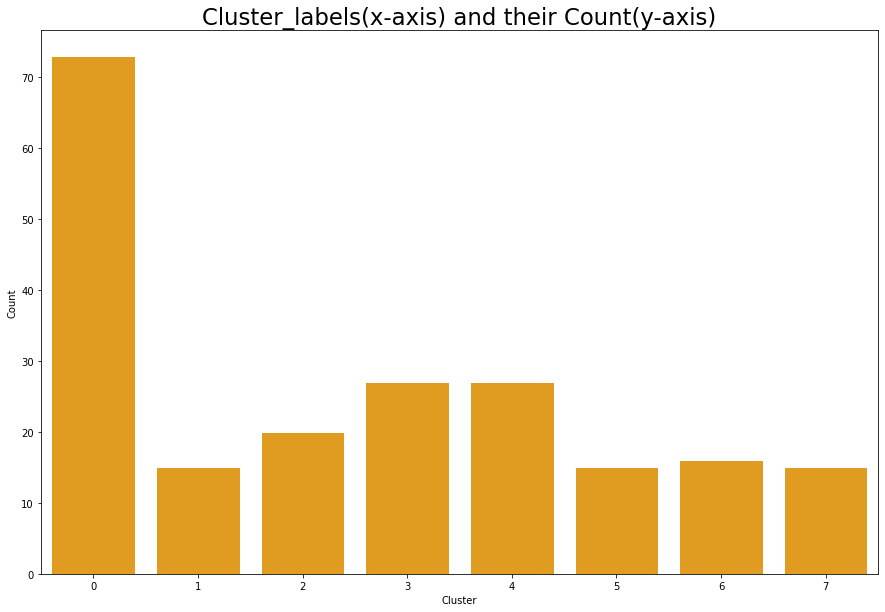

In [17]:
def plot_cluster_count(each_cluster_count):
    '''
    Plotting function for visualising Count of each Cluster label
    
    ==================Argument===============
    each_cluster_count-- dict with Cluster label and its count in data
    
    '''
    cluster_count_df = pd.DataFrame.from_dict(each_cluster_count,orient='index').reset_index()
    cluster_count_df.columns=['Cluster','Count']
    fig,ax = plt.subplots(1,figsize=(15,10))
    sns.set(font_scale=1.9)
    sns.barplot(x='Cluster',y='Count',data = cluster_count_df,ax=ax,color='orange' )
    plt.title('Cluster_labels(x-axis) and their Count(y-axis)')
    plt.show()
plot_cluster_count(each_cluster_count)

## TSNE for visualising Stocks which are clustered together

In [18]:
def remove_noise_dataset(df):
    '''
    Helper function to remove noisy points
    
    =======================Arguments================
    df - pandas dataframe
    
    =======================Return===================
    df - pandas dataframe
    
    '''
    df = df[df.label!=-1]
    return df

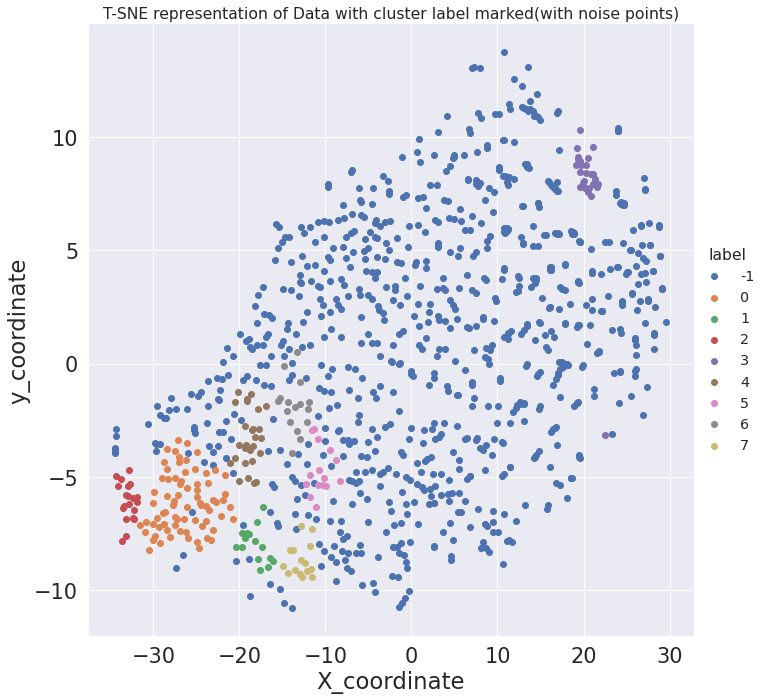

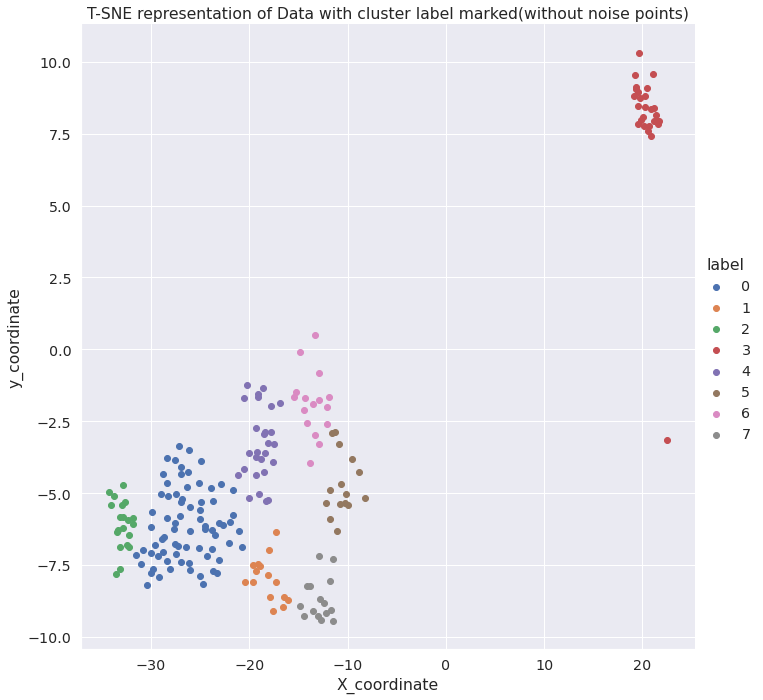

In [19]:
def tsne_visualisation(labels,clustering_ready_data_encoded):
    
    '''
    Plotting function for visualising clusters created in higher dimension
    
    =====================Arguments=====================
    labels------------------------ labels associated with each data point
    clustering_ready_data_encoded- data on which we are creating clusters
    
    '''
    model = TSNE(n_components=2,perplexity=70,n_iter=1000,learning_rate=5)
    ### Tried with different perplexity and learning rate, this configuration seemed ideal after visualising in 2-Dimension
    tsne_data = model.fit_transform(clustering_ready_data_encoded)
    tsne_df = pd.DataFrame(data=tsne_data,columns=('X_coordinate','y_coordinate'))
    tsne_df['label'] = labels
    
    
    g= sns.FacetGrid(tsne_df, height=10,hue='label')
    sns.set(font_scale=1.3)
    plt.title('T-SNE representation of Data with cluster label marked(with noise points)')
    g.map(plt.scatter, 'X_coordinate', 'y_coordinate').add_legend()
    plt.show()
    
    tsne_df_2 = remove_noise_dataset(tsne_df)  ### Removing noisy clusters
    g= sns.FacetGrid(tsne_df_2, height=10,hue='label')
    plt.title('T-SNE representation of Data with cluster label marked(without noise points)')
    g.map(plt.scatter, 'X_coordinate', 'y_coordinate').add_legend()
    plt.show()
    
    
tsne_visualisation(tsne_label,clustering_ready_data_encoded)

**Observation:**

   - Even after changing configuration of T-SNE and DBSCAN lot of times it seems that DBSCAN algorithm on T-SNE features is not performing a good job
    
   - There are lot of Noisy Clusters and even the clusters identified are very close to each other
   
   - To sum up, T-SNE features are not good for clustering
    


## Visualising Time Series in Clusters

In [21]:
def plot_time_series_cluster(n_cluster,df,continuous_column):
    '''
    Plotting function to plot time series data in each cluster
    
    ===========================Arguments===================
    n_cluster---------- Total number of %%capturelusters
    df----------------- pandas dataframe
    continuous_column-- Columns which has the time series data
    
    
    '''
    for cluster_label in range(n_cluster):
        data_loc = list(df[df['label'] ==cluster_label].index)
        fig,(ax) = plt.subplots(1,figsize=(15,10))
        for location in data_loc[0:6]:
            df[continuous_column].loc[location].plot(ax=ax,label=df['Security'].loc[location])
        plt.title('Closing Price for some Equities mentioned in legend from Jan-12 to Nov-20 for cluster ' + str(cluster_label))
        plt.xlabel('Jan 12 to Nov 20')
        plt.ylabel('Closing Price')
        plt.legend()

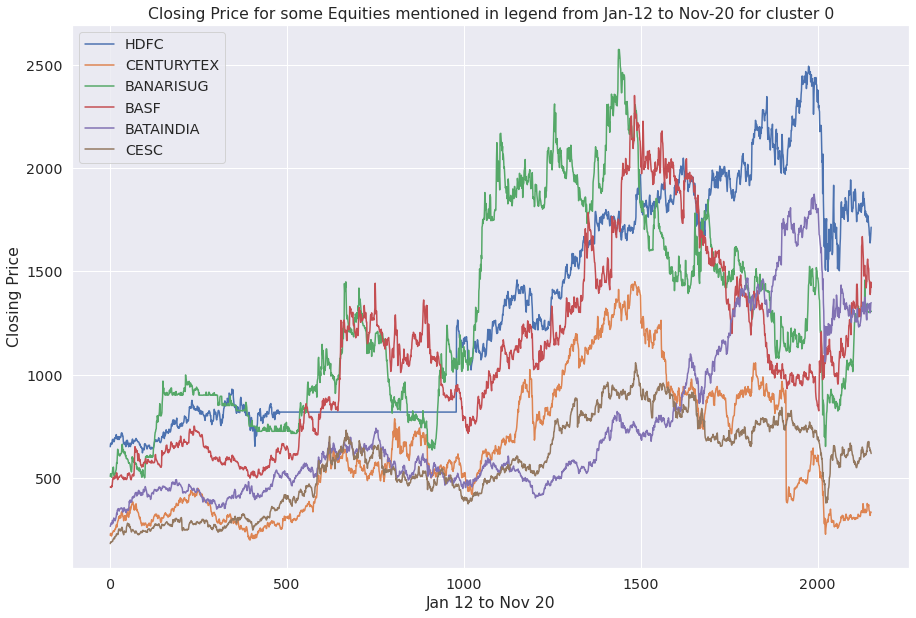

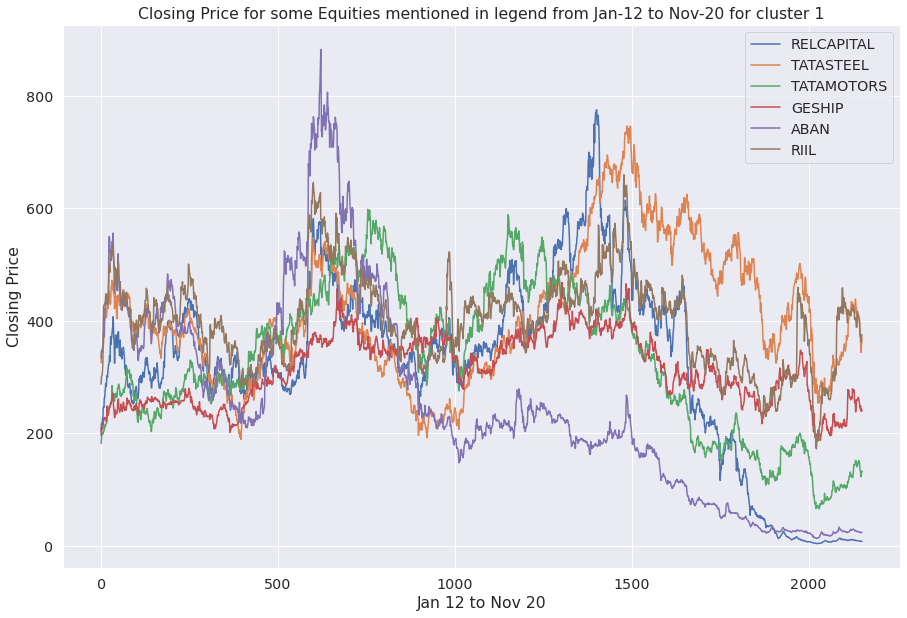

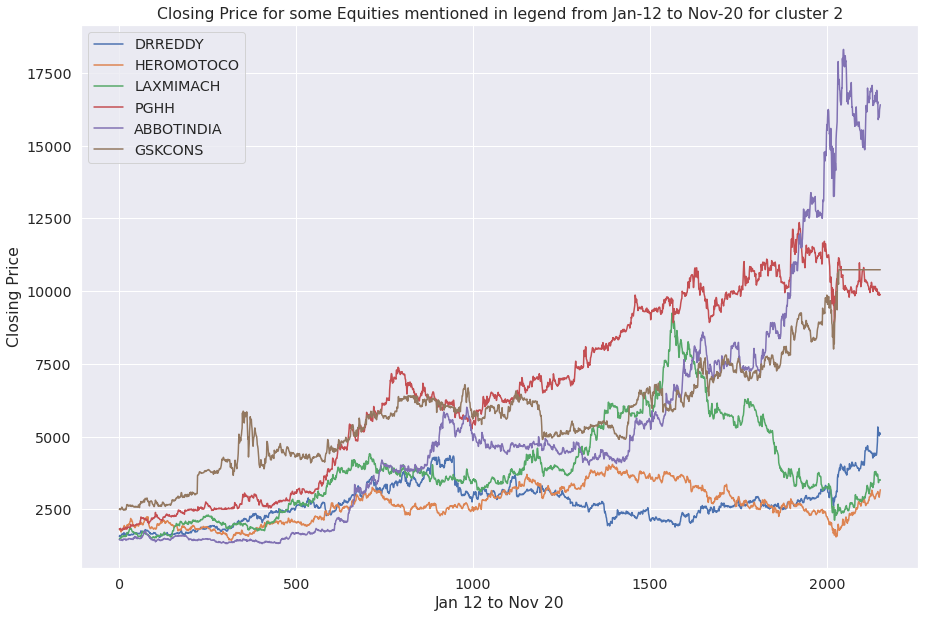

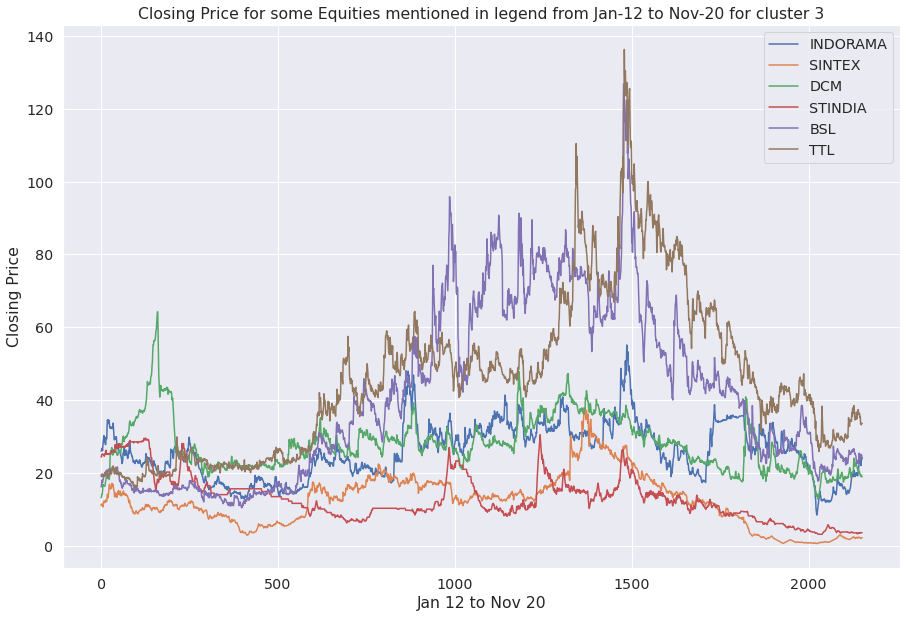

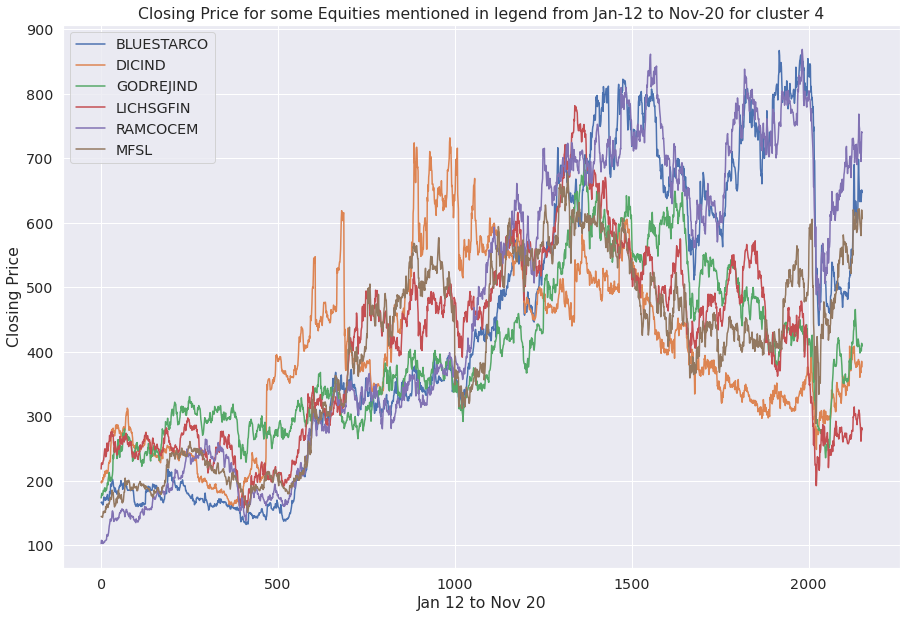

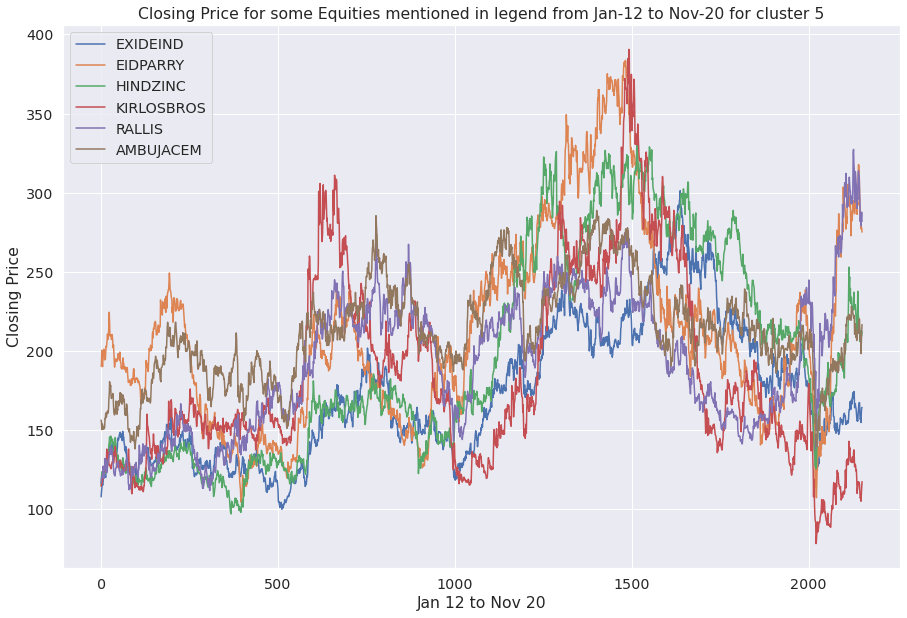

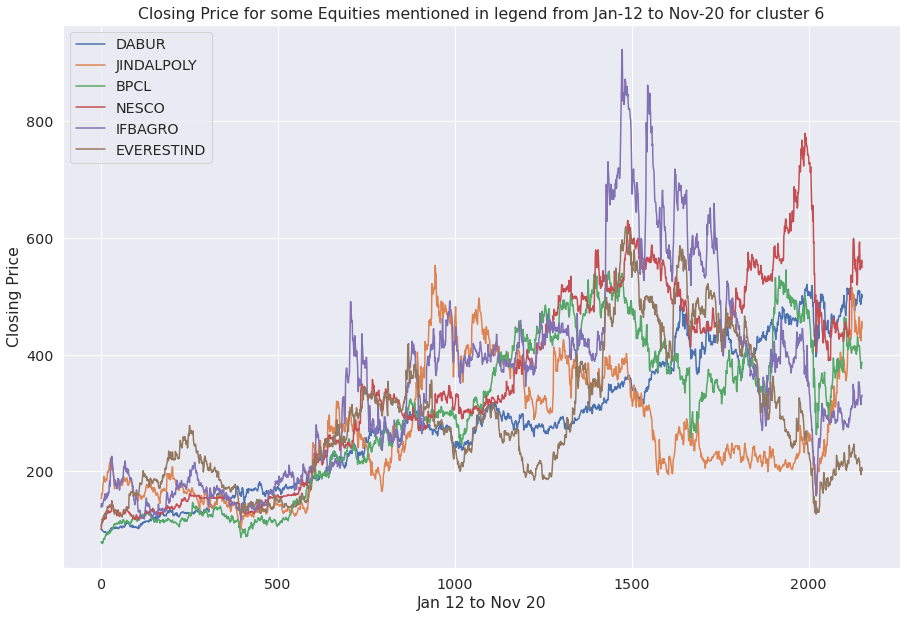

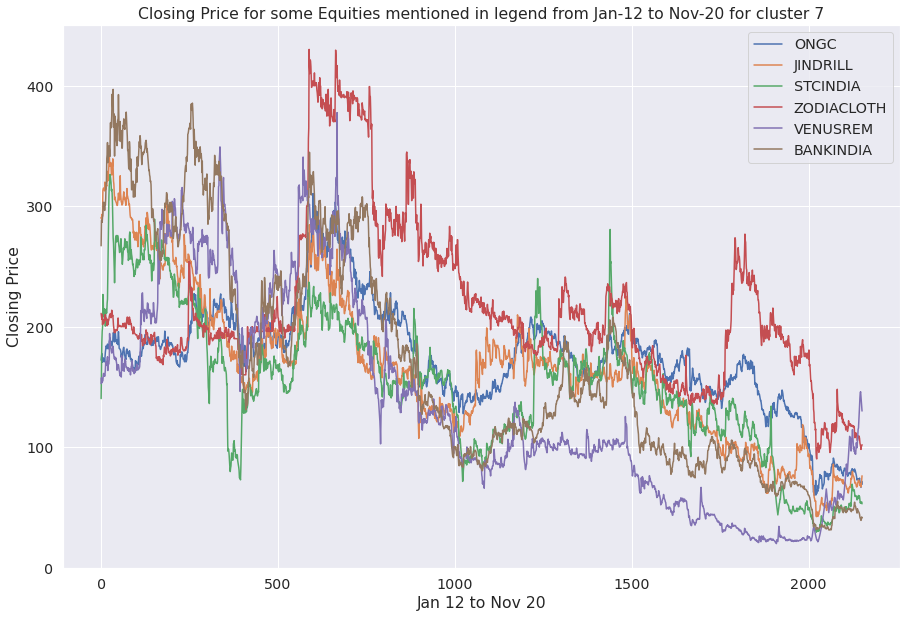

In [22]:
clustering_ready_data_2 = clustering_ready_data.copy()
clustering_ready_data_2['label'] = labels
clustering_ready_data_2['Security'] = security_id
clustering_ready_data_2['Industry']  = industry
clustering_ready_data_2 = remove_noise_dataset(clustering_ready_data_2)
n_cluster = len(each_cluster_count)
plot_time_series_cluster(n_cluster,clustering_ready_data_2,continuous_column)
## This time series data is not normalized, I am using original data to plot the graph,
## normalized data is used in T-SNE and DBSCAN


## Industry each cluster belongs to

In [23]:

def cluster_industry(n_cluster,df):
    '''
    Helper function to know what industries belongsi in each cluster
    
    ===========================Arguments===================
    n_cluster---------- Total number of %%capturelusters
    df----------------- pandas dataframe
    
    '''
    
    cluster_industry = dict()
    
    for cluster_label in range(n_cluster):
        temp = [ ]
        data_loc = list(df[df['label'] ==cluster_label].index)
        for location in data_loc:
            temp.append(df['Industry'].loc[location])
        cluster_industry[cluster_label] = temp
        print('\nIndustries which belong cluster',cluster_label,'are',np.unique(cluster_industry[cluster_label]))
cluster_industry(n_cluster,clustering_ready_data_2)


Industries which belong cluster 0 are ['Auto Parts &amp; Equipment' 'BPO/KPO' 'Banks'
 'Breweries &amp; Distilleries' 'Broadcasting &amp; Cable TV'
 'Cement &amp; Cement Products' 'Cigarettes-Tobacco Products'
 'Commercial Vehicles' 'Commodity Chemicals'
 'Construction &amp; Engineering' 'Electric Utilities'
 'Finance (including NBFCs)' 'Footwear' 'Furniture-Furnishing-Paints'
 'Healthcare Facilities' 'Heavy Electrical Equipment' 'Holding Companies'
 'Housing Finance ' 'IT Consulting &amp; Software' 'Industrial Machinery'
 'Integrated Oil &amp; Gas' 'Internet &amp; Catalogue Retail'
 'Investment Companies' 'Other Agricultural Products'
 'Other Elect.Equip./ Prod.' 'Other Financial Services'
 'Other Industrial Goods' 'Packaged Foods' 'Personal Products'
 'Pharmaceuticals' 'Refineries/ Petro-Products' 'Restaurants'
 'Specialty Chemicals' 'Specialty Retail' 'Sugar' 'Textiles']

Industries which belong cluster 1 are ['Banks' 'Coal' 'Commercial Vehicles' 'Construction &amp; Engineering'
 '

**Observation:**
   
  - Stocks Visualisation shows that Clustering is partially doing sensible job while pairing stocks/equity


 - One cluster is divided on basis of 1 industry, while other clusters are made up of different industries which further shows that T-SNE features with 3 dimensions are not useful

# Using PCA as dimensionality Reduction technique

## PCA for feature extraction which will be used in DBSCAN

In [281]:
from sklearn.decomposition import PCA
pca = PCA(n_components=400)
pca_features = pca.fit_transform(clustering_ready_data_encoded)

## DBSCAN for clustering similar stocks

In [282]:
each_cluster_count,labels = dbscan(eps=1,min_samples=9,data=pca_features) 
each_cluster_count.pop(-1) ### Do not need that noisy cluster
each_cluster_count_pca = each_cluster_count.copy()
pca_label = labels.copy()

==================================================Processing Data============================================
Total Clusters Found:	 0 
Noise Points:		 601 
Core/Border Point:	 0


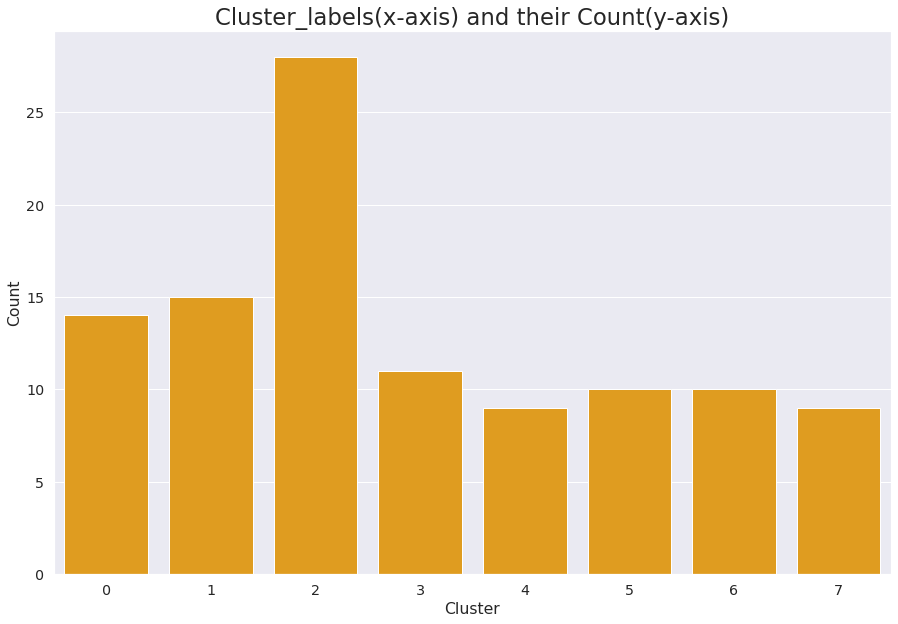

In [26]:
plot_cluster_count(each_cluster_count)

## TSNE for visualising Stocks which are clustered together

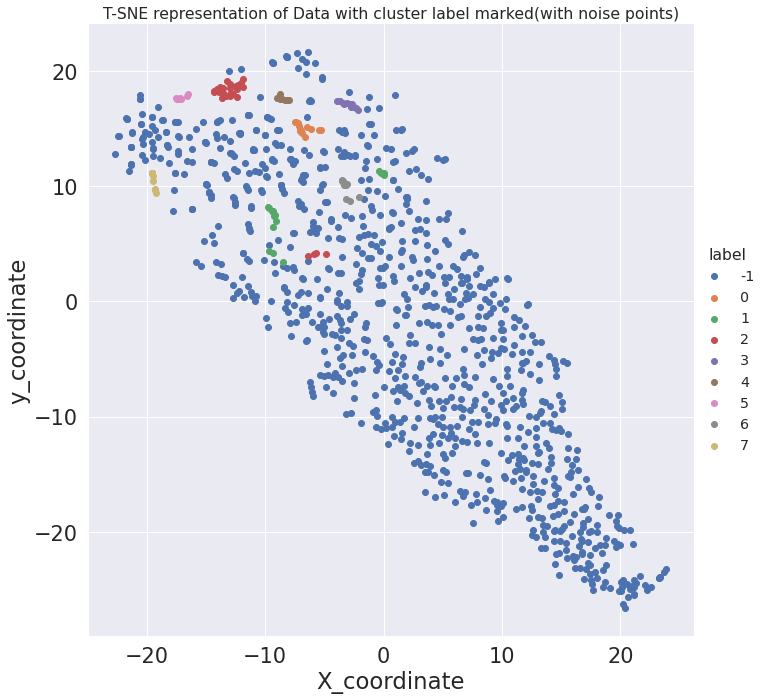

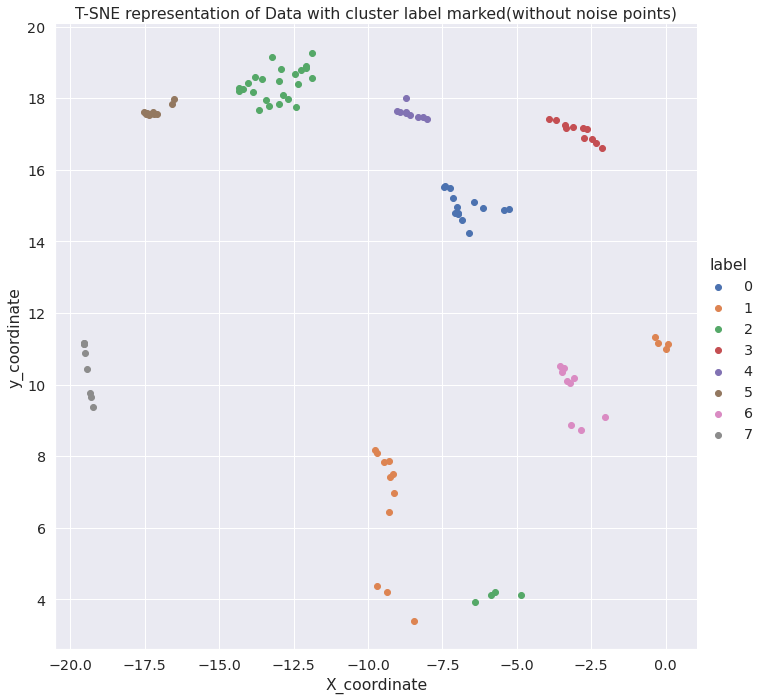

In [27]:
tsne_visualisation(pca_label,clustering_ready_data_encoded)

**Observation:**

   - By using PCA features we get better results than T-SNE features. each cluster is separated properly while there are lot of noise in clusters from T-SNE features




## Visualising Closing Price in Some Clusters

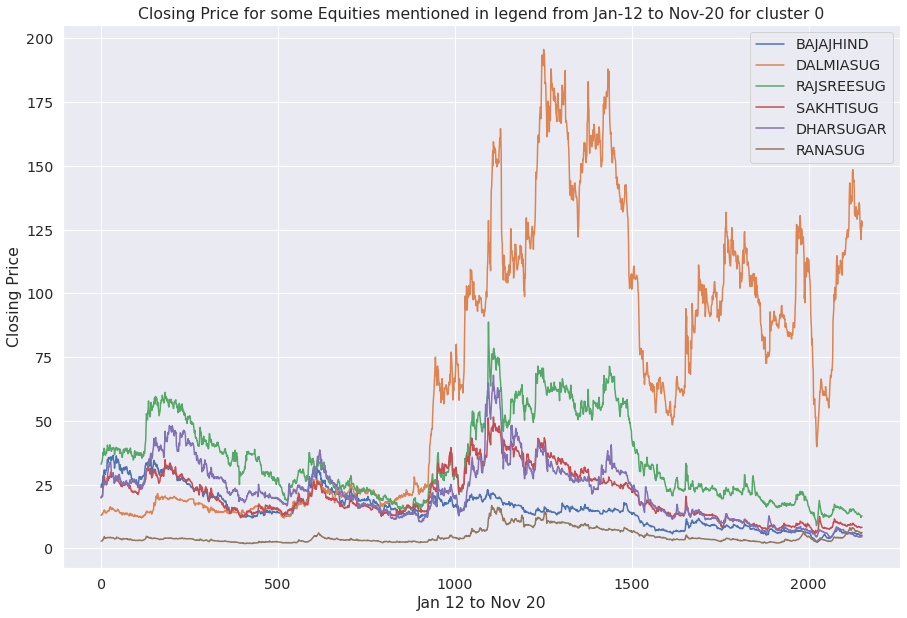

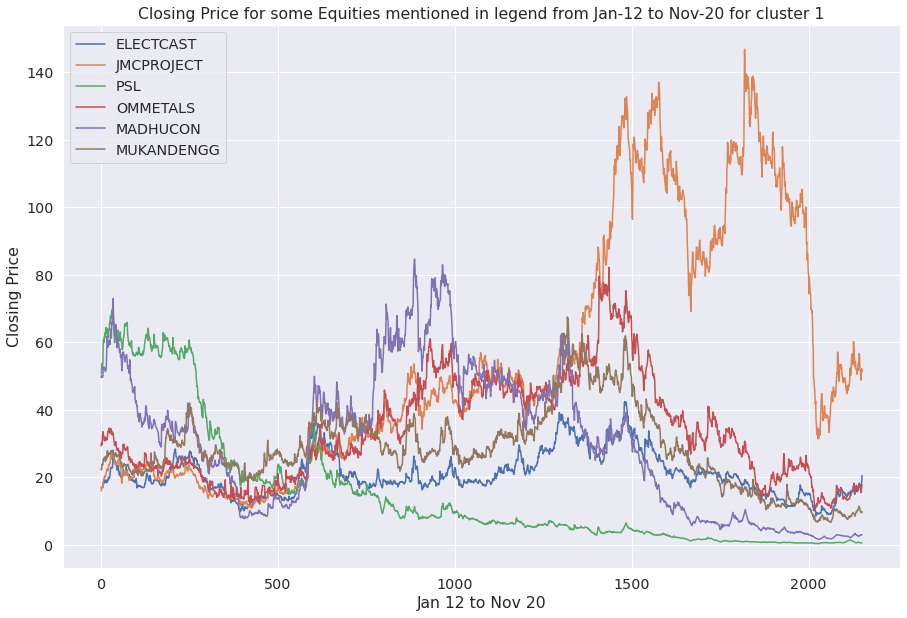

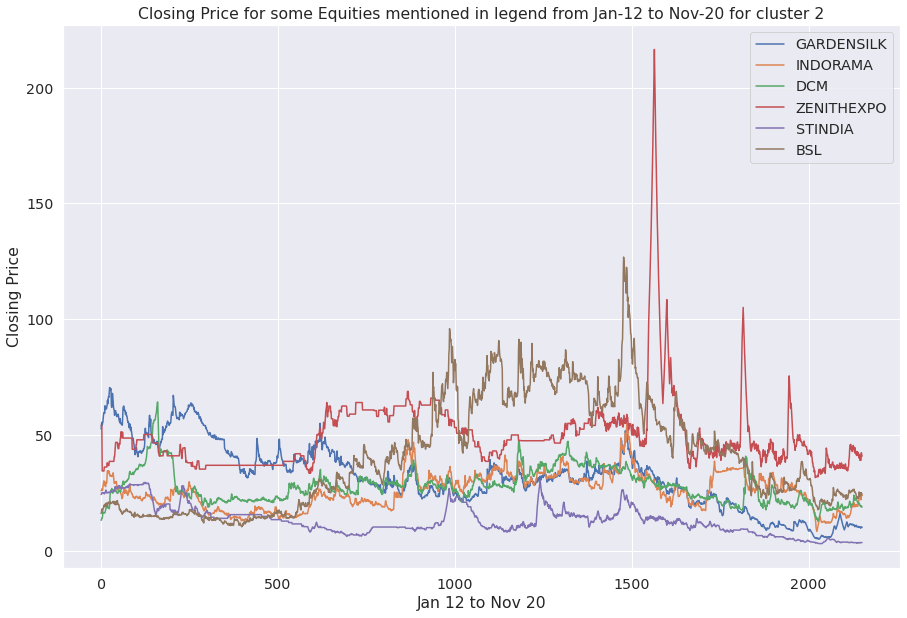

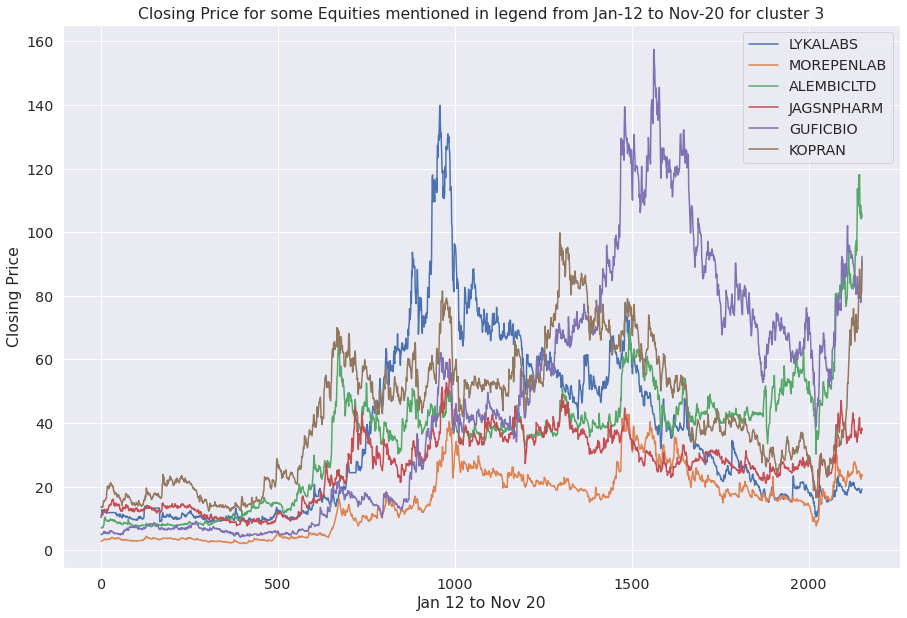

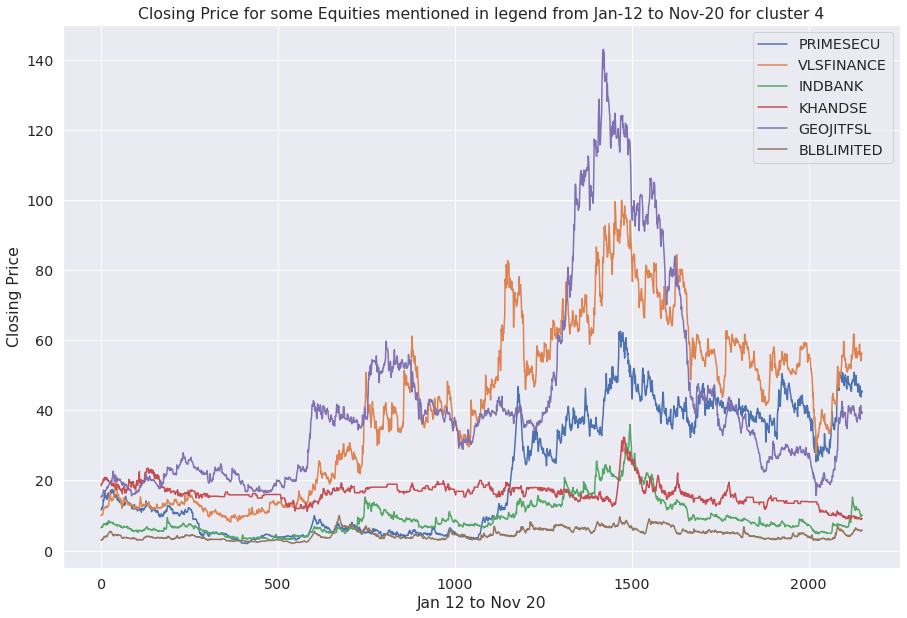

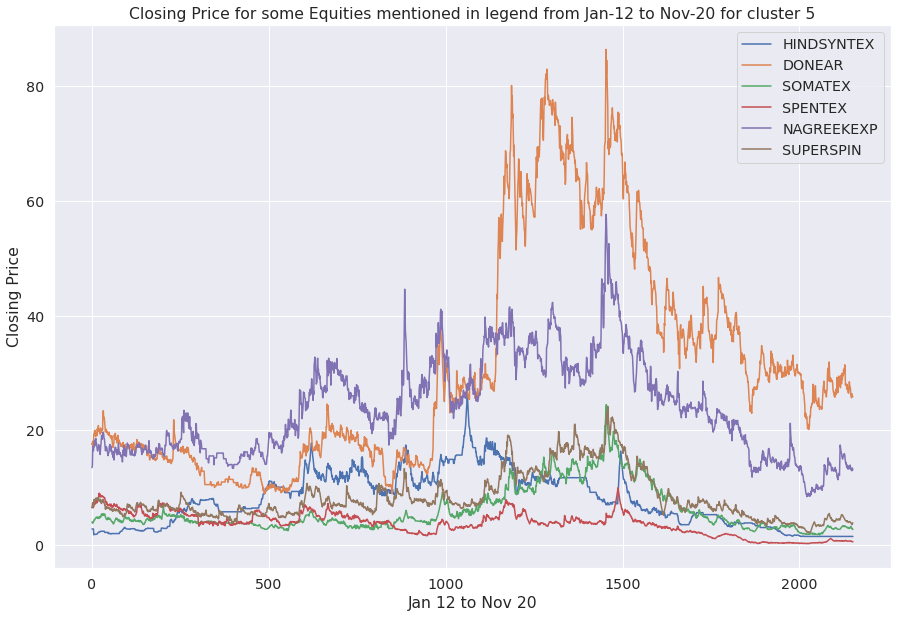

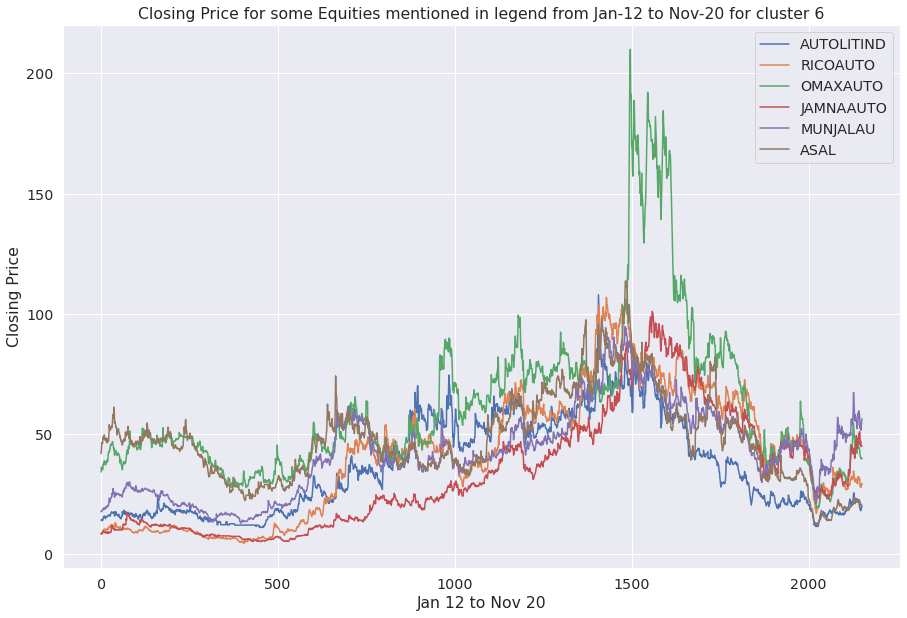

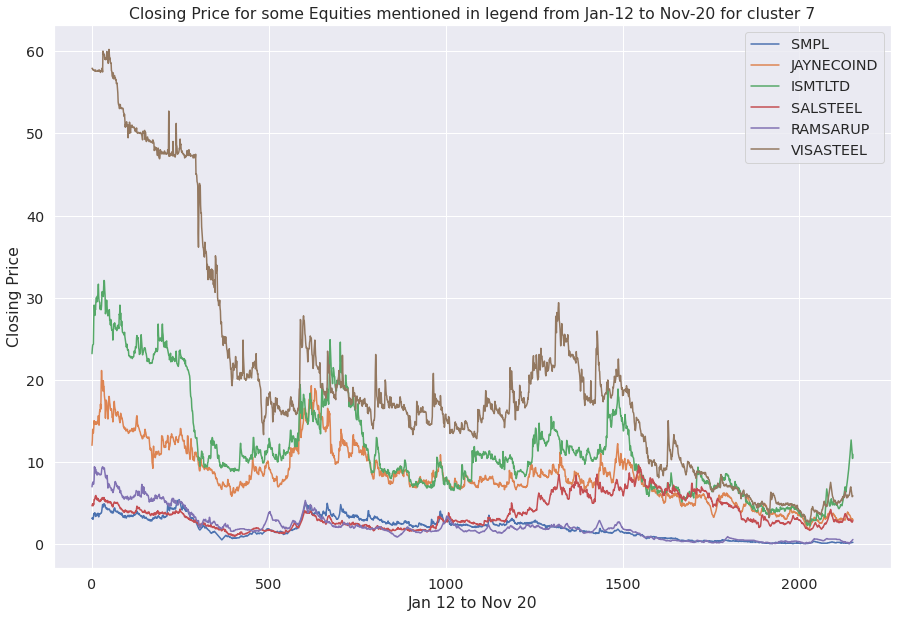

In [28]:
clustering_ready_data_2 = clustering_ready_data.copy()
clustering_ready_data_2['label'] = pca_label
clustering_ready_data_2['Security'] = security_id
clustering_ready_data_2['Industry']  = industry
clustering_ready_data_2 = remove_noise_dataset(clustering_ready_data_2)
n_cluster = len(each_cluster_count)
plot_time_series_cluster(n_cluster,clustering_ready_data_2,continuous_column)

In [29]:
cluster_industry(n_cluster,clustering_ready_data_2)


Industries which belong cluster 0 are ['Sugar']

Industries which belong cluster 1 are ['Construction &amp; Engineering']

Industries which belong cluster 2 are ['Textiles']

Industries which belong cluster 3 are ['Pharmaceuticals']

Industries which belong cluster 4 are ['Other Financial Services']

Industries which belong cluster 5 are ['Textiles']

Industries which belong cluster 6 are ['Auto Parts &amp; Equipment']

Industries which belong cluster 7 are ['Iron &amp; Steel/Interm.Products']


**Observation:**
   
   - Visualisation shows that Clustering is doing sensible job while pairing stocks/equity
    
   - Clusters are majorly divided based on their industries which is a good indicator as in real world also, pairs are generally b/w securities/stocks/equity which belong to same industries.

   - TSNE Visualisation for clusters based on PCA features is far better to T-SNE features, so I will be using PCA labels only for further study

# TSNE vs PCA

In [996]:
x = PrettyTable()
x.field_names = ["Featurization Algortihm","Clustering Algorith", "Total Clusters", "Noisy clusters","Core Points"]
x.add_row(['TSNE','DBSCAN',8 ,7,171])
x.add_row(['PCA','DBSCAN', 8 ,0,106])
print(x)

+-------------------------+---------------------+----------------+----------------+-------------+
| Featurization Algortihm | Clustering Algorith | Total Clusters | Noisy clusters | Core Points |
+-------------------------+---------------------+----------------+----------------+-------------+
|           TSNE          |        DBSCAN       |       8        |       7        |     171     |
|           PCA           |        DBSCAN       |       8        |       0        |     106     |
+-------------------------+---------------------+----------------+----------------+-------------+


# Finding best pair on PCA Features cluster

In [30]:
def cointegration_test(df,continuous_column,n_cluster,significance=0.05):
    '''
    Function to perform cointegration test to find out the p_value of each pairs of security

    What is Cointegration?
    #https://corporatefinanceinstitute.com/resources/knowledge/other/cointegration/
    #https://www.statisticshowto.com/cointegration/
    - Cointegration is a technique used to find a possible correlation between time series processes in the long term.
    - We are trying to identify whether residuals are stationary or not
    
    H0(Null Hypothesis) : There is no Cointegration among pairs
    H1(Alternative Hypothesis) : There is a cointegration relation among pairs
    
    ===========================Arguments==============================
    df - pandas dataframe on which co-integration test needs to be performed
    continuous_column - Columns which contain the time series data
    n_cluster --------- Total clusters
    significance ------ measure of strength of the test to reject Null Hypothesis
    
    ===========================Return==================================
    p_value_matrix - matrix containing p_value for each paired security stored at index location of data frame
                     Example: if Security_1 has index location '420' and Security_2 has index location '120' in dataframe
                     it's corresponding p_value will be stored at [420,120] location in matrix
                
    t_score_matrix - matrix containing t_score for each paired security following same storage method as p_value_matrix
    
    pair_dict ------ dictionary containing only those pairs which are significant or which reject the null hypothesis
                     Format - {(Security_1,Security_2,Cluster_label : P_value)}

    '''
    
    pair_dict = dict()
    
    for cluster_label in range(n_cluster):
        data_1 = df[df['label']==cluster_label][continuous_column]
        data_2 = df[df['label']==cluster_label][continuous_column]
        max_index = np.max(df.index) + 1
        p_value_matrix = np.zeros((max_index,max_index))
        t_score_matrix = np.zeros((max_index,max_index))
        for y0,y0_index in zip(np.array(data_1),data_1.index):
            for y1,y1_index in zip(np.array(data_2),data_2.index):
                if y0_index == y1_index:
                    continue
                else:
                    t_score,p_value,critical_value = coint(y0,y1)
                    p_value_matrix[y0_index,y1_index] = p_value
                    t_score_matrix[y0_index,y1_index] = t_score
                    
                    if p_value<significance: ##Only Significat Pair
                        pair_dict[(df['Security'].loc[y0_index],df['Security'].loc[y1_index],cluster_label)] = p_value
                        
    return p_value_matrix,t_score_matrix,pair_dict

In [31]:
clustering_ready_data_2 = clustering_ready_data.copy()
clustering_ready_data_2['label'] = pca_label
clustering_ready_data_2['Security'] = security_id
clustering_ready_data_2['Industry']  = industry
clustering_ready_data_2 = remove_noise_dataset(clustering_ready_data_2)
n_cluster = len(each_cluster_count)

p_value_matrix,t_score_matrix,pair_dict = cointegration_test(clustering_ready_data_2,continuous_column,n_cluster)

In [32]:
print('Significant pairs found are ',len(pair_dict))

Significant pairs found are  237


## Choosing Best pair

   - While choosing best pair firstly I am focused on the part which pair is more significant than others
   - Secondly, I want to choose a pair for which past data for years is available for testing

In [67]:
top_10_pair = sorted(pair_dict.items(),key=lambda x:x[1])[:20]
print('Top 10 Pair according to lowest p-value are: ')
top_10_pair

Top 10 Pair according to lowest p-value are: 


[(('SUPERSPIN', 'GTNTEX', 5), 1.530629938118975e-07),
 (('GTNTEX', 'SUPERSPIN', 5), 2.850718367082156e-07),
 (('REMSONSIND', 'LUMAXTECH', 6), 1.221861347792766e-05),
 (('EASTSILK', 'CNOVAPETRO', 2), 2.066154100858553e-05),
 (('LUMAXTECH', 'REMSONSIND', 6), 2.7927064262180703e-05),
 (('AUTOLITIND', 'SHIVAMAUTO', 6), 3.451248008385964e-05),
 (('SHIVAMAUTO', 'AUTOLITIND', 6), 5.179924582043151e-05),
 (('BLBLIMITED', 'INDBANK', 4), 5.376554709649459e-05),
 (('BLBLIMITED', 'BIRLAMONEY', 4), 6.467265386456333e-05),
 (('BLBLIMITED', 'GEOJITFSL', 4), 0.0001671222171612553),
 (('ZENITHEXPO', 'TTL', 2), 0.00019218183568493746),
 (('BLBLIMITED', 'VLSFINANCE', 4), 0.0002801163007361573),
 (('ZENITHEXPO', 'EUROTEXIND', 2), 0.000291500263214048),
 (('BIRLAMONEY', 'GEOJITFSL', 4), 0.00029733872433183005),
 (('MARALOVER', 'SUTLEJTEX', 2), 0.0003341667596552248),
 (('CNOVAPETRO', 'EASTSILK', 2), 0.000346398120395175),
 (('TTL', 'ASHIMASYN', 2), 0.00037599240851246036),
 (('REMSONSIND', 'JAMNAAUTO', 6),

Observation:
        - I will work with SHIVAMAUTO and AUTOLITIND as simply because other stocks are mainly penny stocks and  SHIVAMAUTO and AUTOLITIND has past data available till 2009 for testing purpose

## Visualising Best Pair

In [240]:
start_date = '01-01-2009'
end_date = '10-07-2021'

In [241]:
download_data('KANCOTEA.BO','yahoo',start_date,end_date)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KANCOTEA.BO: No data found for this date range, symbol may be delisted


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []

In [78]:
start_date = '01-01-2009'
end_date = '13-07-2021'

autolitind = download_data('BIRLAMONEY.NS','yahoo',start_date,end_date)
shivamauto = download_data('GEOJITFSL.NS','yahoo',start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


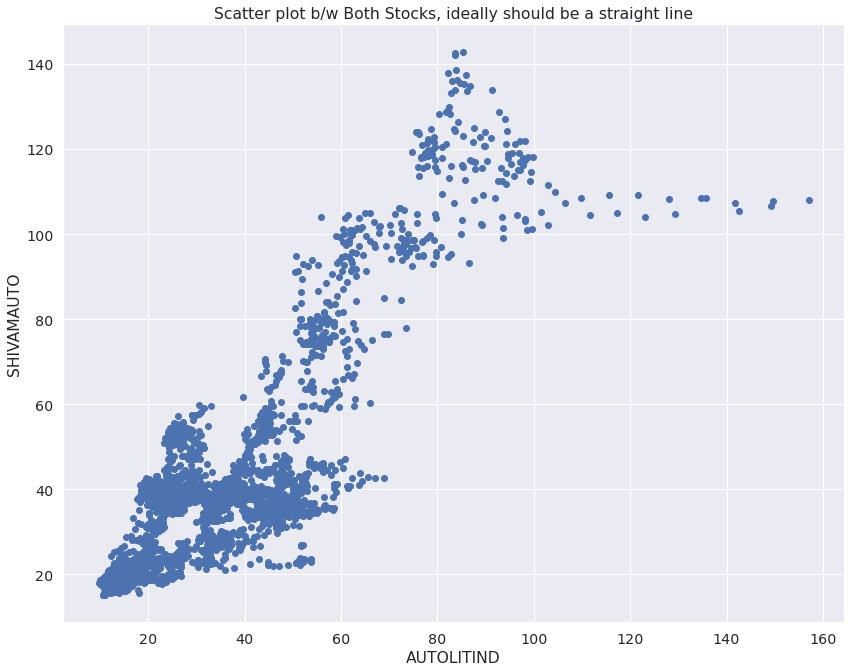

In [81]:
fig,ax = plt.subplots(1,figsize=(14,11))


ax.scatter(autolitind.Close,shivamauto.Close)
ax.set_title('Scatter plot b/w Both Stocks, ideally should be a straight line')
ax.set_xlabel('AUTOLITIND')
ax.set_ylabel('SHIVAMAUTO')
plt.show()

In [ ]:
fig,ax = plt.subplots(1,figsize=(14,11))

autolitind.Close.plot(ax=ax,label='AUTOLITIND')
shivamauto.Close.plot(ax=ax,label='SHIVAMAUTO')
plt.title('Closing Price from Jan-12 to Feb-20 for Shivamauto and Autolitind')
plt.xlabel('Jan 12 to Sep 20')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Feature Engineering

4. Volume Price Trend Indicator
[Reference](https://commodity.com/technical-analysis/price-volume-trend/)
 - It is a **cumulative** indicator and uses Volume and percentage change in Price from previous day to identify divergences in stocks
 - Formula:
     - VPT = Previous VPT + Volume x (Today’s Closing Price – Previous Closing Price) / Previous Closing Price
     - ( (Today’s Closing Price – Previous Closing Price) / Previous Closing Price )==> This whole term is percentage change in price which is multiplied to Volume and added to previous day VPT
 - The interpretations of the VPT can be summed up as follows:
[Reference](https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/volume-price-trend-indicator-vpt/)
    - An increase in price, as well as volume, confirms the price trend upward.
    - A decrease in price, as well as volume, confirms the price trend downward.
    - An increase in price accompanied by a decreasing or flat volume trend is a divergence and may suggest that the downward price movement is weak and won’t hold.
    - A decrease in price accompanied by an increasing or flat volume trend is a divergence and may suggest that the upward price movement is weak and won’t hold.The average true range is a price volatility indicator showing the average price variation of assets within a given time period.
    
    7. Average Directional Movement Index
 - The Average Directional Index (ADX) is used to measure the strength or weakness of a trend
 - While ADX does not measure the direction, DI+ and DI- measure the direction of trend
 - The trend has strength when ADX is above 25; the trend is weak or the price is trendless when ADX is below 20.
 - In general, the bulls have the edge when +DI is greater than -DI, while the bears have the edge when -DI is greater
 - Formula:[REFERENCE](https://www.investopedia.com/terms/a/adx.asp)
     ![image-2.png](attachment:image-2.png)
     

In [5]:
data = pd.DataFrame({
    'EQ_1_close' : shivamauto.Close,     'EQ_2_close' : autolitind.Close, ##At what price did it close
    'EQ_1_open'  : shivamauto.Open,      'EQ_2_open'  : autolitind.Open,  ##At what price did it open
    'EQ_1_high'  : shivamauto.High,      'EQ_2_high'  : autolitind.High,  ##Highest Price on that day
    'EQ_1_low'   : shivamauto.Low,       'EQ_2_low'   : autolitind.Low,   ##Lowest Price on that day
    'EQ_1_vol'   : shivamauto.Volume,    'EQ_2_vol'   : autolitind.Volume ##Volume Traded
    
})

**Features:**

- Leading Indicators: They inform about the future trend in time series
- Lagging Indicators: They are used to confirm the leading indicators

1. RSI - Relative Strength Index:
[Calculation Example](https://i.imgur.com/2fnvS7K.png)
 - It is leading **momentum** indicator which helps in identifying trend reversal of time series
 - It oscillates b/w 0 and 100.
 - Formula
     - RSI = 100 -  100/(1 + RS)
     - RS = Average points Gain over a fixed period by stock(at least 14 days) / Average points loss over a fixed period by stock(at least 14 days)
 
 - When 0<=RSI <=20, Stock is supposed to be oversold and ready for a upward correction(buying will start)
 - When 80<=RSI<=100, Stock is supposed to be overbought and ready for downward correction(selling will start)

2. Stochastic RSI:
[Calculation Example](https://i.imgur.com/BJvUSiB.png)
[Reference](https://www.investopedia.com/terms/s/stochrsi.asp#:~:text=The%20Stochastic%20RSI%20(StochRSI)%20is,than%20to%20standard%20price%20data.)
 - It is a leading **momentum** indicator based on RSI
 - In Practice RSI is a slow moving indicator, to fix the slowness Stochastic RSI moves rapidly from overbought to oversold.
 - Formula
     - t' StochRSI = (t'-period RSI - Lowest Low RSI in t' period) / (Highest High RSI in t'period - Lowest Low RSI in t' period)

 - 0 <= Stochastic-RSI <= 1
 - A StochRSI reading above 0.8 is considered overbought, while a reading below 0.2 is considered oversold
 - Overbought doesn't necessarily mean the price will reverse lower, just like oversold doesn't mean the price will reverse higher. Rather the overbought and oversold conditions simply alert traders that the RSI is near the extremes of its recent readings.
 - When the StochRSI is above 0.50, the security may be seen as trending higher and vice versa when it's below 0.50.


3. Money Flow Index:
[Calculation Example](https://i.imgur.com/tgNhIoA.png)
 - It is leading **volume** based indicator and it does the same job as RSI
 - While RSI consider the price, MFI considers both price and Volume
 - It is also called weighted Volume RSI
 - It oscillates b/w 0 and 100
 - Formula
     - MFI = 100 - 100/(1+ MFR)
     - MFR(Money flow Ratio) = t-Period Positive Money flow / t-Period Negative Money Flow, where t = 14 typically
     - Money Flow = Typical Price * Volume traded on that day
     - Typical Price = (High + Low + Close) / 3
 
 - When 0<=MFI<=20, Stock is supposed to be oversold and ready for a upward correction(buying will start)
 - When 80<=MFI<=100, Stock is supposed to be overbought and ready for downward correction(selling will start)
4. Accumulation/Distribution Index/Indicator
[Calculation Example](https://i.imgur.com/8fZJYGy.png)
 - It is a **cumulative** indicator and uses **Volume** and Price both to identify whether a Stock is being Accumulated(bought) or Distributed(Sold)
 - Or it can be said it identifies the cumulative flow of money into and out of stock and helps in identifying trend reversal
 - If ADL line is going downward but stock is going up, then it is a indicator of downward correction,as it is possible someone sold lots of volume of stocks and vice - versa
 - Formula
     - Money Flow Multiplier = [(Close  -  Low) - (High - Close)] /(High - Low) 
     - 0<=MFM<=1 is +ve when Close = Upper half of candle stick chart ( When it is in upper half it is an indicator of **buying pressure > selling pressure**)
     - 0<=MFM<=1 is -ve when Close = Lower half of candle stick chart( When it is in lower half it is an indicator of **buying pressure < selling pressure**)
     - Money Flow Volume = Money Flow Multiplier x Volume for the Period
     - ADL = Previous ADL + Current Period's Money Flow Volume
 - Whether ADL indicator goes upwards or downwards depends on sign of MF

5. Average True Range
[Calculation Example](https://i.imgur.com/T0kfVoJ.png) ,
[Reference](https://school.stockcharts.com/doku.php?id=technical_indicators:average_true_range_atr)
 - The average true range is a price **volatility** indicator showing the average price variation of assets within a given time period. 
 - It is generally calculated on 14 day periods of True Range
 - Formula
     - ATR = (13 x Previous Day ATR + Current TR ) / 14
     - TR = MAX( ( Today_High - Today_low) , ABS(Today_High - Previous_Close) , ABS( Today_Low - Previous_Close) )
 - True range takes the gap b/w price from current from previous day to identify the movement of price
 - ATR only measures the volatility, it does not measure direction of price movement
 - Higher the ATR value, higher is the volatility and vice versa
 

6. Bollinder Bands
[Calculation Example](https://i.imgur.com/MPobbmQ.png)
 - Bollinger Bands are envelopes plotted at a standard deviation level above and below a simple moving average of the price. Because the distance of the bands is based on standard deviation
 - When the bands tighten during a period of low volatility, it raises the likelihood of a sharp price move in either direction.
 - When the bands separate by an unusual large amount, volatility increases and any existing trend may be ending.
 - Formula:
     - Middle Band = 20-day simple moving average (SMA)
     - Upper Band = 20-day SMA + (20-day standard deviation of price x 2) 
     - Lower Band = 20-day SMA - (20-day standard deviation of price x 2)
 [Band Example](https://i.imgur.com/HJkiO1B.png)
 

7. Exponential Moving Average
    [Calculation Example](https://i.imgur.com/BZEQgOG.png)
 - They are lagging indicator confirming the trend
 - more weightage is given to recent prices while taking average
 - Formula

     - Initial EMA: 10-period sum / 10
     - Multiplier: (2 / (Time periods + 1) ) = (2 / (10 + 1) ) = 0.1818 (18.18%)
     - EMA: {Close - EMA(previous day)} x multiplier + EMA(previous day). 
8. Moving Average Convergence Divergence Indicator
 - As the name suggests, MACD is all about the convergence and divergence of the two moving averages. Convergence occurs when the two moving averages move towards each other, and divergence occurs when the moving averages move away.
 - Formula
     - MACD = 12 day EMA - 26 day EMA(Exponential Moving average)
 - The sign associated with the MACD just indicates the direction of the stock’s move. '+' for upward move and '-' for downward move.
     - positive sign is only possible if 12 day EMA> 26 day EMA and if that is the case then as we know EMA depends more on recent values, so price must be trending in upward direction.
 - Magnitude of MACD signifies the strength of upward and downward trend.
 [MACD line GRAPH](https://www.notion.so/Case-Study-1-a0d7bc10144845da932368fee4fd2f9f#0d1b9cfd663640e59a42d62fc3a2ce15)
 - When the MACD Line crosses the centerline from the negative territory to positive territory, it means there is a divergence between the two averages. This is a sign of increasing bullish momentum; therefore, one should look at buying opportunities and vice versa
 
9. Log Return
 - Formula
     - Log(current_price / previous_price)
10. Residual/Spread
 - We will use linear regression to fit both Stocks and calculate the resdual and use it as a feature here.
 - As this pair passed through cointegration test, residual should come as stationery 

In [6]:
def residual(Y,X):
    '''
    Function to Calculate Residual using Linear Regression
    
    ================Arguments===============
    Y- Response Variable
    X- Dependent Variable
    
    ================Return==================
    res- Residual
    '''

    
    model = sm.OLS(Y,X)
    clf = model.fit()
    beta = clf.params[0]
    res = Y - X * beta
    return res

In [7]:

def feature_engineering(data):
    
    '''
    Function to create time series features in dataset
    
    '''
    
    ###https://github.com/bukosabino/ta
    
    #Momentum
    #1) RSI
    data['EQ_1_rsi'] = ta.momentum.rsi(data['EQ_1_close'],window=14,fillna=False)
    data['EQ_2_rsi'] = ta.momentum.rsi(data['EQ_2_close'],window=14,fillna=False)
    
    #2) SRSI
    data['EQ_1_srsi'] = ta.momentum.stochrsi(data['EQ_1_close'],window=14,fillna=False)
    data['EQ_2_srsi'] = ta.momentum.stochrsi(data['EQ_2_close'],window=14,fillna=False)
    
    #Volume Indicator
    
    #3) MFI
    data['EQ_1_mfi'] = ta.volume.money_flow_index(data['EQ_1_high'],data['EQ_1_low'],data['EQ_1_close'],data['EQ_1_vol'],window=14)
    data['EQ_2_mfi'] = ta.volume.money_flow_index(data['EQ_1_high'],data['EQ_1_low'],data['EQ_1_close'],data['EQ_2_vol'],window=14)
    
    #4) ADL
    data['EQ_1_adl'] = ta.volume.acc_dist_index(data['EQ_1_high'],data['EQ_1_low'],data['EQ_1_close'],data['EQ_1_vol'])
    data['EQ_2_adl'] = ta.volume.acc_dist_index(data['EQ_2_high'],data['EQ_2_low'],data['EQ_2_close'],data['EQ_2_vol'])
    
    #Volatility
    
    #ATR
    data['EQ_1_atr']  = ta.volatility.average_true_range(data['EQ_1_high'],data['EQ_1_low'],data['EQ_1_close'],window=14)
    data['EQ_2_atr']  = ta.volatility.average_true_range(data['EQ_2_high'],data['EQ_2_low'],data['EQ_2_close'],window=14)
    
    #Bollinger Bands
    data['EQ_1_bb'] = ta.volatility.bollinger_mavg(data['EQ_1_close'],window=20)
    data['EQ_2_bb'] = ta.volatility.bollinger_mavg(data['EQ_2_close'], window=20)
    
    #Trend Indicator
    
    #EMA
    data['EQ_1_ema'] = ta.trend.ema_indicator(data['EQ_1_close'], window=14)
    data['EQ_2_ema'] = ta.trend.ema_indicator(data['EQ_1_close'], window=14)
    
    #MACD
    data['EQ_1_macd'] = ta.trend.macd(data['EQ_1_close'], window_fast=12, window_slow=26)
    data['EQ_2_macd'] = ta.trend.macd(data['EQ_2_close'], window_fast=12, window_slow=26)
    
    #Others
    
    #Daily log return
    data['EQ_1_dlr'] = ta.others.daily_log_return(data['EQ_1_close'])
    data['EQ_2_dlr'] = ta.others.daily_log_return(data['EQ_2_close'])
    
    ##Residual
    data['Res_open'] = residual(data['EQ_2_open'],data['EQ_1_open'])
    
    data['Res_close'] = residual(data['EQ_2_close'],data['EQ_1_close'])
    
    data['Res_high'] = residual(data['EQ_2_high'],data['EQ_1_high'])
    
    data['Res_low'] = residual(data['EQ_2_low'],data['EQ_1_low'])
    
    return data
    


In [8]:
data = feature_engineering(data)

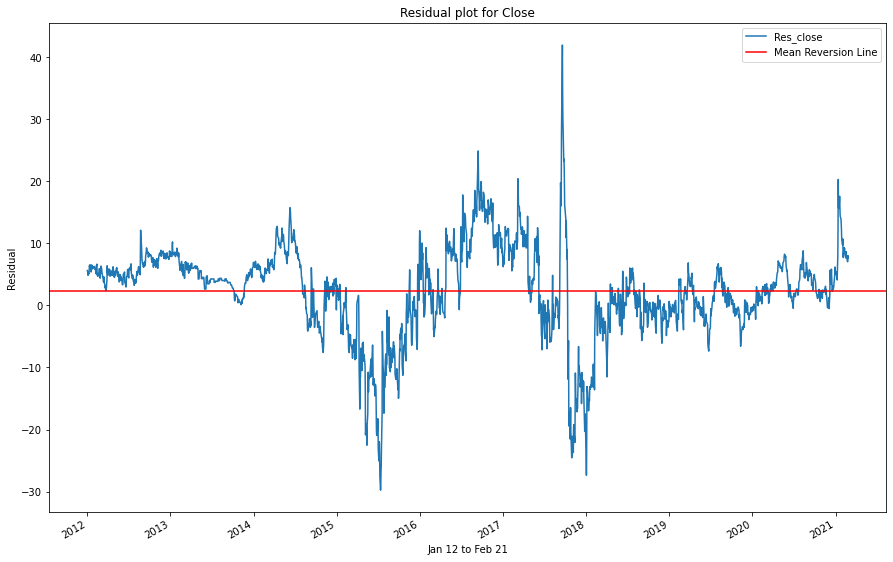

In [9]:
fig,ax = plt.subplots(1,figsize=(15,10))
data['Res_close'].plot(ax=ax)
plt.axhline(data['Res_close'].mean(),color='red',label='Mean Reversion Line')
plt.legend()
plt.xlabel('Jan 12 to Feb 21')
plt.ylabel('Residual')
plt.title('Residual plot for Close')
plt.show()

## Fast Fourier Transform

 - The basic idea behind Fast Fourier Transform, is that it leads to a sparse representation for many real-world signals and images. What this means is that it finds the constituent waves frequency/amplitude coefficients of the signal. Frequency/amplitude coefficients which are small in value are typically noise and you can "shrink" those coefficients or remove them without affecting the signal or image quality. After you threshold the coefficients, you reconstruct the data using the inverse fourier transform
 
 - Denoising algorithm
    - Apply the fft to the signal
    - Compute the frequencies associated with each coefficient
    - Keep only the coefficients which have a low enough frequency (in absolute)
    - Compute the inverse fft

In [10]:
#https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
def filter_signal(signal, threshold=3e4):
    '''
    Function to perform FFT
    
    ======Argument=====
    signal----Dataset
    
    ======Return======
    fourier --- Thresholded or noise free dataset
    '''
    fourier = rfft(signal)
    frequencies = rfftfreq(len(signal), d=20e-3/len(signal))
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

###### Checkpoint 4

In [11]:
data_2 = data.copy()
data_2 = data_2.dropna()## Dropping NAN rows
data_2 = data_2.reset_index(drop=True)

## Response Variable
 - Prediction Period is set for 5 days after the current day.

In [12]:
def response_variable(df,window =1):
    '''
    Function to create Response Variable for prediction
    
    ====Argument====
    df     : Data-set on which predicition is to be done
    window : Period in future for which prediction is to be done
    
    ====Return======
    data_Y: size =(len(df) - window) 5 days in future prediction list
    '''
    data_Y = []
    for i in range(len(df)-window):
        data_Y.append(float(df[i+window:i+1+window]))
    return data_Y

dataY = response_variable(data_2['Res_close'].values)

#data_2 = data_2.drop([2146,2147,2148,2149,2150]) ##Dropping Last 5 windows as no future prediction data is available for them
data_2 = data_2.drop([2150]) ##Dropping Last 5 windows as no future prediction data is available for them

data_2['Y_pred'] = dataY ## Adding Prediction variable to dataset

In [13]:
data_2

EQ_1_close  EQ_2_close  EQ_1_open  EQ_2_open  EQ_1_high  EQ_2_high  \
0         11.275   15.850000  10.865000  15.950000      11.50  16.450001   
1         11.425   16.750000  11.000000  15.750000      11.49  17.000000   
2         11.240   17.000000  11.500000  17.000000      12.18  18.000000   
3         11.400   17.500000  11.260000  16.799999      11.49  18.799999   
4         13.210   17.450001  12.480000  18.250000      13.47  19.200001   
...          ...         ...        ...        ...        ...        ...   
2145      21.100   28.049999  21.700001  27.049999      21.90  28.900000   
2146      20.900   27.049999  21.400000  28.900000      21.40  28.900000   
2147      20.750   26.799999  20.750000  27.000000      21.40  28.100000   
2148      20.750   27.000000  20.750000  26.900000      21.10  27.799999   
2149      21.150   28.150000  20.799999  27.799999      21.40  28.200001   

       EQ_1_low   EQ_2_low  EQ_1_vol  EQ_2_vol  ...   EQ_2_ema  EQ_1_macd  \
0     10.605000  15.750000     22150      1404  ...  10.306040   0.405186   
1     10.860000  15.750000     10640      3217  ...  10.455235   0.458618   
2     11.070000  16.100000     10410      6573  ...  10.559870   0.480496   
3     11.200000  16.500000      5020      1672  ...  10.671888   0.504925   
4     12.305000  17.350000    189820      8504  ...  11.010303   0.662697   
...         ...        ...       ...       ...  ...        ...        ...   
2145  20.950001  27.049999    103928      4242  ...  21.208959   0.129594   
2146  20.700001  26.650000     41725      7978  ...  21.167765   0.093604   
2147  20.700001  26.750000     41900      6007  ...  21.112063   0.052375   
2148  20.000000  26.900000     32282       278  ...  21.063788   0.019476   
2149  20.700001  26.600000     58400     13701  ...  21.075283   0.025387   

      EQ_2_macd   EQ_1_dlr  EQ_2_dlr  Res_open  Res_close  Res_high   Res_low  \
0      0.384103   6.173381 -0.941920  5.608883   5.113198  5.432936  5.712691   
1      0.434035   1.321610  5.522873  5.280392   5.870357  5.992516  5.471341   
2      0.488152  -1.632513  1.481509  6.054501   6.296526  6.331491  5.622583   
3      0.564874   1.413450  2.898754  6.082927   6.644164  7.792515  5.899541   
4      0.614559  14.736080 -0.286119  6.371754   4.870562  6.295665  5.703692   
...         ...        ...       ...       ...        ...       ...       ...   
2145  -0.340718  -2.342027 -1.063844  6.396317   7.957179  7.919677  7.221462   
2146  -0.458058  -0.952392 -3.630163  8.531853   7.147633  8.398680  7.058079   
2147  -0.564715  -0.720289 -0.928512  7.250512   7.040472  7.598681  7.158080   
2148  -0.625888   0.000000  0.743501  7.150512   7.240473  7.586081  7.970609   
2149  -0.574944   1.909364  4.171048  8.002923   8.009566  7.698681  7.008080   

        Y_pred  
0     5.870357  
1     6.296526  
2     6.644164  
3     4.870562  
4     4.987185  
...        ...  
2145  7.147633  
2146  7.040472  
2147  7.240473  
2148  8.009566  
2149  7.690474  

[2150 rows x 33 columns]

## Test, Train Split and FFT on Train data
- Split is temporal in nature due to data being time series
- FFT is not performed on Prediction variable and test data set otherwise it will cause data leakage

In [14]:
size = int(data_2.shape[0])

In [15]:
columns = ['EQ_1_close', 'EQ_2_close', 'EQ_1_open', 'EQ_2_open', 'EQ_1_high',
       'EQ_2_high', 'EQ_1_low', 'EQ_2_low', 'EQ_1_vol', 'EQ_2_vol', 'EQ_1_rsi',
       'EQ_2_rsi', 'EQ_1_srsi', 'EQ_2_srsi', 'EQ_1_mfi', 'EQ_2_mfi',
       'EQ_1_adl', 'EQ_2_adl', 'EQ_1_atr', 'EQ_2_atr', 'EQ_1_bb', 'EQ_2_bb',
       'EQ_1_ema', 'EQ_2_ema', 'EQ_1_macd', 'EQ_2_macd', 'EQ_1_dlr',
       'EQ_2_dlr', 'Res_open', 'Res_close', 'Res_high', 'Res_low']
data_3 = pd.DataFrame()
for cols in columns: ## Y_Pred column is not used for FFT
    data_3[cols] = filter_signal(data_2[cols][0:size])
data_3.index = data_2[0:size].index
data_fft = data_3.copy()
data_fft['Y_pred'] = data_2['Y_pred'][0:size]

In [16]:
size = int(data_fft.shape[0]*0.9)
train_data_fft = data_fft[0:size]
test_data = data_fft[size:]

In [21]:
# columns = ['EQ_1_close', 'EQ_2_close', 'EQ_1_open', 'EQ_2_open', 'EQ_1_high',
#        'EQ_2_high', 'EQ_1_low', 'EQ_2_low', 'EQ_1_vol', 'EQ_2_vol', 'EQ_1_rsi',
#        'EQ_2_rsi', 'EQ_1_srsi', 'EQ_2_srsi', 'EQ_1_mfi', 'EQ_2_mfi',
#        'EQ_1_adl', 'EQ_2_adl', 'EQ_1_atr', 'EQ_2_atr', 'EQ_1_bb', 'EQ_2_bb',
#        'EQ_1_ema', 'EQ_2_ema', 'EQ_1_macd', 'EQ_2_macd', 'EQ_1_dlr',
#        'EQ_2_dlr', 'Res_open', 'Res_close', 'Res_high', 'Res_low']
# data_3 = pd.DataFrame()
# for cols in columns: ## Y_Pred column is not used for FFT
#     data_3[cols] = filter_signal(train_data[cols][0:size-1])
# data_3.index = train_data[0:size-1].index
# train_data_fft = data_3.copy()
# train_data_fft['Y_pred'] = data_2['Y_pred'][0:size-1]

## Label Creation

# Residual Prediction using Kalman Filter
#https://www.youtube.com/watch?v=tk3OJjKTDnQ&list=PLX2gX-ftPVXU3oUFNATxGXY90AULiqnWT&index=2

- The Kalman Filter is a unsupervised algorithm for tracking a single object in a continuous state space. Given a sequence of noisy measurements, the Kalman Filter is able to recover the “true state” of the underling object being tracked.

# Residual/Spread Prediction using ARIMA
[Reference_1](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values.)
[Reference_2](https://www.youtube.com/watch?v=zMWeOBBa24Y)
- Arima uses its own lags and the lagged forecast errors to predict future values in time series
- ARIMA is divided in  parts, Auto Regression, Integrated, Moving Average.
- **Auto Regression**
    -  it is a linear regression model that uses its own lags as predictor
    -  a Linear regression model should be free of correlation.
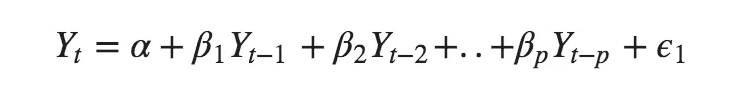

- **Integrated**
    - To remove correlation or to make the time series stationary in lagged time series, difference of current value from previous value is performed, it is to be done multiple times if required
- **Moving Average**
    - It is a linear regression model that uses lagged forecast errors from *Auto Regression* to forecast errors
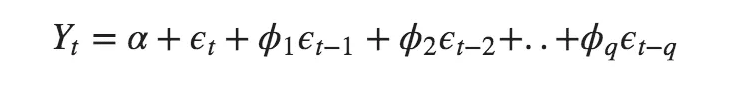

ARIMA Equation:
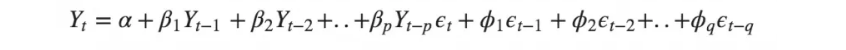

- Only Hyperparameters in ARIMA is the number of lag to be used in *Auto Regression*, *Moving Average* and number of times the *differencing*(Integrated) is to be performed
- Number of lags in Auto Regression can be found by studying *partial auto correlation plot*
- Number of lags in Moving Average and Differences required can be identified using *auto correlation plot* and *ADF test* to determine whether it is stationary or not

###### Stationarity Test for Order of difference

In [17]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data_fft['Res_close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.532513
p-value: 0.000000


###### AutoCorrelation with zero difference

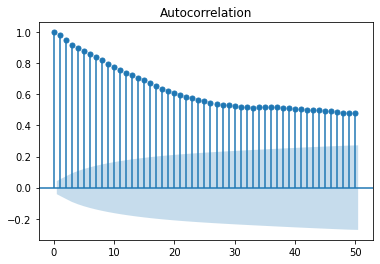

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_fft['Res_close'],lags=50)
plt.show()

###### AutoCorrelation with 1 difference - For Moving Average HyperParameter

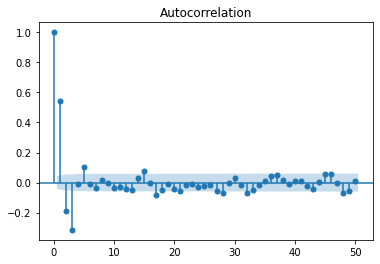

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_fft['Res_close'].diff().dropna(),lags=50)
plt.show()

###### PACF with 1 difference - For Auto Regression Hyper Parameter

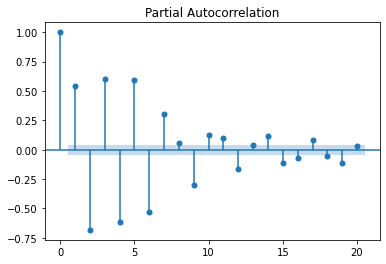

In [20]:
plot_pacf(data_fft['Res_close'].diff().dropna(),lags=20,method='ywm')
plt.show()

In [21]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [22]:
from statsmodels.tsa.arima_model import ARIMA
yhat_ARIMA = []
yhat_ARIMA_mse = []
data = data_fft['Res_close'].values
for i in range(size,len(data_fft)): ## for only test data
    model = ARIMA(data[:i], order=(1,1,0))
    model_fit = model.fit(disp=0)
    temp = []
    forecast = (model_fit.forecast(steps=1)[0])
    yhat_ARIMA.append(forecast[0])

/home/chandanmalla/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [23]:
from sklearn.metrics import mean_squared_error
print('MSE for ARIMA:',mean_squared_error(test_data['Y_pred'],yhat_ARIMA))

MSE for ARIMA: 2.4199818040587386


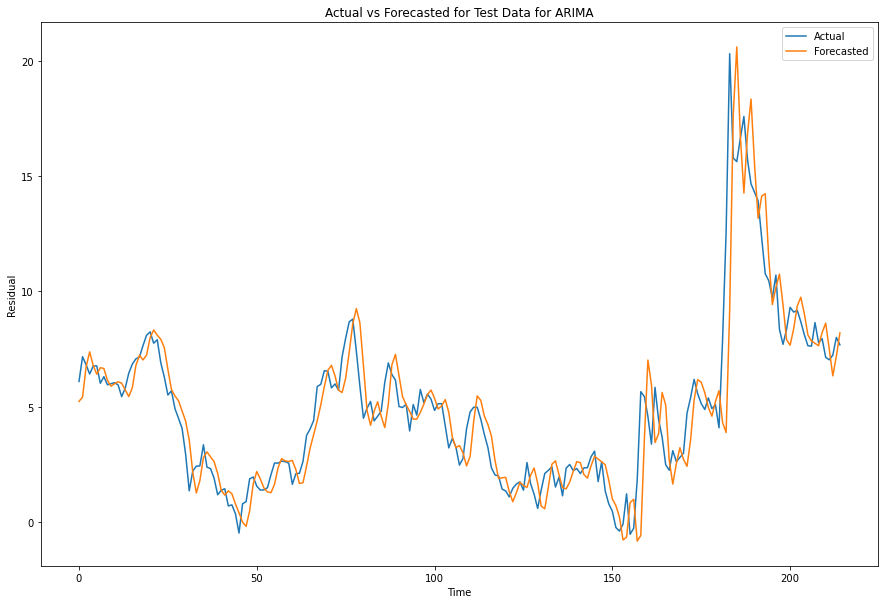

In [24]:
fig,ax = plt.subplots(1,figsize=(15,10))
plt.plot(test_data['Y_pred'].values,label='Actual')
plt.plot(yhat_ARIMA,label='Forecasted')
plt.legend()
plt.title('Actual vs Forecasted for Test Data for ARIMA')
plt.ylabel('Residual')
plt.xlabel('Time')
plt.show()

# Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,10),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_data_fft.drop(['Y_pred'],axis=1), train_data_fft['Y_pred'])
best_params = grid_result.best_params_

rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
scores = cross_val_score(rfr, train_data_fft.drop(['Y_pred'],axis=1), train_data_fft['Y_pred'], cv=10, scoring='neg_mean_absolute_error')

# clf = RandomForestRegressor(n_estimators=100,criterion='mse')
rfr.fit(train_data_fft.drop(['Y_pred'],axis=1),train_data_fft['Y_pred'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=False, verbose=False, warm_start=False)

In [26]:
yhat_RF = rfr.predict(test_data.drop(['Y_pred'],axis=1))
print('MSE for RF:',mean_squared_error(test_data['Y_pred'],yhat_RF))

MSE for RF: 0.8467591197248442


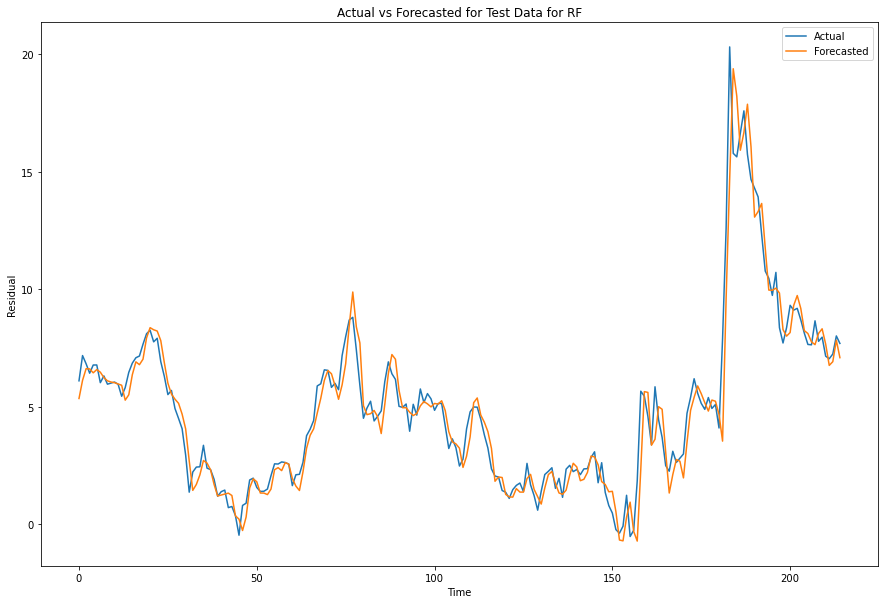

In [27]:
fig,ax = plt.subplots(1,figsize=(15,10))
plt.plot(test_data['Y_pred'].values,label='Actual')
plt.plot(yhat_RF,label='Forecasted')
plt.legend()
plt.title('Actual vs Forecasted for Test Data for RF')
plt.ylabel('Residual')
plt.xlabel('Time')
plt.show()

In [49]:
mse = make_scorer(mean_squared_error)

In [102]:
from sklearn.linear_model import ElasticNet

param_grid_en = {
        'alpha' : [0.0001,0.001,0.01,0.1,1,10,100,500,1000],
        'l1_ratio' : [0,0.25,0.5,0.75,1],
    }
    
gs_en = GridSearchCV(ElasticNet(max_iter=1000), param_grid=param_grid_en, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_en.fit(train_data_fft.drop(['Y_pred'],axis=1), train_data_fft['Y_pred'])


/home/chandanmalla/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2116.53312328387, tolerance: 11.907412486337025
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500,
                                   1000],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [104]:
clf_LR = ElasticNet(alpha=gs_en.best_params_['alpha'],l1_ratio=gs_en.best_params_['l1_ratio'])
clf_LR.fit(train_data_fft.drop(['Y_pred'],axis=1), train_data_fft['Y_pred'])
yhat_LR = clf.predict(test_data.drop(['Y_pred'],axis=1))
print('MSE for LR:',mean_squared_error(test_data['Y_pred'],yhat_LR))

MSE for LR: 0.6576984832554071


/home/chandanmalla/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2116.53312328387, tolerance: 11.907412486337025
  model = cd_fast.enet_coordinate_descent(


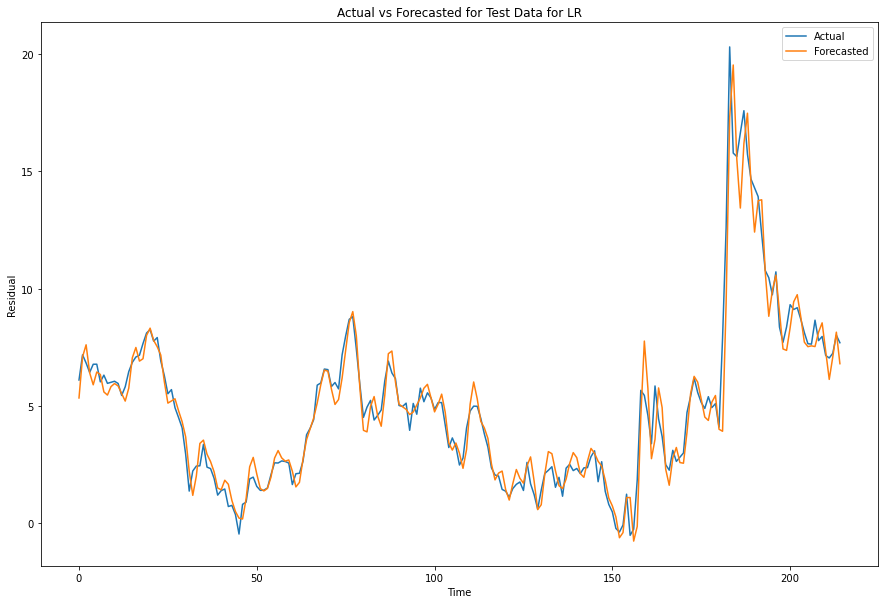

In [107]:
fig,ax = plt.subplots(1,figsize=(15,10))
plt.plot(test_data['Y_pred'].values,label='Actual')
plt.plot(yhat_LR,label='Forecasted')
plt.legend()
plt.title('Actual vs Forecasted for Test Data for LR')
plt.ylabel('Residual')
plt.xlabel('Time')
plt.show()

# Trading Strategy

- Trading Strategy is based on Z-score of current residual
- For z score > 1, I will send sell signal and for < -1, buy signal.

In [183]:
ratios_mavg60 = data_fft['Y_pred'].rolling(window=60,
                               center=False).mean()[-len(test_data)-1:][0:len(test_data)] ##Taking 60 day mean initially from train data and then add each day of test data to it

std_60 = data_fft['Y_pred'].rolling(window=60,
                        center=False).std()[-len(test_data)-1:][0:len(test_data)] ##Taking 60 day mean initially from train data and then add each day of test data to it


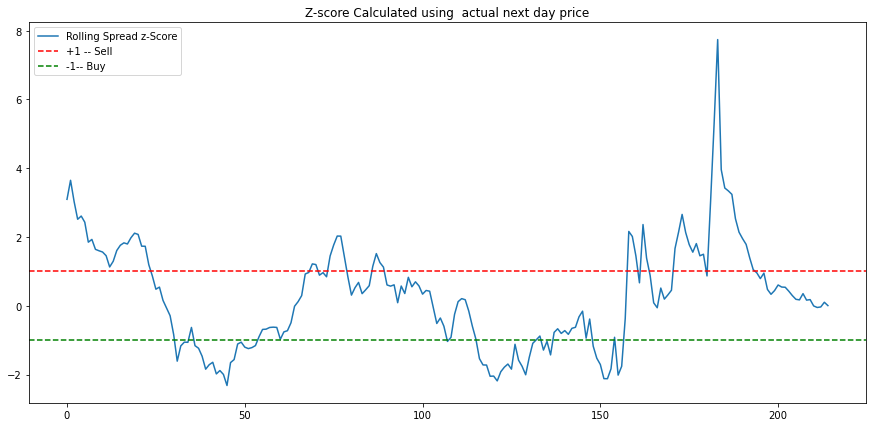

In [446]:
##Taking 60day STD as population mean
x = test_data['Y_pred'].reset_index(drop=True)
mu = ratios_mavg60.reset_index(drop=True)
sigma = std_60.reset_index(drop=True)
z_score = (x - mu)/sigma
plt.figure(figsize=(15,7))
z_score.plot()
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Spread z-Score', '+1 -- Sell', '-1-- Buy'])
plt.title('Z-score Calculated using  actual next day price')
plt.show()

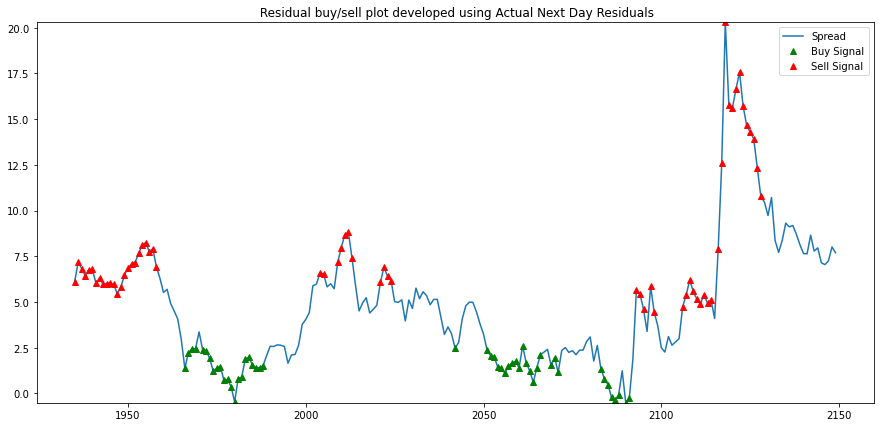

In [444]:
plt.figure(figsize=(15,7))
buy = test_data['Y_pred'].copy()
sell = test_data['Y_pred'].copy()
buy[np.array(z_score)>-1] = -100  ## will remove these points by limiting y axis.
sell[np.array(z_score)<1] = -100

test_data['Y_pred'].plot()
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,test_data['Y_pred'].min(),test_data['Y_pred'].max()))
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.title(' Residual buy/sell plot developed using Actual Next Day Residuals')
plt.show()

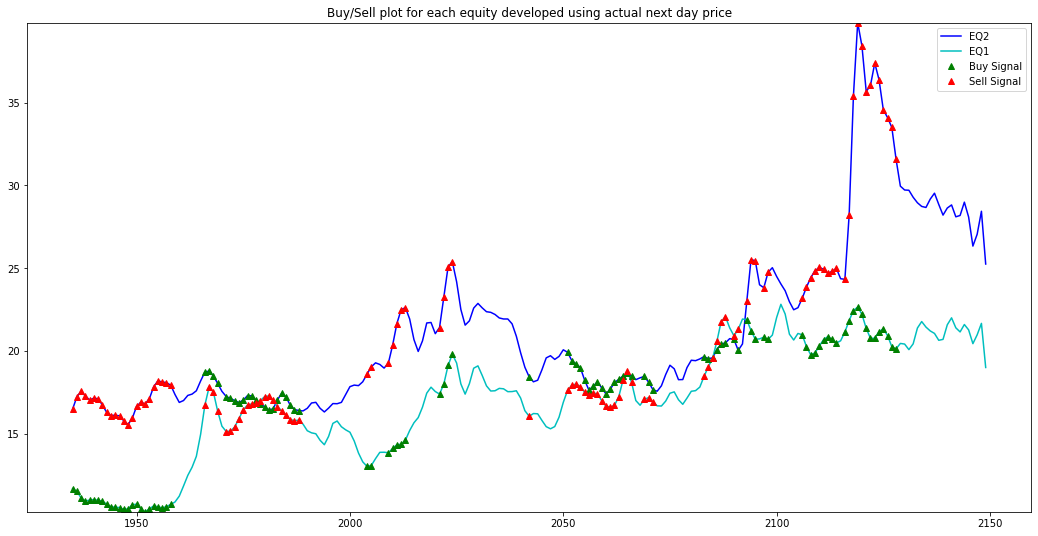

In [443]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
EQ1 = test_data.EQ_1_close
EQ2 = test_data.EQ_2_close

EQ2.plot(color='b')
EQ1.plot(color='c')
buyR = 0*EQ2.copy()
sellR = 0*EQ2.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=-100] = EQ2[buy!=-100]
sellR[buy!=-100] = EQ1[buy!=-100]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=-100] = EQ1[sell!=-100]
sellR[sell!=-100] = EQ2[sell!=-100]

buyR.plot(color='g', linestyle='None', marker='^')
sellR.plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(EQ1.min(),EQ2.min()),max(EQ1.max(),EQ2.max())))

plt.legend(['EQ2', 'EQ1', 'Buy Signal', 'Sell Signal'])
plt.title('Buy/Sell plot for each equity developed using actual next day price')
plt.show()


In [441]:
# def trade(EQ_1, EQ_2, Residual,test_data_len ,window=60):
#     ratios_mavg = Residual.rolling(window=window,
#                                center=False).mean()[-test_data_len-1:][0:test_data_len] ##Taking 60 day mean initially from train data and then add each day of test data to it

#     std = Residual.rolling(window=60,
#                         center=False).std()[-test_data_len-1:][0:test_data_len] ##Taking 60 day mean initially from train data and then add each day of test data to it
#     x = Residual[-test_data_len:].reset_index(drop=True)
#     mu = ratios_mavg60.reset_index(drop=True)
#     sigma = std_60.reset_index(drop=True)
#     z_score = (x - mu)/sigma
#     z_score = z_score.reset_index(drop=True)
#     EQ_1 = EQ_1.reset_index(drop=True)
#     EQ_2 = EQ_2.reset_index(drop=True)
#     money = 0
#     countEQ1 = 0
#     countEQ2 = 0

#     eq1bought = 0
#     eq1sold = 0 

#     eq2bought = 0
#     eq2sold = 0
#     for i in range(test_data_len):
#         # Sell short 
#         if z_score[i] > 1:

#             money += 100*(EQ_2[i] - EQ_1[i] * x[i] )
#             countEQ1 += x[i]*100
#             countEQ2 -= 100
            
# #             print('Buy EQ1:',money,EQ_1[i],x[i])
# #             print('Sell EQ2:',money,countEQ2)
# #             print('\n')
        
#         elif z_score[i] < -1:
            
#             money+=  100*(EQ_1[i] * x[i] - EQ_2[i])           
#             countEQ1 -= x[i]*100
#             countEQ2 += 100
            
# #             print('Sell EQ1:',EQ_1[i] * x[i],EQ_1[i],x[i])
# #             print('Buy EQ2:',EQ_2[i],countEQ2)
# #             print('Money',money)
# #             print('\n')
        
#         elif abs(z_score[i]) < 0.5:
# #             print('settle everything at eq2,eq1',EQ_2[i],countEQ2,EQ_1[i],countEQ1)
#             money += countEQ2 * EQ_2[i] + EQ_1[i] * countEQ1
#             countEQ1 = 0
#             countEQ2 = 0
#     return money

In [426]:
def trade(EQ_1, EQ_2, Residual,test_data_len ,share_multiplier,window=60):
    ratios_mavg = Residual.rolling(window=window,
                               center=False).mean()[-test_data_len-1:][0:test_data_len] ##Taking 60 day mean initially from train data and then add each day of test data to it

    std = Residual.rolling(window=window,
                        center=False).std()[-test_data_len-1:][0:test_data_len] ##Taking 60 day mean initially from train data and then add each day of test data to it
    x = Residual[-test_data_len:].reset_index(drop=True)
    mu = ratios_mavg60.reset_index(drop=True)
    sigma = std_60.reset_index(drop=True)
    z_score = (x - mu)/sigma
    z_score = z_score.reset_index(drop=True)
    EQ_1 = EQ_1.reset_index(drop=True)
    EQ_2 = EQ_2.reset_index(drop=True)
    money = 0
    countEQ1 = 0
    countEQ2 = 0

    eq1bought = 0
    eq1sold = 0 

    eq2bought = 0
    eq2sold = 0
    for i in range(test_data_len):
        # Sell short 
        if z_score[i] > 1:

            money += share_multiplier*(EQ_2[i]* x[i] - EQ_1[i]  )
            countEQ2 -= x[i]*share_multiplier
            countEQ1 += 1*share_multiplier
            
#             print('Buy EQ1:',money,EQ_1[i],x[i])
#             print('Sell EQ2:',money,countEQ2)
#             print('\n')
        
        elif z_score[i] < -1:
            
            money+=  share_multiplier*(EQ_1[i] - EQ_2[i]* x[i])           
            countEQ2 += x[i]*share_multiplier
            countEQ1 -= 1*share_multiplier
            
#             print('Sell EQ1:',EQ_1[i] * x[i],EQ_1[i],x[i])
#             print('Buy EQ2:',EQ_2[i],countEQ2)
#             print('Money',money)
#             print('\n')
        
        elif abs(z_score[i]) < 0.5:
            money += countEQ2 * EQ_2[i] + EQ_1[i] * countEQ1
            countEQ1 = 0
            countEQ2 = 0
    return money

In [431]:
profit_actual = trade(test_data['EQ_1_close'], test_data['EQ_2_close'], data_fft['Y_pred'], len(test_data),10)

yhat_LR =clf.predict(data_fft.drop(['Y_pred'],axis=1))
profit_LR = trade(test_data['EQ_1_close'], test_data['EQ_2_close'], pd.DataFrame(yhat_LR)[0], len(test_data),10)

yhat_RF =rfr.predict(data_fft.drop(['Y_pred'],axis=1))
profit_RF = trade(test_data['EQ_1_close'], test_data['EQ_2_close'], pd.DataFrame(yhat_RF)[0], len(test_data),10)

In [434]:
print('Profit at actual Price of next day: \t\t',profit_actual)
print('Profit at Predicted Price of next day using LR: ',profit_LR)
print('Profit at Predicted Price of next day using RF: ',profit_RF)

Profit at actual Price of next day: 		 9337.889865173798
Profit at Predicted Price of next day using LR:  11304.181844212108
Profit at Predicted Price of next day using RF:  12496.581864440399


In [448]:
rfr.feature_importances_

array([1.04291050e-03, 1.33215268e-03, 3.85053095e-04, 6.58703568e-04,
       2.25813637e-04, 8.71569302e-04, 3.34280221e-04, 3.20183757e-04,
       2.47260474e-03, 1.53357874e-03, 4.41260719e-04, 6.76246602e-04,
       6.38913308e-04, 7.66038029e-04, 1.03087683e-03, 1.24997592e-03,
       9.48724092e-04, 1.15636207e-03, 6.93324417e-04, 4.26494855e-04,
       3.42339313e-04, 7.84278684e-04, 2.11071977e-04, 2.44099911e-04,
       5.69517732e-04, 2.20730749e-03, 1.83718191e-03, 4.28266939e-03,
       2.00856906e-03, 9.62477686e-01, 5.02578946e-03, 2.80442221e-03])

In [452]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [461]:
print(data_fft['Y_pred'][0])

5.870356632905651


1. feature 29 (0.962478)
2. feature 30 (0.005026)
3. feature 27 (0.004283)
4. feature 31 (0.002804)
5. feature 8 (0.002473)
6. feature 25 (0.002207)
7. feature 28 (0.002009)
8. feature 26 (0.001837)
9. feature 9 (0.001534)
10. feature 1 (0.001332)
11. feature 15 (0.001250)
12. feature 17 (0.001156)
13. feature 0 (0.001043)
14. feature 14 (0.001031)
15. feature 16 (0.000949)
16. feature 5 (0.000872)
17. feature 21 (0.000784)
18. feature 13 (0.000766)
19. feature 18 (0.000693)
20. feature 11 (0.000676)
21. feature 3 (0.000659)
22. feature 12 (0.000639)
23. feature 24 (0.000570)
24. feature 10 (0.000441)
25. feature 19 (0.000426)
26. feature 2 (0.000385)
27. feature 20 (0.000342)
28. feature 6 (0.000334)
29. feature 7 (0.000320)
30. feature 23 (0.000244)
31. feature 4 (0.000226)
32. feature 22 (0.000211)


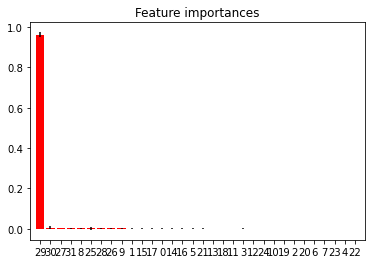

In [454]:
X = data_fft.drop(['Y_pred'],axis=1)
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()